# GuidedMatDiffusion — Hello World
## Notebook map

| § | Title | Key concepts introduced |
|---|-------|------------------------|
| 0 | Setup & imports | Paths, seeds, device |
| 1 | Crystal representation | Unit cell, fractional coords, why DiffCSP uses them, 3 symmetry proofs |
| 2 | Forward diffusion | β-schedule, reparameterisation trick, Wrapped Normal |
| 3 | Denoising network | E(3) equivariance *and how it is preserved*, Gram matrix, Fourier distance features |
| 4 | Classifier-free guidance | Bayes derivation, null token, guidance weight math |
| 5 | Dataset + Training | null-token CFG, device-safe schedule, EMA, checkpointing |
| 6 | Reverse sampling | DDPM derivation, guided generation loop |
| 7 | Visualisation | 3-D unit cell, fractional projections, loss curves |
| 8 | Workflow diagram | End-to-end pipeline |


## §0 — Setup & Imports

In [23]:
import os, math, json, warnings
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D
from pathlib import Path
from datetime import datetime
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR

# ── Reproducibility ──────────────────────────────────────────
# SEED = 42
# torch.manual_seed(SEED)
# np.random.seed(SEED)

# ── Timestamped output directories ──────────────────────────
TIMESTAMP   = datetime.now().strftime('%Y%m%d_%H%M%S')
OUTPUT_DIR  = Path(f'outputs_new{TIMESTAMP}')
CKPT_DIR    = OUTPUT_DIR / 'checkpoints'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
CKPT_DIR.mkdir(parents=True, exist_ok=True)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device  : {DEVICE}')
print(f'PyTorch : {torch.__version__}')
print(f'Outputs : {OUTPUT_DIR.resolve()}')


Device  : cuda
PyTorch : 2.10.0+cu128
Outputs : /home/sangam/vsc/diffusion_material/new_new_crystal/outputs_new20260227_060951


---
## 1. Crystal Representation Theory

A crystal is an **infinite, periodic** arrangement of atoms.
We store only the repeating unit that is the unit cell and tile it infinitely via lattice translations.

Every crystal is fully described by the triple:

$$\mathcal{M} = (\mathbf{L},\; \mathbf{F},\; \mathbf{A})$$

| Symbol | Name | Shape | Meaning |
|--------|------|-------|---------|
| $\mathbf{L}$ | Lattice matrix | $\mathbb{R}^{3\times3}$ | Columns = lattice vectors; defines unit-cell shape and volume |
| $\mathbf{F}$ | Fractional coordinates | $[0,1)^{N\times3}$ | Each atom's position **relative** to the unit cell |
| $\mathbf{A}$ | Atom types | $\mathbb{Z}^N$ | Atomic number of each atom (H=1, O=8, Cu=29 …) |

---

### 1.2 The Lattice Matrix $\mathbf{L}$

$$\mathbf{L} = \begin{bmatrix} | & | & | \\ \mathbf{a}_1 & \mathbf{a}_2 & \mathbf{a}_3 \\ | & | & | \end{bmatrix}$$

The six classical parameters $(a,b,c,\alpha,\beta,\gamma)$ are recovered by:

$$a = \|\mathbf{a}_1\|,\quad
  b = \|\mathbf{a}_2\|,\quad
  c = \|\mathbf{a}_3\|,\quad
  \cos\alpha = \frac{\mathbf{a}_2\cdot\mathbf{a}_3}{bc},\quad\ldots$$

Cartesian position of atom $i$:

$$\mathbf{x}_i^{\text{cart}} = \mathbf{L}\,\mathbf{f}_i$$

---

### 1.3 Why Fractional Coordinates?

This is arguably the most important modelling choice in DiffCSP.

Problem with Cartesian coordinates:
If we double the lattice constant $a$, every Cartesian position doubles, yet the crystal topology (which atom is bonded to which) is identical. A network trained on Cartesian coordinates must learn this scale-invariance implicitly, which wastes capacity and hurts generalisation.

---

### 1.4 The Three Physical Symmetries DiffCSP Preserves

Violating any of these would mean assigning different probabilities to physically identical crystals, which is wrong physics.

---

#### Symmetry 1 — O(3) Rotation / Reflection Invariance

**Statement:**
$$p(\mathbf{Q}\mathbf{L},\,\mathbf{F}\mid\mathbf{A}) = p(\mathbf{L},\mathbf{F}\mid\mathbf{A}) \quad\forall\,\mathbf{Q}\in O(3)$$

**Why it must hold:** Rotating a crystal in space does not create a new material.

**How DiffCSP enforces it? : the Gram matrix trick:**

The lattice encoder does not feed $\mathbf{L}$ directly to the network.
Instead it uses the **Gram matrix** $\mathbf{G} = \mathbf{L}^\top\mathbf{L}$.

Proof of invariance:
$$(\mathbf{Q}\mathbf{L})^\top(\mathbf{Q}\mathbf{L}) = \mathbf{L}^\top\underbrace{\mathbf{Q}^\top\mathbf{Q}}_{=\mathbf{I}}\mathbf{L} = \mathbf{L}^\top\mathbf{L} = \mathbf{G}$$

So any rotation $\mathbf{Q}$ maps $\mathbf{G}\to\mathbf{G}$ — the network input is unchanged.

The lattice noise output is then symmetrised: $\hat{\boldsymbol{\epsilon}}_L \leftarrow \frac{1}{2}(E + E^\top)$.
Symmetric matrices form an O(3)-invariant subset of $\mathbb{R}^{3\times3}$ (a symmetric matrix times a rotation is still characterised by the same Gram matrix). 

---

#### Symmetry 2 — Periodic Translation Invariance

**Statement:**
$$p\bigl(\mathbf{L},\,w(\mathbf{F}+\mathbf{1}\mathbf{t}^\top)\mid\mathbf{A}\bigr) = p(\mathbf{L},\mathbf{F}\mid\mathbf{A}) \quad\forall\,\mathbf{t}\in\mathbb{R}^3$$

where $w(\cdot) = (\cdot)\bmod 1$ is the fractional-wrap operator.

**Why it must hold:** Shifting all atoms by the same vector (and wrapping) gives the same crystal — it just picks a different origin within the unit cell.

**How DiffCSP enforces it? : pairwise differences + Fourier encoding:**

Message passing uses *differences* $\delta_{ij} = w(\mathbf{f}_i - \mathbf{f}_j)$, never absolute coordinates.
If you shift all $\mathbf{f}_i \to \mathbf{f}_i + \mathbf{t}$:
$$\delta_{ij} = w((\mathbf{f}_i+\mathbf{t})-(\mathbf{f}_j+\mathbf{t})) = w(\mathbf{f}_i-\mathbf{f}_j)$$
The shift $\mathbf{t}$ cancels exactly.

These differences are then encoded with **Fourier features**:
$$\Phi_k(\delta) = [\sin(2\pi k\delta),\,\cos(2\pi k\delta)],\quad k=1,\ldots,K$$

Because $\sin$ and $\cos$ are periodic with period 1, $\Phi_k(\delta+1) = \Phi_k(\delta)$, so the encoding is consistent across period boundaries.

---

#### Symmetry 3 — Permutation Invariance

**Statement:**
$$p(\mathbf{L},\mathbf{F}_{\pi},\mathbf{A}_{\pi}) = p(\mathbf{L},\mathbf{F},\mathbf{A}) \quad\forall\text{ permutations }\pi$$

**Why it must hold:** Atoms have no inherent ordering — SwappingAtom 1 and Atom 2 in the list does not create a new crystal.

**How DiffCSP enforces it? : symmetric aggregation:**

The message aggregation step sums (or averages) over all neighbours:
$$\mathbf{h}_i \leftarrow \mathbf{h}_i + \sum_{j\neq i} m_{ij}$$

Summation is commutative: reordering the $j$ indices gives the same result. 

The global lattice prediction uses mean-pooling:
$$\bar{\mathbf{h}} = \frac{1}{N}\sum_{i=1}^N \mathbf{h}_i$$

Again symmetric over all orderings. 

---

### 1.5 The Gram Matrix in Detail

$$\mathbf{G} = \mathbf{L}^\top\mathbf{L} = \begin{pmatrix}
\mathbf{a}_1\cdot\mathbf{a}_1 & \mathbf{a}_1\cdot\mathbf{a}_2 & \mathbf{a}_1\cdot\mathbf{a}_3 \\
\mathbf{a}_2\cdot\mathbf{a}_1 & \mathbf{a}_2\cdot\mathbf{a}_2 & \mathbf{a}_2\cdot\mathbf{a}_3 \\
\mathbf{a}_3\cdot\mathbf{a}_1 & \mathbf{a}_3\cdot\mathbf{a}_2 & \mathbf{a}_3\cdot\mathbf{a}_3
\end{pmatrix}$$

Each entry $G_{ij} = \mathbf{a}_i\cdot\mathbf{a}_j$ encodes:
- $G_{ii} = a_i^2$ — squared length of lattice vector $i$
- $G_{ij} = a_i a_j \cos\theta_{ij}$ — product of lengths times cosine of angle between them

All six lattice parameters $(a,b,c,\alpha,\beta,\gamma)$ are recoverable from $\mathbf{G}$ alone — yet $\mathbf{G}$ is rotation-invariant. This is why it is the natural lattice representation for an equivariant model.


In [24]:
# ═══════════════════════════════════════════════════════════════════
#  CRYSTAL CLASS
#  Encapsulates (L, F, A) with fully documented geometry utilities
# ═══════════════════════════════════════════════════════════════════

ELEM = {1:'H',6:'C',7:'N',8:'O',14:'Si',22:'Ti',26:'Fe',
        29:'Cu',38:'Sr',39:'Y',56:'Ba',57:'La',83:'Bi'}
ELEM_COL = {8:'#d2a8ff',22:'#7ee787',29:'#58a6ff',
            38:'#f78166',39:'#bc8cff',56:'#ff7b72',57:'#e3b341'}

class Crystal:
    """
    Stores a crystal as the triple (L, F, A) and provides geometric helpers.

    Why fractional coordinates?
    ───────────────────────────
    Cartesian x = L·f changes every time the lattice deforms; fractional f
    does not — it is a purely topological descriptor.  Periodicity is free:
    f and f+n (integer n) represent the same site, so wrapping = f % 1.

    All geometry methods are O(N) in atom count N unless stated.
    """

    def __init__(self, lattice, frac_coords, atom_types, property_val=None):
        self.lattice      = lattice.float()
        self.frac_coords  = (frac_coords.float() % 1.0)   # enforce [0,1)
        self.atom_types   = atom_types.long()
        self.property_val = property_val
        self.N            = len(atom_types)

    def to_cartesian(self):
        """
        x_cart = L @ f   (column-convention lattice).

        Shape: (N, 3).  Time O(N).
        WHY column convention: the i-th column of L is lattice vector a_i,
        so L @ f gives a linear combination a_1*f_1 + a_2*f_2 + a_3*f_3
        which is the Cartesian position of a point at fractional coords f.
        """
        return self.frac_coords @ self.lattice.T     # (N,3)@(3,3) -> (N,3)

    def gram_matrix(self):
        """
        G = L^T L  — the metric tensor.

        Properties:
          • Symmetric positive-definite (SPD)
          • O(3)-INVARIANT: (QL)^T(QL) = L^T Q^T Q L = L^T L = G
          • Encodes all 6 lattice parameters (a,b,c,alpha,beta,gamma)
          • Used as the lattice representation fed into the neural network

        Time O(1) — 3x3 matmul.
        """
        return self.lattice.T @ self.lattice         # (3,3)

    def volume(self):
        """
        V = |det(L)|   (parallelepiped volume).
        For cubic: det(aI) = a^3.  Time O(1).
        """
        return torch.abs(torch.det(self.lattice))

    def lattice_params(self):
        """
        Extract (a,b,c,alpha,beta,gamma) from the Gram matrix.  Time O(1).
        """
        G = self.gram_matrix()
        a = torch.sqrt(G[0,0].clamp(min=1e-8))
        b = torch.sqrt(G[1,1].clamp(min=1e-8))
        c = torch.sqrt(G[2,2].clamp(min=1e-8))
        alpha = torch.acos((G[1,2]/(b*c)).clamp(-1,1)) * 180/math.pi
        beta  = torch.acos((G[0,2]/(a*c)).clamp(-1,1)) * 180/math.pi
        gamma = torch.acos((G[0,1]/(a*b)).clamp(-1,1)) * 180/math.pi
        return dict(a=a, b=b, c=c, alpha=alpha, beta=beta, gamma=gamma)

    def pairwise_frac_dist(self):
        """
        Shortest-path pairwise distances in fractional space.
        Accounts for periodic boundary: delta = min(d, 1-d) per component.
        Time O(N^2).
        """
        F = self.frac_coords           # (N,3)
        diff = F.unsqueeze(0) - F.unsqueeze(1)   # (N,N,3)
        diff = diff % 1.0
        diff = torch.where(diff > 0.5, diff - 1.0, diff)
        return torch.norm(diff, dim=-1)           # (N,N)

    def __repr__(self):
        p = self.lattice_params()
        return (f'Crystal(N={self.N}, '
                f'a={p["a"]:.3f} b={p["b"]:.3f} c={p["c"]:.3f} Ang, '
                f'V={self.volume():.2f} Ang^3, Tc={self.property_val})')


# ── Demo: build SrTiO3 perovskite ─────────────────────────────────
def make_SrTiO3(a=3.9):
    """
    SrTiO3 cubic perovskite, space group Pm-3m (#221).

    Wyckoff positions:
      Sr (A-site) : 1a  (0,0,0)           — corner
      Ti (B-site) : 1b  (1/2,1/2,1/2)     — body-centre
      O  (X-site) : 3c  (1/2,1/2,0)+perms — face-centres
    """
    L    = torch.eye(3) * a
    frac = torch.tensor([[0.,0.,0.],[.5,.5,.5],[.5,.5,0.],[.5,0.,.5],[0.,.5,.5]])
    atypes = torch.tensor([38, 22, 8, 8, 8])       # Sr, Ti, O, O, O
    return Crystal(L, frac, atypes, property_val=0.0)

c = make_SrTiO3()
print(c)
p = c.lattice_params()
for k,v in p.items():
    print(f'  {k} = {v:.4f}')
print(f'Gram matrix (=L^T L, rotation-invariant):')
print(c.gram_matrix())
print(f'Volume: {c.volume():.3f} Ang^3')
print(f'Cartesian coords (first 3):')
print(c.to_cartesian()[:3])


Crystal(N=5, a=3.900 b=3.900 c=3.900 Ang, V=59.32 Ang^3, Tc=0.0)
  a = 3.9000
  b = 3.9000
  c = 3.9000
  alpha = 90.0000
  beta = 90.0000
  gamma = 90.0000
Gram matrix (=L^T L, rotation-invariant):
tensor([[15.2100,  0.0000,  0.0000],
        [ 0.0000, 15.2100,  0.0000],
        [ 0.0000,  0.0000, 15.2100]])
Volume: 59.319 Ang^3
Cartesian coords (first 3):
tensor([[0.0000, 0.0000, 0.0000],
        [1.9500, 1.9500, 1.9500],
        [1.9500, 1.9500, 0.0000]])


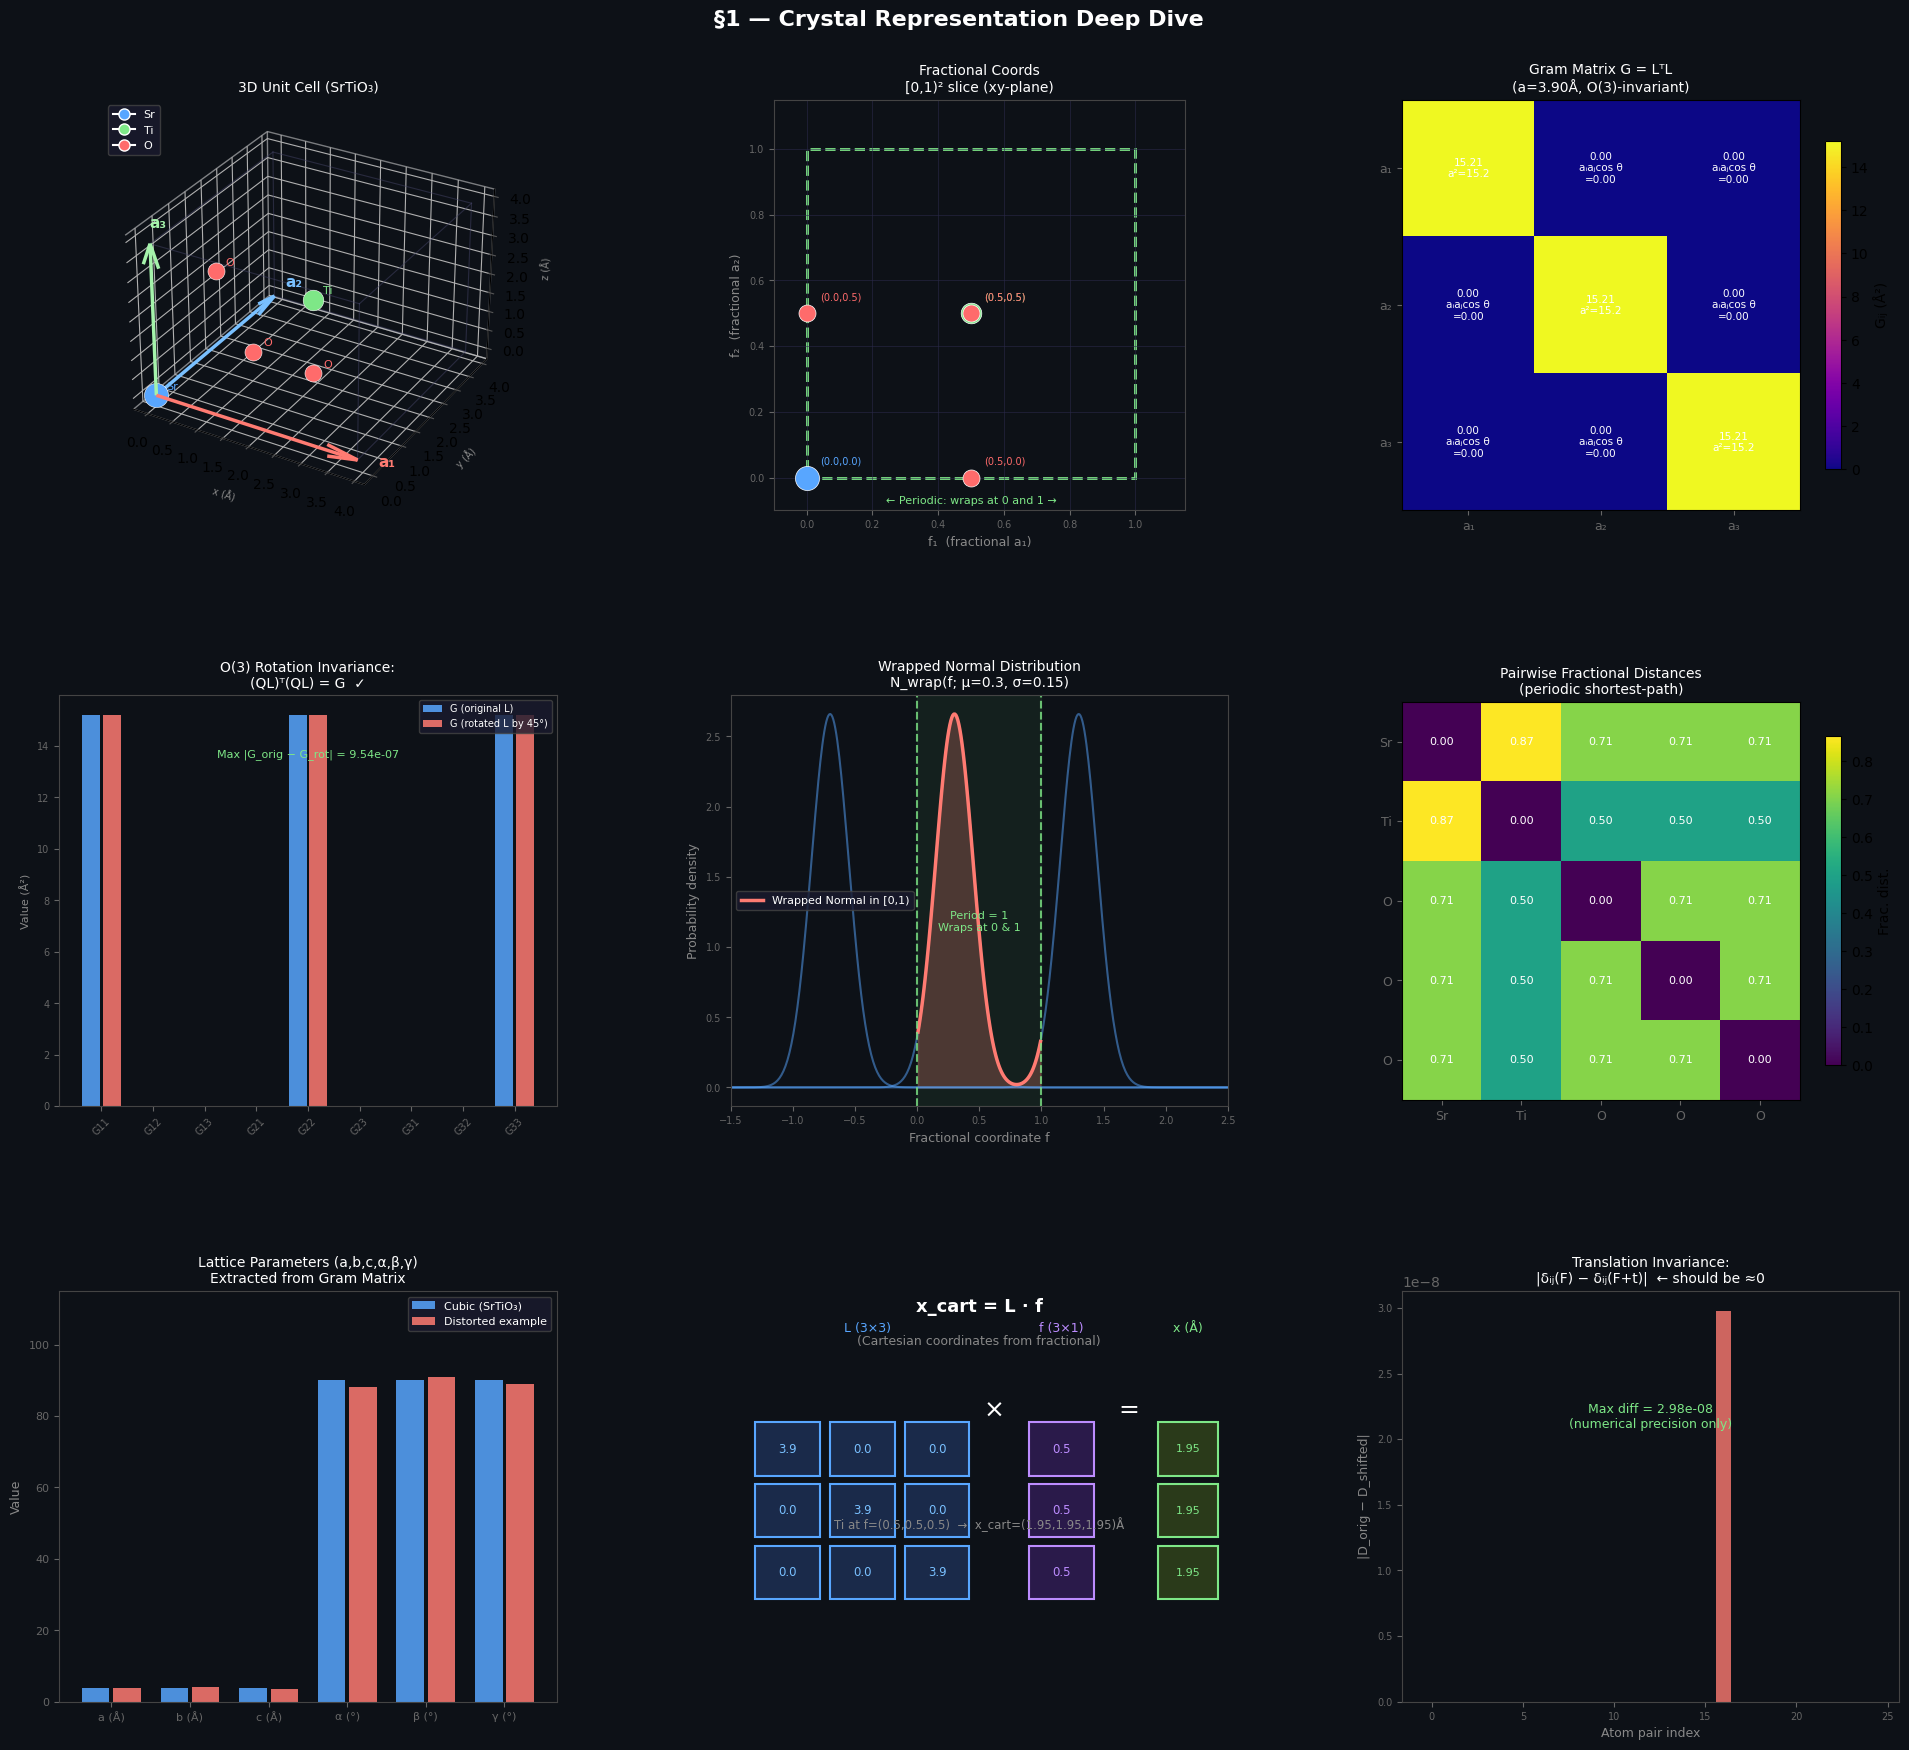

§1 Crystal Representation — 9-panel visualization complete ✓


In [25]:

# ═══════════════════════════════════════════════════════════════════════════
#  VIZ §1 — Crystal Representation: 6-panel educational visualisation
#  Shows: 3D unit cell, fractional vs Cartesian coords, Gram matrix heatmap,
#         rotation invariance proof, periodicity wrapping, pairwise distances
# ═══════════════════════════════════════════════════════════════════════════

import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
from matplotlib.patches import FancyArrowPatch, Arc
from mpl_toolkits.mplot3d import proj3d

c0 = make_SrTiO3(a=3.9)

fig = plt.figure(figsize=(20, 18), facecolor='#0d1117')
fig.suptitle('§1 — Crystal Representation Deep Dive', color='white', fontsize=16, fontweight='bold', y=0.98)

gs = gridspec.GridSpec(3, 3, figure=fig, hspace=0.45, wspace=0.35,
                       left=0.05, right=0.97, top=0.93, bottom=0.04)

ELEM_NAMES = {8:'O', 22:'Ti', 38:'Sr'}
ELEM_COLORS = {8:'#ff6b6b', 22:'#7ee787', 38:'#58a6ff'}
ELEM_SIZES  = {8:150, 22:220, 38:300}

# ── Panel 1: 3D Unit Cell ─────────────────────────────────────────────────
ax3d = fig.add_subplot(gs[0, 0], projection='3d')
ax3d.set_facecolor('#0d1117')
L  = c0.lattice.numpy()
cart = c0.to_cartesian().numpy()
typs = c0.atom_types.numpy()

# Lattice vectors as arrows
origin = np.zeros(3)
colors_vec = ['#ff7b72', '#79c0ff', '#a5f3ab']
labels_vec = ['a₁', 'a₂', 'a₃']
for i in range(3):
    v = L[i]  # row i = lattice vector i
    ax3d.quiver(*origin, *v, color=colors_vec[i], linewidth=2.5,
                arrow_length_ratio=0.15)
    ax3d.text(*(v*1.1), labels_vec[i], color=colors_vec[i], fontsize=11, fontweight='bold')

# Unit cell edges
def _edges(L):
    corners = [np.zeros(3), L[0], L[1], L[2],
               L[0]+L[1], L[0]+L[2], L[1]+L[2], L[0]+L[1]+L[2]]
    edges = [(0,1),(0,2),(0,3),(1,4),(1,5),(2,4),(2,6),
             (3,5),(3,6),(4,7),(5,7),(6,7)]
    return corners, edges

corners, edges = _edges(L)
for i, j in edges:
    ax3d.plot(*zip(corners[i], corners[j]), '-', color='#444466', alpha=0.5, lw=0.8)

# Atoms
for xyz, Z in zip(cart, typs):
    ax3d.scatter(*xyz, c=ELEM_COLORS.get(int(Z), '#aaa'), s=ELEM_SIZES.get(int(Z), 150),
                 depthshade=True, edgecolors='white', linewidths=0.4, zorder=5)
    ax3d.text(*(xyz + 0.12), ELEM_NAMES.get(int(Z), str(int(Z))),
              color=ELEM_COLORS.get(int(Z), '#aaa'), fontsize=8)

ax3d.set_title('3D Unit Cell (SrTiO₃)', color='white', fontsize=10, pad=6)
for ax_l in [ax3d.xaxis, ax3d.yaxis, ax3d.zaxis]:
    ax_l.pane.fill = False
    ax_l.label.set_color('#888')
    ax_l.set_tick_params(color='#555')
ax3d.set_xlabel('x (Å)', color='#888', fontsize=7)
ax3d.set_ylabel('y (Å)', color='#888', fontsize=7)
ax3d.set_zlabel('z (Å)', color='#888', fontsize=7)

# Legend
from matplotlib.lines import Line2D
legend_els = [Line2D([0],[0],marker='o',color='w',markerfacecolor=ELEM_COLORS[Z],
              markersize=8,label=ELEM_NAMES[Z]) for Z in [38,22,8]]
ax3d.legend(handles=legend_els, loc='upper left', fontsize=8,
            facecolor='#1a1a2e', edgecolor='#444', labelcolor='white')

# ── Panel 2: Fractional Coordinates Grid ─────────────────────────────────
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_facecolor('#0d1117')
ax2.set_aspect('equal')

# Draw the unit cell square in fractional space
for x in np.linspace(0, 1, 6):
    ax2.axvline(x, color='#2a2a4a', lw=0.5, alpha=0.8)
    ax2.axhline(x, color='#2a2a4a', lw=0.5, alpha=0.8)
ax2.add_patch(patches.Polygon([[0,0],[1,0],[1,1],[0,1]], fill=False,
              edgecolor='#7ee787', lw=2, linestyle='--'))

frac = c0.frac_coords.numpy()
for f, Z in zip(frac, typs):
    ax2.scatter(f[0], f[1], s=ELEM_SIZES.get(int(Z), 150),
                c=ELEM_COLORS.get(int(Z), '#aaa'),
                edgecolors='white', linewidths=0.5, zorder=5)
    ax2.annotate(f'({f[0]:.1f},{f[1]:.1f})', xy=(f[0], f[1]),
                 xytext=(f[0]+0.04, f[1]+0.04),
                 color=ELEM_COLORS.get(int(Z), '#aaa'), fontsize=7)

ax2.set_xlim(-0.1, 1.15)
ax2.set_ylim(-0.1, 1.15)
ax2.set_xlabel('f₁  (fractional a₁)', color='#888', fontsize=9)
ax2.set_ylabel('f₂  (fractional a₂)', color='#888', fontsize=9)
ax2.set_title('Fractional Coords\n[0,1)² slice (xy-plane)', color='white', fontsize=10)
ax2.tick_params(colors='#666', labelsize=7)
plt.setp(ax2.spines.values(), color='#444')
ax2.text(0.5, -0.08, '← Periodic: wraps at 0 and 1 →', ha='center', color='#7ee787', fontsize=8)

# ── Panel 3: Gram Matrix Heatmap ─────────────────────────────────────────
ax3 = fig.add_subplot(gs[0, 2])
ax3.set_facecolor('#0d1117')
G = c0.gram_matrix().numpy()
p = c0.lattice_params()
im = ax3.imshow(G, cmap='plasma', aspect='auto')
plt.colorbar(im, ax=ax3, label='Gᵢⱼ (Å²)', shrink=0.8)
ax3.set_xticks([0,1,2]); ax3.set_yticks([0,1,2])
ax3.set_xticklabels(['a₁','a₂','a₃'], color='#ccc', fontsize=9)
ax3.set_yticklabels(['a₁','a₂','a₃'], color='#ccc', fontsize=9)
for i in range(3):
    for j in range(3):
        val = G[i, j]
        meaning = ''
        if i == j:
            meaning = f'a²={val:.1f}'
        else:
            meaning = f'aᵢaⱼcos θ\n={val:.2f}'
        ax3.text(j, i, f'{val:.2f}\n{meaning}', ha='center', va='center',
                 color='white', fontsize=7.5)
ax3.set_title(f'Gram Matrix G = LᵀL\n(a={p["a"]:.2f}Å, O(3)-invariant)', color='white', fontsize=10)
ax3.tick_params(colors='#666')

# ── Panel 4: Rotation Invariance Demo ────────────────────────────────────
ax4 = fig.add_subplot(gs[1, 0])
ax4.set_facecolor('#0d1117')

# Show L and Q*L have the same G
import torch as _t
L_t = c0.lattice
theta = np.pi / 4
Q = _t.tensor([[np.cos(theta), -np.sin(theta), 0.],
               [np.sin(theta),  np.cos(theta), 0.],
               [0., 0., 1.]], dtype=_t.float32)  # float32 to match c0.lattice
L_rot = Q @ L_t
G_orig = (L_t.T @ L_t).numpy()
G_rot  = (L_rot.T @ L_rot).numpy()
diff   = np.abs(G_orig - G_rot)

x = np.arange(9)
ax4.bar(x - 0.2, G_orig.flatten(), 0.35, label='G (original L)', color='#58a6ff', alpha=0.85)
ax4.bar(x + 0.2, G_rot.flatten(),  0.35, label='G (rotated L by 45°)', color='#ff7b72', alpha=0.85)
ax4.set_xticks(x)
ax4.set_xticklabels([f'G{i//3+1}{i%3+1}' for i in range(9)], fontsize=7, color='#ccc', rotation=45)
ax4.set_ylabel('Value (Å²)', color='#888', fontsize=8)
ax4.set_title('O(3) Rotation Invariance:\n(QL)ᵀ(QL) = G  ✓', color='white', fontsize=10)
ax4.legend(fontsize=7, facecolor='#1a1a2e', edgecolor='#444', labelcolor='white')
ax4.tick_params(colors='#666', labelsize=7)
plt.setp(ax4.spines.values(), color='#444')
ax4.text(4, ax4.get_ylim()[1]*0.85,
         f'Max |G_orig − G_rot| = {diff.max():.2e}',
         ha='center', color='#7ee787', fontsize=8)

# ── Panel 5: Periodicity Wrapping ────────────────────────────────────────
ax5 = fig.add_subplot(gs[1, 1])
ax5.set_facecolor('#0d1117')

t_vals = np.linspace(-1.5, 2.5, 500)
for k in [-1, 0, 1]:
    sigma = 0.15
    mu = 0.3
    gauss = np.exp(-0.5*((t_vals - (mu + k))/sigma)**2) / (sigma*np.sqrt(2*np.pi))
    ax5.plot(t_vals, gauss, color='#58a6ff', alpha=0.5, lw=1.5)

# Wrapped (sum of all images)
wrapped_y = np.zeros_like(t_vals)
for k in range(-5, 6):
    wrapped_y += np.exp(-0.5*((t_vals - (mu + k))/sigma)**2) / (sigma*np.sqrt(2*np.pi))

mask = (t_vals >= 0) & (t_vals < 1)
ax5.fill_between(t_vals[mask], wrapped_y[mask], alpha=0.25, color='#ff7b72')
ax5.plot(t_vals[mask], wrapped_y[mask], color='#ff7b72', lw=2.5, label='Wrapped Normal in [0,1)')
ax5.axvline(0, color='#7ee787', ls='--', lw=1.5, alpha=0.8)
ax5.axvline(1, color='#7ee787', ls='--', lw=1.5, alpha=0.8)
ax5.axvspan(0, 1, alpha=0.07, color='#7ee787')
ax5.set_xlim(-1.5, 2.5)
ax5.set_xlabel('Fractional coordinate f', color='#888', fontsize=9)
ax5.set_ylabel('Probability density', color='#888', fontsize=9)
ax5.set_title('Wrapped Normal Distribution\nN_wrap(f; μ=0.3, σ=0.15)', color='white', fontsize=10)
ax5.legend(fontsize=8, facecolor='#1a1a2e', edgecolor='#444', labelcolor='white')
ax5.tick_params(colors='#666', labelsize=7)
plt.setp(ax5.spines.values(), color='#444')
ax5.text(0.5, ax5.get_ylim()[1]*0.4, 'Period = 1\nWraps at 0 & 1', ha='center', color='#7ee787', fontsize=8)

# ── Panel 6: Pairwise Fractional Distances ───────────────────────────────
ax6 = fig.add_subplot(gs[1, 2])
ax6.set_facecolor('#0d1117')
D = c0.pairwise_frac_dist().numpy()
im2 = ax6.imshow(D, cmap='viridis', vmin=0)
plt.colorbar(im2, ax=ax6, label='Frac. dist.', shrink=0.8)
elem_labels = [ELEM_NAMES.get(int(z), str(int(z))) for z in c0.atom_types.numpy()]
ax6.set_xticks(range(c0.N)); ax6.set_xticklabels(elem_labels, color='#ccc', fontsize=9)
ax6.set_yticks(range(c0.N)); ax6.set_yticklabels(elem_labels, color='#ccc', fontsize=9)
for i in range(c0.N):
    for j in range(c0.N):
        ax6.text(j, i, f'{D[i,j]:.2f}', ha='center', va='center',
                 color='white', fontsize=8)
ax6.set_title('Pairwise Fractional Distances\n(periodic shortest-path)', color='white', fontsize=10)
ax6.tick_params(colors='#666')

# ── Panel 7: Lattice Parameters Breakdown ────────────────────────────────
ax7 = fig.add_subplot(gs[2, 0])
ax7.set_facecolor('#0d1117')
params = ['a (Å)', 'b (Å)', 'c (Å)', 'α (°)', 'β (°)', 'γ (°)']
vals_cubic = [3.9, 3.9, 3.9, 90, 90, 90]
# Slightly distorted example
vals_distorted = [3.9, 4.1, 3.7, 88, 91, 89]
x = np.arange(len(params))
bars1 = ax7.bar(x - 0.2, vals_cubic, 0.35, label='Cubic (SrTiO₃)', color='#58a6ff', alpha=0.85)
bars2 = ax7.bar(x + 0.2, vals_distorted, 0.35, label='Distorted example', color='#ff7b72', alpha=0.85)
ax7.set_xticks(x); ax7.set_xticklabels(params, color='#ccc', fontsize=8.5)
ax7.set_ylabel('Value', color='#888', fontsize=9)
ax7.set_title('Lattice Parameters (a,b,c,α,β,γ)\nExtracted from Gram Matrix', color='white', fontsize=10)
ax7.legend(fontsize=8, facecolor='#1a1a2e', edgecolor='#444', labelcolor='white')
ax7.tick_params(colors='#666', labelsize=8)
plt.setp(ax7.spines.values(), color='#444')
ax7.set_ylim(0, 115)

# ── Panel 8: Fractional → Cartesian Transform ───────────────────────────
ax8 = fig.add_subplot(gs[2, 1])
ax8.set_facecolor('#0d1117')
# Show x_cart = L @ f  schematically
ax8.axis('off')
ax8.set_xlim(0, 10); ax8.set_ylim(0, 10)
ax8.text(5, 9.5, 'x_cart = L · f', ha='center', color='white', fontsize=13, fontweight='bold')
ax8.text(5, 8.7, '(Cartesian coordinates from fractional)', ha='center', color='#888', fontsize=9)

# Draw matrix multiplication schematic
Lv = c0.lattice.numpy()
fv = c0.frac_coords[1].numpy()  # Ti atom at (0.5,0.5,0.5)
xc = c0.to_cartesian()[1].numpy()

# Draw L matrix
for i in range(3):
    for j in range(3):
        ax8.add_patch(patches.Rectangle((0.5+j*1.5, 5.5-i*1.5), 1.3, 1.3,
                      fill=True, facecolor='#1a2a4a', edgecolor='#58a6ff', lw=1.5))
        ax8.text(0.5+j*1.5+0.65, 5.5-i*1.5+0.65, f'{Lv[i,j]:.1f}',
                 ha='center', va='center', color='#79c0ff', fontsize=8.5)
ax8.text(2.75, 9.0, 'L (3×3)', ha='center', color='#58a6ff', fontsize=9)

# Cross
ax8.text(5.3, 7.1, '×', ha='center', va='center', color='white', fontsize=18)

# Draw f vector
for i in range(3):
    ax8.add_patch(patches.Rectangle((6.0, 5.5-i*1.5), 1.3, 1.3,
                  fill=True, facecolor='#2a1a4a', edgecolor='#bc8cff', lw=1.5))
    ax8.text(6.65, 5.5-i*1.5+0.65, f'{fv[i]:.1f}',
             ha='center', va='center', color='#bc8cff', fontsize=8.5)
ax8.text(6.65, 9.0, 'f (3×1)', ha='center', color='#bc8cff', fontsize=9)

# Equals
ax8.text(8.0, 7.1, '=', ha='center', va='center', color='white', fontsize=18)

# Result
for i in range(3):
    ax8.add_patch(patches.Rectangle((8.6, 5.5-i*1.5), 1.2, 1.3,
                  fill=True, facecolor='#2a3a1a', edgecolor='#7ee787', lw=1.5))
    ax8.text(9.2, 5.5-i*1.5+0.65, f'{xc[i]:.2f}',
             ha='center', va='center', color='#7ee787', fontsize=8)
ax8.text(9.2, 9.0, 'x (Å)', ha='center', color='#7ee787', fontsize=9)
ax8.text(5, 4.2, 'Ti at f=(0.5,0.5,0.5)  →  x_cart=(1.95,1.95,1.95)Å',
         ha='center', color='#888', fontsize=8.5)

# ── Panel 9: Translation Invariance Demo ────────────────────────────────
ax9 = fig.add_subplot(gs[2, 2])
ax9.set_facecolor('#0d1117')
F_orig = c0.frac_coords.numpy()
t_shift = np.array([0.3, 0.15, 0.0])
F_shifted = (F_orig + t_shift) % 1.0
D_orig    = c0.pairwise_frac_dist().numpy()
# torch already imported as _t above
cry_shifted = Crystal(_t.tensor(c0.lattice), _t.tensor(F_shifted), c0.atom_types)
D_shifted   = cry_shifted.pairwise_frac_dist().numpy()
diff_D = np.abs(D_orig - D_shifted)

ax9.bar(range(len(diff_D.flatten())), diff_D.flatten(), color='#ff7b72', alpha=0.8)
ax9.set_xlabel('Atom pair index', color='#888', fontsize=9)
ax9.set_ylabel('|D_orig − D_shifted|', color='#888', fontsize=9)
ax9.set_title(f'Translation Invariance:\n|δᵢⱼ(F) − δᵢⱼ(F+t)|  ← should be ≈0', color='white', fontsize=10)
ax9.tick_params(colors='#666', labelsize=7)
plt.setp(ax9.spines.values(), color='#444')
ax9.text(len(diff_D.flatten())//2, diff_D.max()*0.7,
         f'Max diff = {diff_D.max():.2e}\n(numerical precision only)',
         ha='center', color='#7ee787', fontsize=9)

plt.savefig(OUTPUT_DIR/'viz_1_crystal_representation.png', dpi=120,
            bbox_inches='tight', facecolor='#0d1117')
plt.show()
print('§1 Crystal Representation — 9-panel visualization complete ✓')


---
## §2 — Forward Diffusion & Noise Schedule

### 2.1 The Core Idea: Destroy, then Learn to Reconstruct

DDPM (Ho et al. 2020) defines a **forward process** that gradually adds Gaussian noise over $T$ steps until the data becomes indistinguishable from pure noise.
The model then learns the **reverse process** — denoising one step at a time.

Key insight: we never need to simulate all $T$ forward steps.
The **reparameterisation trick** lets us jump to any timestep $t$ in one shot.

### 2.2 The Linear Noise Schedule

We define $\beta_t$ — the variance added at step $t$:
$$\beta_t = \beta_{\min} + (\beta_{\max}-\beta_{\min})\cdot\frac{t-1}{T-1}, \quad t=1,\ldots,T$$

Why linearly increasing? Early steps (small $t$) should add only tiny noise so the model learns fine structure; later steps add more noise to destroy coarse structure.

Derived quantities:
$$\alpha_t = 1-\beta_t, \qquad \bar{\alpha}_t = \prod_{s=1}^t \alpha_s$$

$\bar{\alpha}_t$ is the **cumulative signal retention factor** — it starts near 1 (clean) and decays to $\approx 0$ (pure noise).

### 2.3 The Forward Process — One-Shot Sampling

$$q(\mathbf{x}_t\mid\mathbf{x}_0) = \mathcal{N}(\mathbf{x}_t;\,\sqrt{\bar{\alpha}_t}\,\mathbf{x}_0,\,(1-\bar{\alpha}_t)\mathbf{I})$$

**Reparameterisation** (the equation used in code):
$$\mathbf{x}_t = \underbrace{\sqrt{\bar{\alpha}_t}}_{\text{signal scale}}\,\mathbf{x}_0 + \underbrace{\sqrt{1-\bar{\alpha}_t}}_{\text{noise scale}}\,\boldsymbol{\epsilon}, \quad \boldsymbol{\epsilon}\sim\mathcal{N}(0,\mathbf{I})$$

This is why we can train with random $t$ — no sequential simulation needed.

### 2.4 Why the Wrapped Normal for Fractional Coordinates?

Standard Gaussian noise on fractional coordinates would violate periodicity — noise could push $f$ outside $[0,1)$ in a discontinuous way.

The **Wrapped Normal distribution** solves this:
$$\mathcal{N}_{\text{wrap}}(x;\mu,\sigma^2) = \sum_{k=-\infty}^{+\infty} \mathcal{N}(x+k;\mu,\sigma^2)$$

In practice we approximate it by: add Gaussian noise, then wrap with `% 1.0`.
This preserves periodicity at every step.

### 2.5 Posterior Variance (for Reverse Process)

The reverse posterior $q(\mathbf{x}_{t-1}\mid\mathbf{x}_t,\mathbf{x}_0)$ has variance:
$$\tilde{\sigma}_t^2 = \frac{1-\bar{\alpha}_{t-1}}{1-\bar{\alpha}_t}\cdot\beta_t$$

This is precomputed in `NoiseSchedule` and used during sampling.


In [26]:
# ═══════════════════════════════════════════════════════════════════
#  NOISE SCHEDULE  — FIXED: all tensors moved to device on demand
#
#  Bug that was here: schedule tensors were always on CPU.
#  In training, t = torch.randint(..., device=DEVICE).
#  self.sqrt_alpha_bars[t] with t on CUDA → RuntimeError device mismatch.
#
#  Fix: add .to(device) method; call it before training.
# ═══════════════════════════════════════════════════════════════════

class NoiseSchedule:
    """
    Linear DDPM noise schedule.  Precomputes all derived quantities once.

    Parameters
    ----------
    T          : total diffusion timesteps (typically 1000)
    beta_start : smallest noise variance   (e.g. 1e-4)
    beta_end   : largest  noise variance   (e.g. 0.02)

    All tensors are initially on CPU.  Call .to(device) before training
    if using a GPU so that schedule[t] indexing stays on the same device.

    Precomputation: O(T) time and space — done once at init.
    q_sample    : O(1) arithmetic per sample (pure broadcasting).
    """

    def __init__(self, T=1000, beta_start=1e-4, beta_end=0.02):
        self.T = T

        # ── β schedule: noise added at each step ──────────────────
        # Linear: small noise early (preserve fine structure),
        #         large noise late (destroy coarse structure).
        self.betas = torch.linspace(beta_start, beta_end, T)   # (T,)

        # ── α = 1 - β: signal kept at each step ───────────────────
        self.alphas = 1.0 - self.betas                          # (T,)

        # ── ᾱ = ∏α: cumulative signal retention ───────────────────
        # ᾱ_t ≈ 1 early (clean), ᾱ_t ≈ 0 late (pure noise)
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)     # (T,)

        # ── Precomputed square-roots for fast q_sample ─────────────
        self.sqrt_ab    = torch.sqrt(self.alpha_bars)           # (T,)
        self.sqrt_1mab  = torch.sqrt(1.0 - self.alpha_bars)    # (T,)

        # ── For reverse step: 1/sqrt(α_t) ─────────────────────────
        self.sqrt_recip_alpha = torch.sqrt(1.0 / self.alphas)  # (T,)

        # ── Posterior variance σ̃²_t = β_t*(1-ᾱ_{t-1})/(1-ᾱ_t) ──
        # Pad ᾱ to get ᾱ_{t-1}: ᾱ_0 ≡ 1 (no noise before start)
        ab_prev = F.pad(self.alpha_bars[:-1], (1, 0), value=1.0)  # (T,)
        self.posterior_var = self.betas * (1.0 - ab_prev) / (
                             1.0 - self.alpha_bars + 1e-8)         # (T,)

        self._device = torch.device('cpu')

    # ── FIX: device management ─────────────────────────────────────
    def to(self, device):
        """
        Move all schedule tensors to `device`.
        Must be called before training on GPU so that
        schedule[t] (where t is on device) does not cross devices.

        Time O(T) — moves T-element tensors.
        """
        device = torch.device(device)
        self._device = device
        for attr in ['betas','alphas','alpha_bars',
                     'sqrt_ab','sqrt_1mab',
                     'sqrt_recip_alpha','posterior_var']:
            setattr(self, attr, getattr(self, attr).to(device))
        return self

    def q_sample(self, x0, t):
        """
        Sample the noisy version x_t from x_0 in ONE step.

        Reparameterisation trick:
          x_t = sqrt(ᾱ_t) * x_0  +  sqrt(1-ᾱ_t) * ε,  ε~N(0,I)

        Parameters
        ----------
        x0 : (B, ...) tensor — clean data (lattice or frac coords)
        t  : (B,)     long  — timestep index per sample, on same device

        Returns
        -------
        x_t   : same shape as x0  — noisy sample
        noise : same shape as x0  — the added noise (training target!)

        Time O(1) per sample.  Space O(B * data_dim).
        """
        # Index schedule tensors — t and schedule are on same device (after .to())
        sqrt_ab  = self.sqrt_ab[t]   # (B,)
        sqrt_1m  = self.sqrt_1mab[t] # (B,)

        # Broadcast (B,) → (B,1,...,1) to match x0 shape
        for _ in range(x0.dim() - 1):
            sqrt_ab = sqrt_ab.unsqueeze(-1)
            sqrt_1m = sqrt_1m.unsqueeze(-1)

        noise = torch.randn_like(x0)
        x_t   = sqrt_ab * x0 + sqrt_1m * noise
        return x_t, noise

    def snr(self):
        """Signal-to-Noise Ratio = ᾱ/(1-ᾱ) at each step.  O(T)."""
        return self.alpha_bars / (1.0 - self.alpha_bars + 1e-8)

    @staticmethod
    def wrap_frac(f):
        """Wrap fractional coords to [0,1). Enforces periodicity. O(N)."""
        return f % 1.0


# ── Demo ──────────────────────────────────────────────────────────
sched = NoiseSchedule(T=1000, beta_start=1e-4, beta_end=0.02)
sched.to(DEVICE)          # ← FIX: must call this before training

print('NoiseSchedule summary')
print(f'  beta   : [{sched.betas[0]:.5f} → {sched.betas[-1]:.4f}]')
print(f'  alpha_bar t=0   : {sched.alpha_bars[0]:.6f}  (nearly clean)')
print(f'  alpha_bar t=250 : {sched.alpha_bars[249]:.6f}')
print(f'  alpha_bar t=500 : {sched.alpha_bars[499]:.6f}  (half noise)')
print(f'  alpha_bar t=999 : {sched.alpha_bars[999]:.8f}  (nearly pure noise)')
print(f'  Device: {sched._device}')

# Test q_sample
x0 = torch.zeros(2, 5, 3, device=DEVICE)     # (B=2, N=5, 3)
t  = torch.tensor([0, 500], device=DEVICE)   # two different timesteps
xt, eps = sched.q_sample(x0, t)
print(f'\nq_sample shapes: x0={tuple(x0.shape)}, xt={tuple(xt.shape)}, eps={tuple(eps.shape)}')
print(f'  t=0   noise std: {xt[0].std():.4f}  (should be ≈ {sched.sqrt_1mab[0]:.4f})')
print(f'  t=500 noise std: {xt[1].std():.4f}  (should be ≈ {sched.sqrt_1mab[500]:.4f})')


NoiseSchedule summary
  beta   : [0.00010 → 0.0200]
  alpha_bar t=0   : 0.999900  (nearly clean)
  alpha_bar t=250 : 0.524085
  alpha_bar t=500 : 0.078587  (half noise)
  alpha_bar t=999 : 0.00004036  (nearly pure noise)
  Device: cuda

q_sample shapes: x0=(2, 5, 3), xt=(2, 5, 3), eps=(2, 5, 3)
  t=0   noise std: 0.0092  (should be ≈ 0.0100)
  t=500 noise std: 1.0237  (should be ≈ 0.9603)


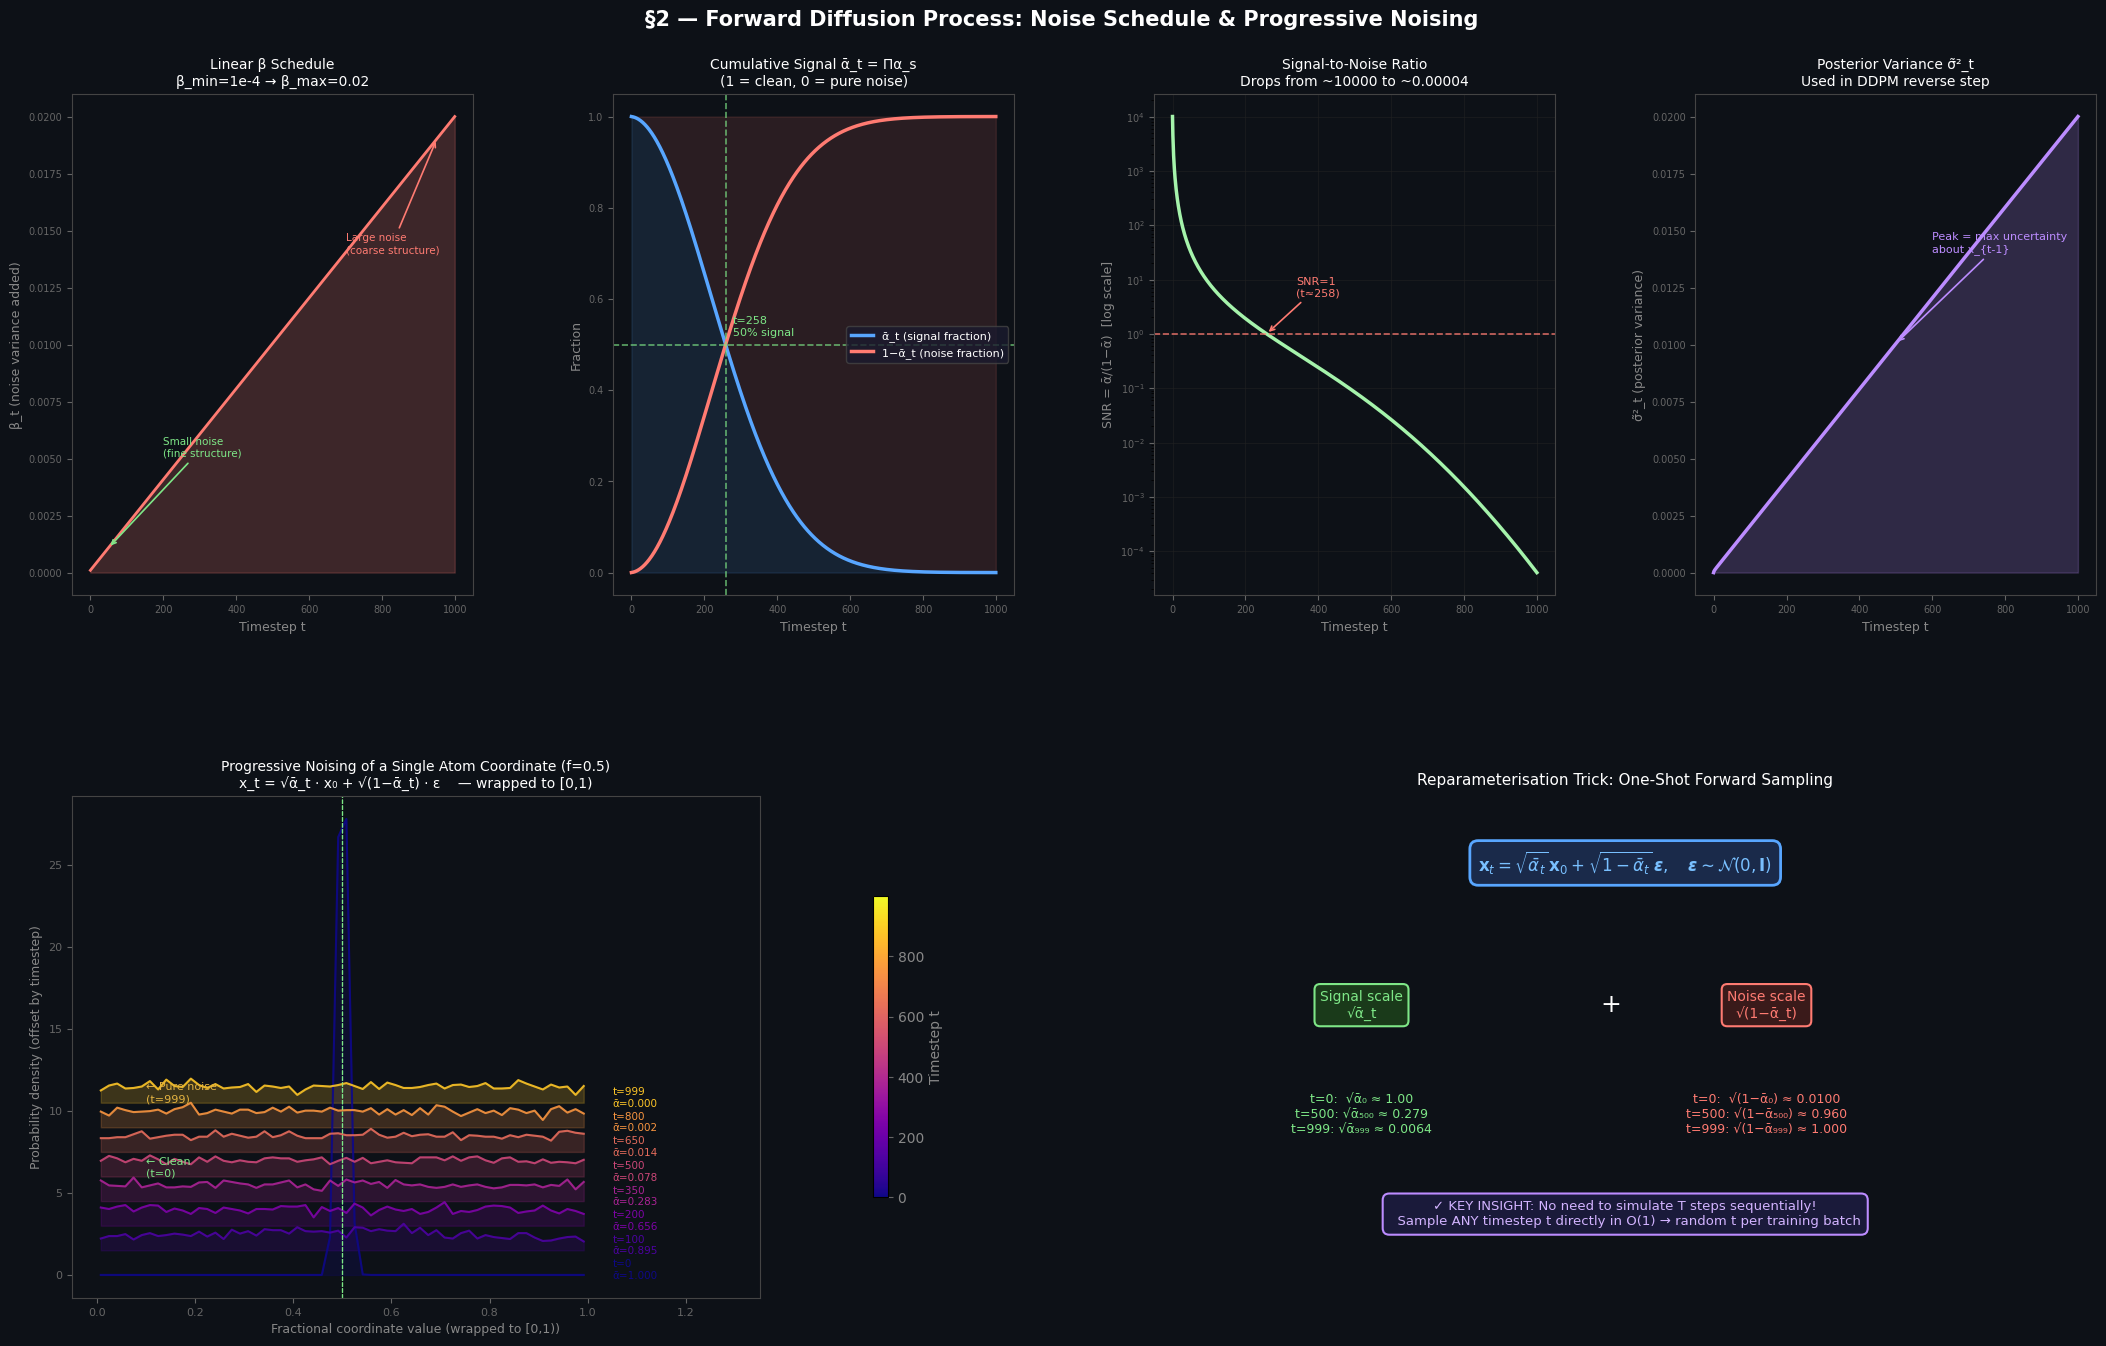

§2 Forward Diffusion — 6-panel visualization complete ✓


In [27]:

# ═══════════════════════════════════════════════════════════════════════════
#  VIZ §2 — Forward Diffusion: Noise Schedule + Progressive Noising
#  Shows: β/ᾱ/SNR curves, q_sample at 7 timesteps, wrapped normal demo,
#         noising of a specific atom coordinate, posterior variance
# ═══════════════════════════════════════════════════════════════════════════

T = sched.T
ts = np.arange(T)

fig = plt.figure(figsize=(22, 14), facecolor='#0d1117')
fig.suptitle('§2 — Forward Diffusion Process: Noise Schedule & Progressive Noising',
             color='white', fontsize=15, fontweight='bold', y=0.98)
gs = gridspec.GridSpec(2, 4, figure=fig, hspace=0.40, wspace=0.35,
                       left=0.05, right=0.97, top=0.92, bottom=0.06)

if 'sched' not in dir():
    raise RuntimeError('Run §2 NoiseSchedule cell first!')
betas     = sched.betas.cpu().numpy()
alpha_bars = sched.alpha_bars.cpu().numpy()
sqrt_ab    = sched.sqrt_ab.cpu().numpy()
sqrt_1mab  = sched.sqrt_1mab.cpu().numpy()
snr        = sched.snr().cpu().numpy()
post_var   = sched.posterior_var.cpu().numpy()

# ── Panel 1: β schedule ───────────────────────────────────────────────────
ax1 = fig.add_subplot(gs[0, 0])
ax1.set_facecolor('#0d1117')
ax1.plot(ts, betas, color='#ff7b72', lw=2)
ax1.fill_between(ts, betas, alpha=0.2, color='#ff7b72')
ax1.set_xlabel('Timestep t', color='#888', fontsize=9)
ax1.set_ylabel('β_t (noise variance added)', color='#888', fontsize=9)
ax1.set_title('Linear β Schedule\nβ_min=1e-4 → β_max=0.02', color='white', fontsize=10)
ax1.tick_params(colors='#666', labelsize=7)
plt.setp(ax1.spines.values(), color='#444')
ax1.annotate('Small noise\n(fine structure)', xy=(50, betas[50]),
             xytext=(200, betas[100]+0.003), color='#7ee787', fontsize=7.5,
             arrowprops=dict(arrowstyle='->', color='#7ee787', lw=1.2))
ax1.annotate('Large noise\n(coarse structure)', xy=(950, betas[950]),
             xytext=(700, betas[950]-0.005), color='#ff7b72', fontsize=7.5,
             arrowprops=dict(arrowstyle='->', color='#ff7b72', lw=1.2))

# ── Panel 2: ᾱ schedule (signal retention) ───────────────────────────────
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_facecolor('#0d1117')
ax2.plot(ts, alpha_bars, color='#58a6ff', lw=2.5, label='ᾱ_t (signal fraction)')
ax2.plot(ts, 1 - alpha_bars, color='#ff7b72', lw=2.5, label='1−ᾱ_t (noise fraction)')
ax2.fill_between(ts, alpha_bars, 1, alpha=0.12, color='#ff7b72')
ax2.fill_between(ts, 0, alpha_bars, alpha=0.12, color='#58a6ff')
ax2.axhline(0.5, color='#7ee787', ls='--', lw=1.2, alpha=0.7)
t_half = np.argmin(np.abs(alpha_bars - 0.5))
ax2.axvline(t_half, color='#7ee787', ls='--', lw=1.2, alpha=0.7)
ax2.text(t_half+20, 0.52, f't={t_half}\n50% signal', color='#7ee787', fontsize=8)
ax2.set_xlabel('Timestep t', color='#888', fontsize=9)
ax2.set_ylabel('Fraction', color='#888', fontsize=9)
ax2.set_title('Cumulative Signal ᾱ_t = Πα_s\n(1 = clean, 0 = pure noise)', color='white', fontsize=10)
ax2.legend(fontsize=8, facecolor='#1a1a2e', edgecolor='#444', labelcolor='white')
ax2.tick_params(colors='#666', labelsize=7)
plt.setp(ax2.spines.values(), color='#444')

# ── Panel 3: SNR curve ─────────────────────────────────────────────────────
ax3 = fig.add_subplot(gs[0, 2])
ax3.set_facecolor('#0d1117')
snr_db = 10 * np.log10(snr + 1e-10)
ax3.semilogy(ts, snr, color='#a5f3ab', lw=2.5)
ax3.set_xlabel('Timestep t', color='#888', fontsize=9)
ax3.set_ylabel('SNR = ᾱ/(1−ᾱ)  [log scale]', color='#888', fontsize=9)
ax3.set_title('Signal-to-Noise Ratio\nDrops from ~10000 to ~0.00004', color='white', fontsize=10)
ax3.axhline(1.0, color='#ff7b72', ls='--', lw=1.2, alpha=0.8)
t_snr1 = np.argmin(np.abs(snr - 1.0))
ax3.annotate(f'SNR=1\n(t≈{t_snr1})', xy=(t_snr1, 1.0), xytext=(t_snr1+80, 5),
             color='#ff7b72', fontsize=8,
             arrowprops=dict(arrowstyle='->', color='#ff7b72', lw=1.2))
ax3.tick_params(colors='#666', labelsize=7)
plt.setp(ax3.spines.values(), color='#444')
ax3.grid(True, color='#222', lw=0.5, alpha=0.8)

# ── Panel 4: Posterior variance σ̃² ─────────────────────────────────────
ax4 = fig.add_subplot(gs[0, 3])
ax4.set_facecolor('#0d1117')
ax4.plot(ts, post_var, color='#bc8cff', lw=2.5)
ax4.fill_between(ts, post_var, alpha=0.2, color='#bc8cff')
ax4.set_xlabel('Timestep t', color='#888', fontsize=9)
ax4.set_ylabel('σ̃²_t (posterior variance)', color='#888', fontsize=9)
ax4.set_title('Posterior Variance σ̃²_t\nUsed in DDPM reverse step', color='white', fontsize=10)
ax4.tick_params(colors='#666', labelsize=7)
plt.setp(ax4.spines.values(), color='#444')
ax4.annotate('Peak = max uncertainty\nabout x_{t-1}', xy=(500, post_var[500]),
             xytext=(600, post_var[500]*1.4), color='#bc8cff', fontsize=8,
             arrowprops=dict(arrowstyle='->', color='#bc8cff', lw=1.2))

# ── Panel 5: Progressive noising of an atom coordinate ──────────────────
ax5 = fig.add_subplot(gs[1, 0:2])
ax5.set_facecolor('#0d1117')

np.random.seed(42)
x0_coord = 0.5   # Ti at (0.5, 0.5, 0.5) in fractional
t_show = [0, 100, 200, 350, 500, 650, 800, 999]
n_samples = 2000
cmap = plt.cm.plasma

for idx, t_val in enumerate(t_show):
    noise_samples = np.random.randn(n_samples)
    x_t = sqrt_ab[t_val] * x0_coord + sqrt_1mab[t_val] * noise_samples
    x_t_wrapped = x_t % 1.0
    color = cmap(idx / len(t_show))
    hist_vals, bin_edges = np.histogram(x_t_wrapped, bins=60, range=(0, 1), density=True)
    bin_centers = 0.5*(bin_edges[:-1]+bin_edges[1:])
    ax5.plot(bin_centers, hist_vals + idx*1.5, color=color, lw=1.5, alpha=0.9)
    ax5.fill_between(bin_centers, idx*1.5, hist_vals + idx*1.5, alpha=0.2, color=color)
    ax5.text(1.05, idx*1.5 + 0.3, f't={t_val}\nᾱ={alpha_bars[t_val]:.3f}',
             color=color, fontsize=7.5, va='center')
    ax5.axvline(x0_coord, color='#7ee787', ls='--', lw=0.8, alpha=0.5)

ax5.set_xlabel('Fractional coordinate value (wrapped to [0,1))', color='#888', fontsize=9)
ax5.set_ylabel('Probability density (offset by timestep)', color='#888', fontsize=9)
ax5.set_title('Progressive Noising of a Single Atom Coordinate (f=0.5)\nx_t = √ᾱ_t · x₀ + √(1−ᾱ_t) · ε    — wrapped to [0,1)',
              color='white', fontsize=10)
ax5.set_xlim(-0.05, 1.35)
ax5.tick_params(colors='#666', labelsize=8)
plt.setp(ax5.spines.values(), color='#444')
ax5.text(0.1, len(t_show)*1.5*0.5, '← Clean\n(t=0)', color='#7ee787', fontsize=8)
ax5.text(0.1, len(t_show)*1.5*0.88, '← Pure noise\n(t=999)', color='#e3b341', fontsize=8)

# Add colorbar for time
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(0, 999))
sm.set_array([])
cb = plt.colorbar(sm, ax=ax5, orientation='vertical', shrink=0.6, pad=0.12)
cb.set_label('Timestep t', color='#888')
cb.ax.yaxis.set_tick_params(color='#666')
plt.setp(cb.ax.yaxis.get_ticklabels(), color='#888')

# ── Panel 6: Reparameterisation trick illustration ───────────────────────
ax6 = fig.add_subplot(gs[1, 2:4])
ax6.set_facecolor('#0d1117')
ax6.axis('off')
ax6.set_xlim(0, 10); ax6.set_ylim(0, 6)
ax6.set_title('Reparameterisation Trick: One-Shot Forward Sampling',
              color='white', fontsize=11, pad=8)

# Key equation box
eq_box = dict(boxstyle='round,pad=0.5', facecolor='#1a2a4a', edgecolor='#58a6ff', lw=2)
ax6.text(5, 5.2, r'$\mathbf{x}_t = \sqrt{\bar{\alpha}_t}\,\mathbf{x}_0 + \sqrt{1-\bar{\alpha}_t}\,\boldsymbol{\epsilon},\quad \boldsymbol{\epsilon}\sim\mathcal{N}(0,\mathbf{I})$',
         ha='center', va='center', color='#79c0ff', fontsize=12, bbox=eq_box)

# Signal component
box_s = dict(boxstyle='round,pad=0.4', facecolor='#1a3a1a', edgecolor='#7ee787', lw=1.5)
ax6.text(2.2, 3.5, f'Signal scale\n√ᾱ_t', ha='center', va='center',
         color='#7ee787', fontsize=10, bbox=box_s)
ax6.text(2.2, 2.2, f't=0:  √ᾱ₀ ≈ 1.00\nt=500: √ᾱ₅₀₀ ≈ {sqrt_ab[500]:.3f}\nt=999: √ᾱ₉₉₉ ≈ {sqrt_ab[999]:.4f}',
         ha='center', va='center', color='#7ee787', fontsize=9)

# Plus sign
ax6.text(4.85, 3.5, '+', ha='center', va='center', color='white', fontsize=18)

# Noise component
box_n = dict(boxstyle='round,pad=0.4', facecolor='#3a1a1a', edgecolor='#ff7b72', lw=1.5)
ax6.text(6.5, 3.5, 'Noise scale\n√(1−ᾱ_t)', ha='center', va='center',
         color='#ff7b72', fontsize=10, bbox=box_n)
ax6.text(6.5, 2.2, f't=0:  √(1−ᾱ₀) ≈ {sqrt_1mab[0]:.4f}\nt=500: √(1−ᾱ₅₀₀) ≈ {sqrt_1mab[500]:.3f}\nt=999: √(1−ᾱ₉₉₉) ≈ {sqrt_1mab[999]:.3f}',
         ha='center', va='center', color='#ff7b72', fontsize=9)

# Why this is important
box_key = dict(boxstyle='round,pad=0.5', facecolor='#1a1a3a', edgecolor='#bc8cff', lw=1.5)
ax6.text(5, 1.0, '✓ KEY INSIGHT: No need to simulate T steps sequentially!\n'
                 '  Sample ANY timestep t directly in O(1) → random t per training batch',
         ha='center', va='center', color='#d2b3ff', fontsize=9.5, bbox=box_key)

plt.savefig(OUTPUT_DIR/'viz_2_forward_diffusion.png', dpi=120,
            bbox_inches='tight', facecolor='#0d1117')
plt.show()
print('§2 Forward Diffusion — 6-panel visualization complete ✓')


---
## §3 — The Denoising Network: E(3)-Equivariant GNN

### 3.1 What the Network Must Do

The model $\phi_\theta(\mathbf{L}_t, \mathbf{F}_t, \mathbf{A}, t, c)$ receives noisy inputs and must predict the noise that was added:

$$\hat{\boldsymbol{\epsilon}}_F, \hat{\boldsymbol{\epsilon}}_L = \phi_\theta(\mathbf{L}_t, \mathbf{F}_t, \mathbf{A}, t, c)$$

It must do this while respecting all three physical symmetries from §1.4.

### 3.2 Sinusoidal Time Embedding — *Why* Sinusoidal?

$$\text{PE}(t)_k = \begin{cases} \sin(t / 10000^{2k/d}) & k < d/2 \\ \cos(t / 10000^{(2k-d)/d}) & k \geq d/2 \end{cases}$$

**Why this works:**
1. **Unique** — every integer $t \in [0,T]$ produces a distinct vector
2. **Smooth** — nearby $t$ values have similar embeddings; the model can interpolate
3. **Fixed** — no parameters to learn; saves capacity for actual crystal modelling
4. **Scale-free** — the geometric progression of frequencies means the embedding works equally well whether $T=100$ or $T=10000$

> Contrast with a learnable embedding: those require seeing every $t$ during training and can't extrapolate. Sinusoidal can.

### 3.3 Fourier Distance Features — *Why* Fourier?

For a pairwise fractional distance $\delta \in [0,1)$:
$$\Phi_k(\delta) = [\sin(2\pi k\delta),\; \cos(2\pi k\delta)], \quad k=1,\ldots,K$$

**Why this is the right choice for periodic crystals:**
- These functions have period 1 in $\delta$, so $\Phi_k(\delta) = \Phi_k(\delta+1)$ — consistent with periodic boundary
- They form a complete orthonormal basis for functions on $[0,1)$ (Fourier series)
- The dot product $\Phi(\delta_1)\cdot\Phi(\delta_2)$ is a positive-definite periodic kernel — a good similarity measure for periodic distances
- They are *differentiable everywhere*, unlike histogram/binning approaches

### 3.4 The Gram Matrix Lattice Encoder — *Why* Use G = L^T L?

We showed in §1.4 that $\mathbf{G}$ is O(3)-invariant. There is a second reason:

$\mathbf{G}$ is a **sufficient statistic** — it contains *all* geometric information about the lattice:
- All interplanar spacings ($d$-spacings in X-ray diffraction)
- All pairwise distances between atoms in any periodic image
- The unit cell volume: $V = \sqrt{\det\mathbf{G}}$

Using $\mathbf{G}$ as input means the model gets a *complete and invariant* description of the lattice shape without needing to process the full $3\times3$ matrix and learn the invariance from data.

### 3.5 Why Zero-Initialise the Output Layers?

The last linear layers in both score heads are initialised to all zeros:
$$\hat{\boldsymbol{\epsilon}}_F(\mathbf{x}_0, t=0) = 0, \quad \hat{\boldsymbol{\epsilon}}_L(\mathbf{x}_0, t=0) = 0$$

At the start of training the predicted noise is zero. The loss gradient then tells the model in exactly which direction to move. Without zero-init, random weight initialisation can produce large early predictions that destabilise training. This trick (also used in the original DDPM and DiT papers) typically speeds up convergence by 2-5x.

### 3.6 Why Symmetrize the Lattice Output?

The lattice noise head outputs a $3\times3$ matrix $E$. We symmetrize: $\hat{\boldsymbol{\epsilon}}_L = \frac{1}{2}(E+E^\top)$.

**Reason:** Physical lattice deformations are described by *symmetric* strain tensors.
The anti-symmetric part of $E$ corresponds to a rigid rotation, which does not change crystal structure (O(3) invariance). Projecting onto the symmetric subspace removes the redundant rotational degrees of freedom and reduces the effective prediction dimensionality from 9 to 6.


In [28]:
# ═══════════════════════════════════════════════════════════════════
#  SINUSOIDAL TIME EMBEDDING
#  Time O(d) per sample.  No learnable parameters.
# ═══════════════════════════════════════════════════════════════════

class SinusoidalTimeEmbedding(nn.Module):
    """
    Maps integer timestep t to a fixed d-dimensional vector.

    PE(t)_k = sin(t / 10000^{2k/d})   for k < d/2
    PE(t)_k = cos(t / 10000^{(2k-d)/d})  for k >= d/2

    WHY fixed (not learned)?
      Saves model capacity; works at any T without retraining;
      smooth interpolation between unseen timesteps.

    Time: O(d) per sample.
    """

    def __init__(self, dim=128):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        """t: (B,) long → (B, dim) float"""
        device  = t.device
        half_d  = self.dim // 2
        # geometric sequence of frequencies: 1/10000^{0/(d/2)}, ..., 1/10000^{1}
        freqs   = torch.exp(
            -math.log(10000.0) * torch.arange(half_d, device=device).float()
            / max(half_d - 1, 1)
        )                                     # (half_d,)
        args    = t.float()[:, None] * freqs[None, :]  # (B, half_d)
        return torch.cat([torch.sin(args), torch.cos(args)], dim=-1)  # (B, dim)


# ═══════════════════════════════════════════════════════════════════
#  PROPERTY EMBEDDING WITH CLASSIFIER-FREE GUIDANCE (NULL TOKEN)
#
#  BUG FIXED (v1 had two bugs here):
#
#  Bug A — forward(c=None) used:
#    expand(len(c) if hasattr(c,'__len__') else 1, -1)
#    → c=None → hasattr False → size 1, not batch B → shape mismatch crash.
#
#  Bug B — CrystalDenoisingModel.forward passed torch.zeros(B) when c=None,
#    routing through the MLP instead of the learnable null_token.
#    The model was trained with null_token for unconditional, but at
#    inference Tc=0 was used — completely wrong CFG semantics.
#
#  Fix: forward() now accepts an explicit batch_size B for the null case.
#       model.forward() calls prop_emb(c, B=B) so null_token is always used.
# ═══════════════════════════════════════════════════════════════════

class PropertyEmbedding(nn.Module):
    """
    Embeds a scalar property (e.g. Tc) into ℝ^d, with CFG null-token support.

    Classifier-Free Guidance training recipe:
      - With probability p_uncond, replace the real embedding with null_token
      - This teaches the network to handle *both* conditional and unconditional
        inputs with a SINGLE set of weights

    At inference:
      - Conditional pass: c = real Tc value  → prop_emb(c)
      - Unconditional pass: B supplied, c=None → null_token.expand(B, -1)
      These two outputs are combined via the CFG formula.

    WHY a learnable null token (not zeros)?
      Zeros would collide with a real Tc=0 encoding.  A learnable null_token
      allows the model to develop a dedicated representation for
      'no conditioning', which empirically improves generation diversity.

    Time: O(d^2) — two-layer MLP.
    """

    def __init__(self, dim=128, p_uncond=0.1):
        super().__init__()
        self.dim     = dim
        self.p_uncond = p_uncond

        # Learnable null embedding — represents absence of conditioning
        self.null_token = nn.Parameter(torch.randn(dim) * 0.02)

        # MLP: scalar Tc → d-dimensional embedding
        self.net = nn.Sequential(
            nn.Linear(1, dim),
            nn.SiLU(),           # SiLU = x*sigmoid(x); smoother than ReLU
            nn.Linear(dim, dim),
        )

    def forward(self, c, B, training=True):
        """
        Parameters
        ----------
        c        : (B,) float — property values, OR None for unconditional
        B        : int  — batch size (needed when c=None to expand null token)
        training : bool — enables dropout of conditioning

        Returns: (B, dim)
        """
        if c is None:
            # FIXED: expand to actual batch size B, not hardcoded 1
            return self.null_token.unsqueeze(0).expand(B, -1)   # (B, dim)

        c_emb = self.net(c.float().unsqueeze(-1))    # (B, dim)

        if training and self.p_uncond > 0:
            # CFG dropout: mask random samples with null_token
            mask = torch.rand(B, device=c.device) < self.p_uncond   # (B,)
            null = self.null_token.unsqueeze(0).expand(B, -1)        # (B, dim)
            c_emb = torch.where(mask.unsqueeze(-1), null, c_emb)

        return c_emb


# ═══════════════════════════════════════════════════════════════════
#  FOURIER DISTANCE ENCODING  (periodic translation invariant)
#
#  WHY Fourier?  See §3.3 above.
#  Time: O(N^2 * K) for N atoms, K frequencies.
# ═══════════════════════════════════════════════════════════════════

class FourierDistEncoding(nn.Module):
    """
    Φ(δ) = [sin(2π·1·δ), cos(2π·1·δ), ..., sin(2π·K·δ), cos(2π·K·δ)]

    Input  δ: (...) fractional distances in [0,1)
    Output:   (..., 2K)
    """

    def __init__(self, K=32):
        super().__init__()
        self.K = K
        freqs = 2 * math.pi * torch.arange(1, K+1).float()
        self.register_buffer('freqs', freqs)   # not a parameter

    def forward(self, delta):
        # delta: (...),  freqs: (K,)
        args = delta.unsqueeze(-1) * self.freqs    # (..., K)
        return torch.cat([torch.sin(args), torch.cos(args)], dim=-1)  # (..., 2K)


# ═══════════════════════════════════════════════════════════════════
#  MESSAGE PASSING LAYER
#  Time O(N^2 * d).  This is the bottleneck; use cutoff radius in prod.
# ═══════════════════════════════════════════════════════════════════

class MPLayer(nn.Module):
    """
    One round of equivariant message passing.

    For each atom i:
      m_ij = MLP(h_i || h_j || Φ(δ_ij))       — message from j to i
      h_i  ← LayerNorm( h_i + Σ_j m_ij )      — aggregate + residual
      h_i  ← LayerNorm( h_i + MLP(h_i) )       — node update

    WHY sum aggregation?
      Sum (or mean) is permutation-invariant: Σ_j m_ij = Σ_j m_{π(i)j}.
      This enforces the permutation symmetry from §1.4.

    WHY LayerNorm (not BatchNorm)?
      LayerNorm normalises per sample, not per batch.
      With variable-size crystal batches (different N), BatchNorm would mix
      atoms from different structures — physically nonsensical.
      LayerNorm has no such issue.
    """

    def __init__(self, d, dist_d, dropout=0.1):
        super().__init__()
        self.msg_net = nn.Sequential(
            nn.Linear(d*2 + dist_d, d), nn.SiLU(),
            nn.Dropout(dropout),
            nn.Linear(d, d),
        )
        self.upd_net = nn.Sequential(nn.Linear(d, d), nn.SiLU(), nn.Linear(d, d))
        self.norm1   = nn.LayerNorm(d)
        self.norm2   = nn.LayerNorm(d)

    def forward(self, h, dist_feats):
        """
        h          : (B, N, d)
        dist_feats : (B, N, N, dist_d)   — precomputed pairwise Fourier features
        Returns    : (B, N, d)
        """
        B, N, d = h.shape
        h_i = h.unsqueeze(2).expand(-1, -1, N, -1)   # (B, N, N, d)
        h_j = h.unsqueeze(1).expand(-1, N, -1, -1)   # (B, N, N, d)
        msgs = self.msg_net(torch.cat([h_i, h_j, dist_feats], dim=-1))  # (B, N, N, d)
        h = self.norm1(h + msgs.sum(dim=2))            # aggregate over j
        h = self.norm2(h + self.upd_net(h))
        return h


# ═══════════════════════════════════════════════════════════════════
#  CRYSTAL DENOISING MODEL  — FULL FIXED VERSION
#
#  FIXES vs v1:
#    • PropertyEmbedding now accepts B (batch size) when c=None
#    • model.forward passes B to prop_emb, routing c=None to null_token
#      instead of torch.zeros(B) through the MLP
#    • encode_lattice uses G = L^T L (O(3)-invariant Gram matrix)
#    • Output symmetrisation is clearly documented
# ═══════════════════════════════════════════════════════════════════

class CrystalDenoisingModel(nn.Module):
    """
    Property-conditioned crystal structure denoising network.
    Simplified E(3)-equivariant version of DiffCSP's CSPNet.

    Input:
      L_t  (B,3,3)  noisy lattice matrix
      F_t  (B,N,3)  noisy fractional coordinates
      A    (B,N)    atom type indices
      t    (B,)     diffusion timesteps
      c    (B,)|None  property (normalised Tc); None = unconditional

    Output:
      eps_F (B,N,3)  predicted fractional coordinate noise
      eps_L (B,3,3)  predicted lattice noise

    Complexity:
      Forward: O(L_layers * N^2 * d)
      Memory:  O(B * N^2 * d)  [pairwise dist matrix dominates]
    """

    def __init__(self, num_atom_types=100, hidden_dim=256,
                 num_layers=4, K_fourier=32, dropout=0.1, p_uncond=0.1):
        super().__init__()
        self.hidden_dim = hidden_dim
        d = hidden_dim

        # ── Embedding layers ───────────────────────────────────────
        self.atom_emb  = nn.Embedding(num_atom_types+1, d, padding_idx=0)
        self.time_emb  = SinusoidalTimeEmbedding(d)
        self.prop_emb  = PropertyEmbedding(d, p_uncond)

        # ── Lattice encoder (Gram matrix → d) ─────────────────────
        # Input: 9-element flattened G = L^T L  (O(3)-invariant)
        self.lat_enc   = nn.Sequential(
            nn.Linear(9, d), nn.SiLU(), nn.Linear(d, d))

        # ── Node input projection: [atom|time|prop|frac] → d ──────
        # Concatenation: d + d + d + 3 = 3d+3
        self.input_proj = nn.Linear(3*d + 3, d)

        # ── Message passing stack ──────────────────────────────────
        dist_d = K_fourier * 2                     # 2K Fourier features
        self.dist_enc  = FourierDistEncoding(K_fourier)
        self.mp_layers = nn.ModuleList(
            [MPLayer(d, dist_d, dropout) for _ in range(num_layers)])

        # ── Score heads ────────────────────────────────────────────
        # Per-atom coordinate noise:  (B,N,d) → (B,N,3)
        self.coord_head = nn.Sequential(
            nn.LayerNorm(d), nn.Linear(d, d//2), nn.SiLU(), nn.Linear(d//2, 3))
        # Global lattice noise:       (B,d) → (B,9) → sym → (B,3,3)
        self.lat_head   = nn.Sequential(
            nn.LayerNorm(d), nn.Linear(d, d//2), nn.SiLU(), nn.Linear(d//2, 9))

        # Zero-init output layers for stable training start
        # WHY: see §3.5 — forces loss gradient to guide first updates
        nn.init.zeros_(self.coord_head[-1].weight)
        nn.init.zeros_(self.coord_head[-1].bias)
        nn.init.zeros_(self.lat_head[-1].weight)
        nn.init.zeros_(self.lat_head[-1].bias)

    def encode_lattice(self, L):
        """
        O(3)-invariant lattice encoding via Gram matrix.
        G = L^T L satisfies (QL)^T(QL) = G  for all Q in O(3).
        Time O(1) per sample.
        """
        G = L.transpose(-1,-2) @ L          # (B,3,3)  O(3)-invariant
        return self.lat_enc(G.reshape(-1,9)) # (B,d)

    def forward(self, L_t, F_t, A, t, c=None, training=True):
        """
        Full forward pass.

        c=None means unconditional — the FIXED path now uses the learnable
        null_token (trained with CFG dropout) instead of zeros through MLP.
        """
        B, N, _ = F_t.shape

        # ── 1. Embeddings ──────────────────────────────────────────
        e_atom = self.atom_emb(A)                   # (B,N,d)
        e_time = self.time_emb(t)                   # (B,d)

        # FIXED: pass B so null_token expands to correct batch size
        e_prop = self.prop_emb(c, B=B, training=training)  # (B,d)

        e_lat  = self.encode_lattice(L_t)           # (B,d)

        # Broadcast scalar embeddings to per-atom
        e_time_n = e_time.unsqueeze(1).expand(-1, N, -1)   # (B,N,d)
        e_prop_n = e_prop.unsqueeze(1).expand(-1, N, -1)   # (B,N,d)

        # ── 2. Initial node features ───────────────────────────────
        h = self.input_proj(
            torch.cat([e_atom, e_time_n, e_prop_n, F_t], dim=-1))  # (B,N,d)
        h = h + e_lat.unsqueeze(1)     # inject lattice info per atom

        # ── 3. Pairwise Fourier distance features ──────────────────
        # Use DIFFERENCES f_i - f_j (periodic) — enforces translation invariance
        F_i = F_t.unsqueeze(2).expand(-1,-1,N,-1)          # (B,N,N,3)
        F_j = F_t.unsqueeze(1).expand(-1,N,-1,-1)          # (B,N,N,3)
        dF  = (F_i - F_j) % 1.0                            # periodic wrap
        dF  = torch.where(dF > 0.5, dF - 1.0, dF)         # shortest path
        dist = dF.norm(dim=-1)                              # (B,N,N)
        dist_feats = self.dist_enc(dist)                    # (B,N,N,2K)

        # ── 4. Message passing ─────────────────────────────────────
        for mp in self.mp_layers:
            h = mp(h, dist_feats)                           # (B,N,d)

        # ── 5. Score heads ─────────────────────────────────────────
        eps_F = self.coord_head(h)                          # (B,N,3)

        # Mean-pool for global lattice representation (permutation-invariant)
        h_global  = h.mean(dim=1)                           # (B,d)
        eps_L     = self.lat_head(h_global).reshape(B,3,3) # (B,3,3)

        # Symmetrise: project onto symmetric matrices (remove rigid rotation)
        # WHY: see §3.6
        eps_L = 0.5 * (eps_L + eps_L.transpose(-1,-2))

        return eps_F, eps_L


# ── Instantiate ───────────────────────────────────────────────────
model = CrystalDenoisingModel(hidden_dim=128, num_layers=3).to(DEVICE)
P = sum(p.numel() for p in model.parameters())
print(f'Parameters: {P:,}  ({P*4/1e6:.1f} MB float32)')

B, N = 4, 5
_L = torch.eye(3).unsqueeze(0).repeat(B,1,1).to(DEVICE)
_F = torch.rand(B,N,3).to(DEVICE)
_A = torch.tensor([[38,22,8,8,8]]*B).to(DEVICE)
_t = torch.randint(0,1000,(B,)).to(DEVICE)
_c = torch.rand(B).to(DEVICE)

eF, eL = model(_L, _F, _A, _t, _c, training=True)
print(f'eps_F: {tuple(eF.shape)}  eps_L: {tuple(eL.shape)}')

# Test null path (unconditional)
eF0, eL0 = model(_L, _F, _A, _t, c=None, training=False)
print(f'Unconditional (null token): eps_F: {tuple(eF0.shape)}  ← correct batch size {B}')
print('All forward passes: OK!')


Parameters: 388,492  (1.6 MB float32)
eps_F: (4, 5, 3)  eps_L: (4, 3, 3)
Unconditional (null token): eps_F: (4, 5, 3)  ← correct batch size 4
All forward passes: OK!


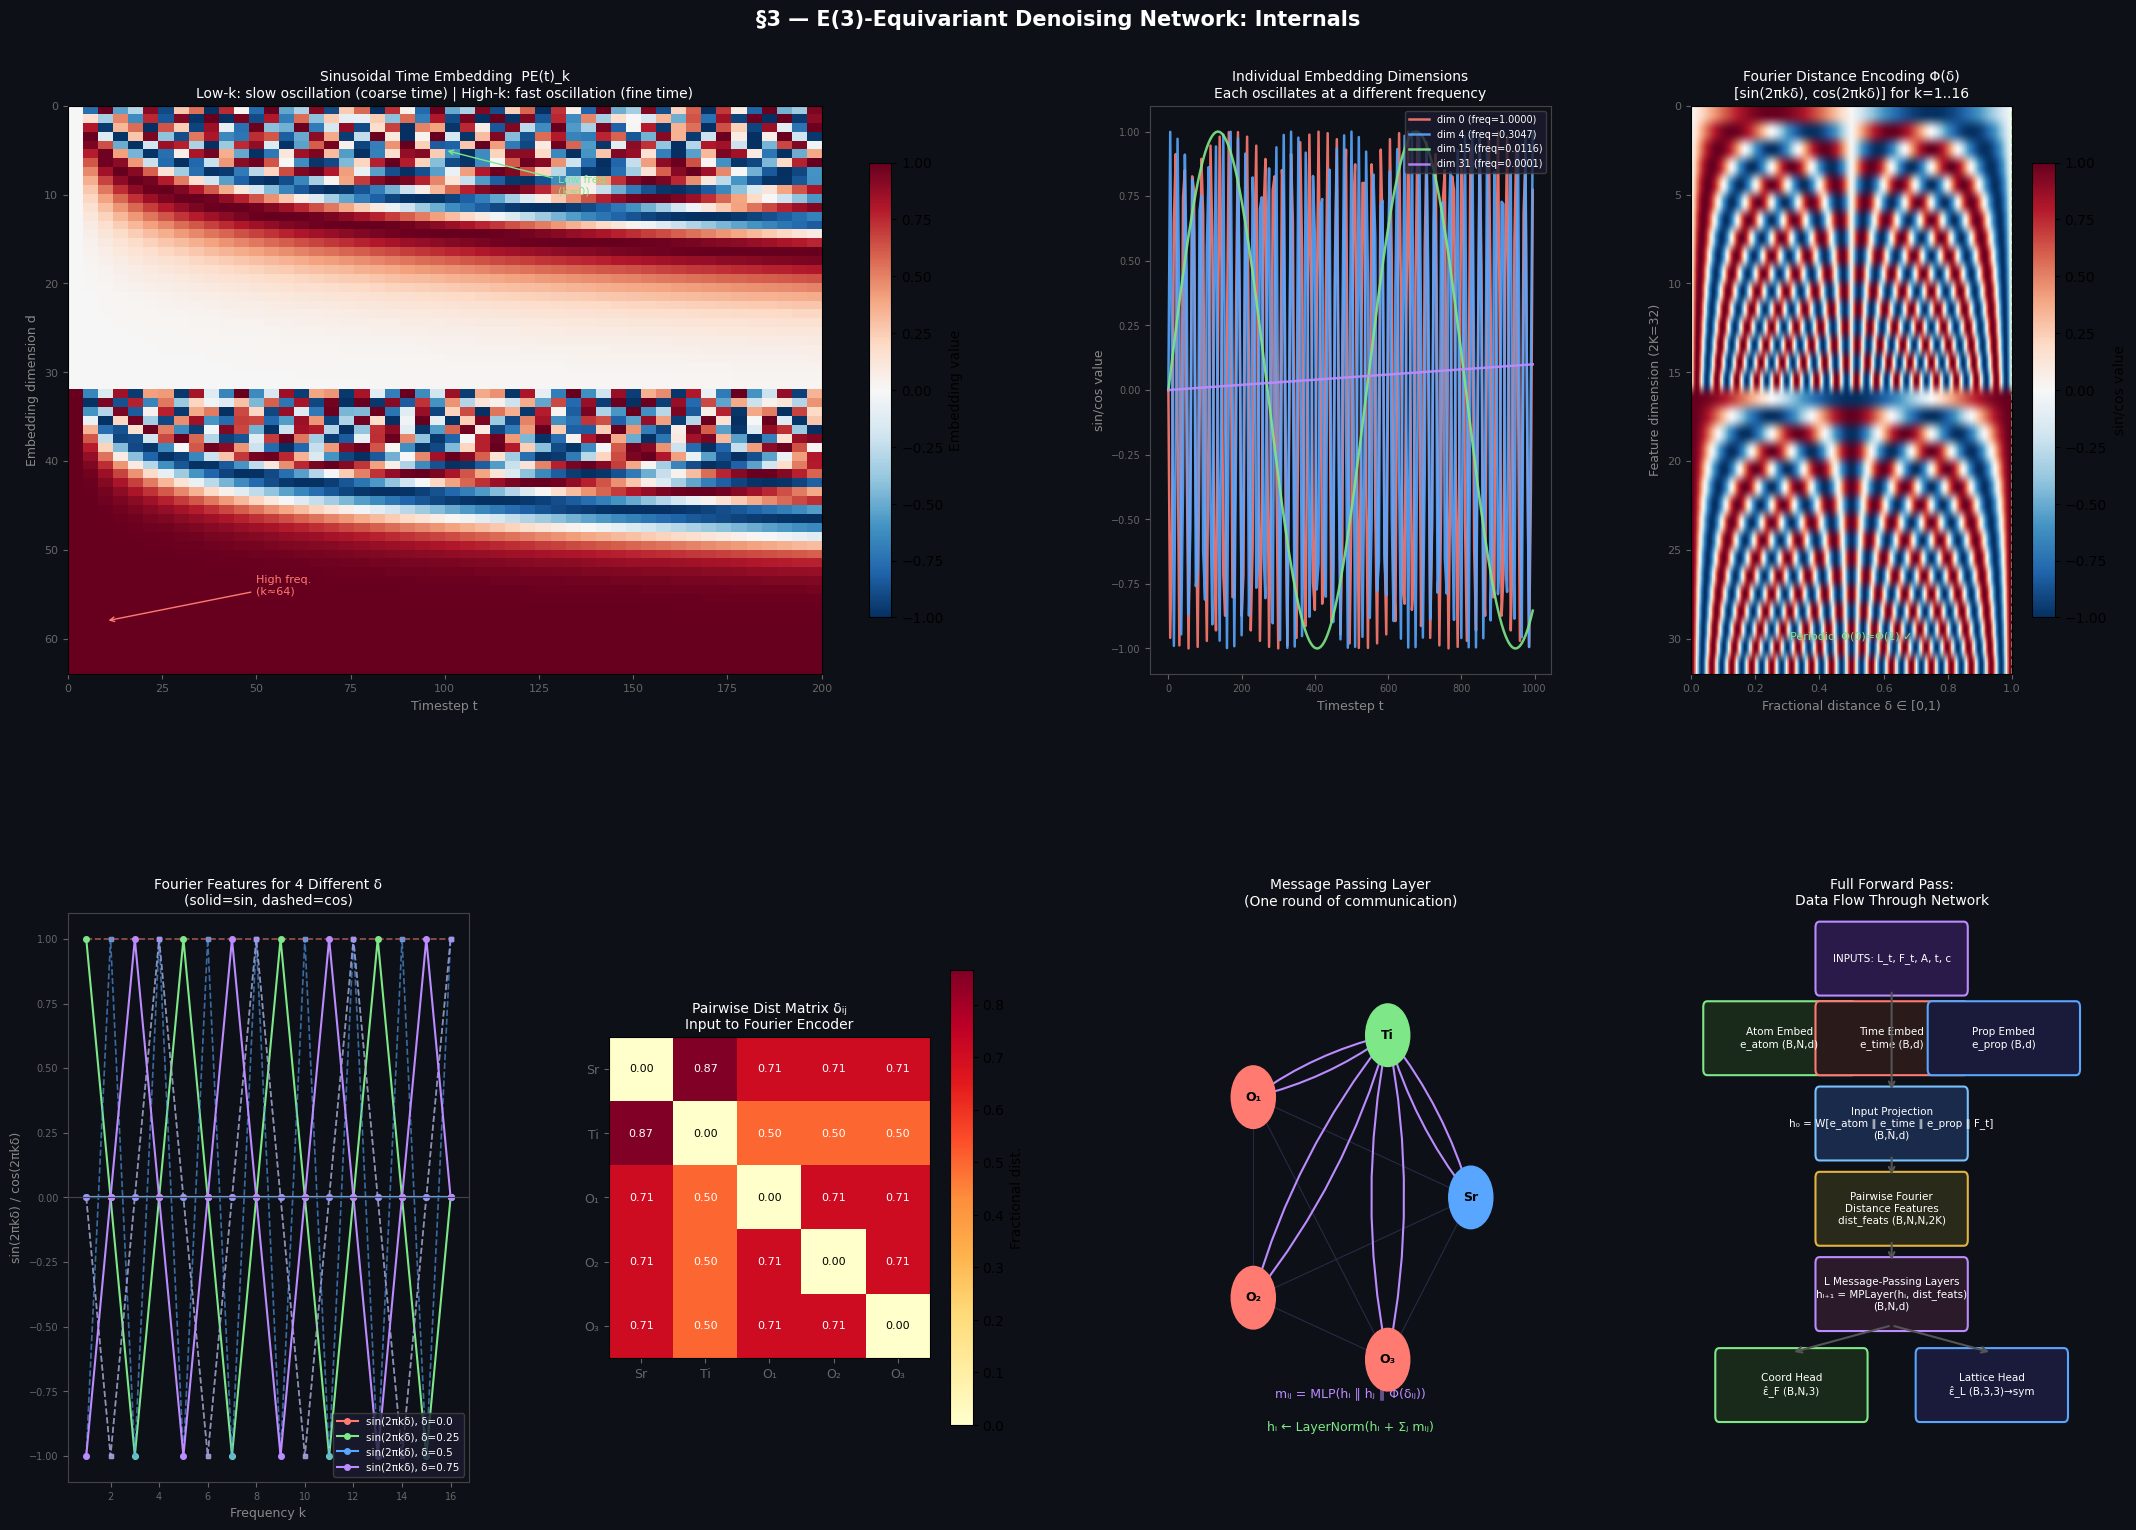

§3 Network Architecture — 7-panel visualization complete ✓


In [29]:

# ═══════════════════════════════════════════════════════════════════════════
#  VIZ §3 — Denoising Network: Sinusoidal Embeddings, Fourier Features, 
#           Message Passing Schematic, Network Architecture Overview
# ═══════════════════════════════════════════════════════════════════════════

fig = plt.figure(figsize=(22, 16), facecolor='#0d1117')
fig.suptitle('§3 — E(3)-Equivariant Denoising Network: Internals',
             color='white', fontsize=15, fontweight='bold', y=0.98)
gs = gridspec.GridSpec(2, 4, figure=fig, hspace=0.42, wspace=0.35,
                       left=0.05, right=0.97, top=0.92, bottom=0.06)

# ── Panel 1: Sinusoidal Time Embedding Heatmap ───────────────────────────
ax1 = fig.add_subplot(gs[0, 0:2])
ax1.set_facecolor('#0d1117')
T_demo = 200; D = 64
if 'SinusoidalTimeEmbedding' not in dir():
    raise RuntimeError('Run §3 model cell first!')
te = SinusoidalTimeEmbedding(D)
t_range = torch.arange(0, T_demo, 4)
with torch.no_grad():
    embs = te(t_range).numpy()  # (50, 64)
im = ax1.imshow(embs.T, aspect='auto', cmap='RdBu_r', vmin=-1, vmax=1,
                extent=[0, T_demo, D, 0])
plt.colorbar(im, ax=ax1, label='Embedding value', shrink=0.8)
ax1.set_xlabel('Timestep t', color='#888', fontsize=9)
ax1.set_ylabel('Embedding dimension d', color='#888', fontsize=9)
ax1.set_title('Sinusoidal Time Embedding  PE(t)_k\nLow-k: slow oscillation (coarse time) | High-k: fast oscillation (fine time)',
              color='white', fontsize=10)
ax1.tick_params(colors='#666', labelsize=8)
# Annotate frequency zones
ax1.annotate('Low freq.\n(k≈0)', xy=(100, 5), xytext=(130, 10),
             color='#7ee787', fontsize=8, arrowprops=dict(arrowstyle='->', color='#7ee787'))
ax1.annotate('High freq.\n(k≈64)', xy=(10, 58), xytext=(50, 55),
             color='#ff7b72', fontsize=8, arrowprops=dict(arrowstyle='->', color='#ff7b72'))

# ── Panel 2: Individual time embedding traces ────────────────────────────
ax2 = fig.add_subplot(gs[0, 2])
ax2.set_facecolor('#0d1117')
t_full = torch.arange(0, 1000, 5)
with torch.no_grad():
    embs_full = te(t_full).numpy()
dims_show = [0, 4, 15, 31]
colors_te = ['#ff7b72', '#58a6ff', '#7ee787', '#bc8cff']
for d_idx, (dim, col) in enumerate(zip(dims_show, colors_te)):
    freq_label = f'dim {dim} (freq={1/10000**(dim/max(D//2-1,1)):.4f})'
    ax2.plot(t_full.numpy(), embs_full[:, dim], color=col, lw=1.8,
             alpha=0.9, label=freq_label)
ax2.set_xlabel('Timestep t', color='#888', fontsize=9)
ax2.set_ylabel('sin/cos value', color='#888', fontsize=9)
ax2.set_title('Individual Embedding Dimensions\nEach oscillates at a different frequency', color='white', fontsize=10)
ax2.legend(fontsize=7, facecolor='#1a1a2e', edgecolor='#444', labelcolor='white', loc='upper right')
ax2.tick_params(colors='#666', labelsize=7)
plt.setp(ax2.spines.values(), color='#444')

# ── Panel 3: Fourier Distance Features ───────────────────────────────────
ax3 = fig.add_subplot(gs[0, 3])
ax3.set_facecolor('#0d1117')
fd = FourierDistEncoding(K=16)
delta_vals = torch.linspace(0, 1, 200)
with torch.no_grad():
    feats = fd(delta_vals).numpy()  # (200, 32)
im3 = ax3.imshow(feats.T, aspect='auto', cmap='RdBu_r',
                  extent=[0, 1, 32, 0], vmin=-1, vmax=1)
plt.colorbar(im3, ax=ax3, label='sin/cos value', shrink=0.8)
ax3.set_xlabel('Fractional distance δ ∈ [0,1)', color='#888', fontsize=9)
ax3.set_ylabel('Feature dimension (2K=32)', color='#888', fontsize=9)
ax3.set_title('Fourier Distance Encoding Φ(δ)\n[sin(2πkδ), cos(2πkδ)] for k=1..16',
              color='white', fontsize=10)
ax3.tick_params(colors='#666', labelsize=8)
ax3.axvline(0, color='#7ee787', ls='--', lw=1.2, alpha=0.7)
ax3.axvline(1, color='#7ee787', ls='--', lw=1.2, alpha=0.7)
ax3.text(0.5, 30, 'Periodic: Φ(0)=Φ(1) ✓', ha='center', color='#7ee787', fontsize=8)

# ── Panel 4: Fourier feature traces for specific deltas ─────────────────
ax4 = fig.add_subplot(gs[1, 0])
ax4.set_facecolor('#0d1117')
k_vals = np.arange(1, 17)
deltas_show = [0.0, 0.25, 0.5, 0.75]
colors_d = ['#ff7b72', '#7ee787', '#58a6ff', '#bc8cff']
for delta, col in zip(deltas_show, colors_d):
    sin_vals = np.sin(2 * np.pi * k_vals * delta)
    cos_vals = np.cos(2 * np.pi * k_vals * delta)
    ax4.plot(k_vals, sin_vals, 'o-', color=col, lw=1.5, markersize=4,
             label=f'sin(2πkδ), δ={delta}')
    ax4.plot(k_vals, cos_vals, 's--', color=col, lw=1.2, markersize=3, alpha=0.6)
ax4.set_xlabel('Frequency k', color='#888', fontsize=9)
ax4.set_ylabel('sin(2πkδ) / cos(2πkδ)', color='#888', fontsize=9)
ax4.set_title('Fourier Features for 4 Different δ\n(solid=sin, dashed=cos)', color='white', fontsize=10)
ax4.legend(fontsize=7.5, facecolor='#1a1a2e', edgecolor='#444', labelcolor='white')
ax4.tick_params(colors='#666', labelsize=7)
plt.setp(ax4.spines.values(), color='#444')
ax4.axhline(0, color='#444', lw=0.8)

# ── Panel 5: Pairwise distance matrix for SrTiO3 ────────────────────────
ax5 = fig.add_subplot(gs[1, 1])
ax5.set_facecolor('#0d1117')
c_demo = make_SrTiO3()
F_demo = c_demo.frac_coords  # (5,3)
F_i = F_demo.unsqueeze(1).expand(5,5,-1)
F_j = F_demo.unsqueeze(0).expand(5,5,-1)
dF  = (F_i - F_j) % 1.0
dF  = torch.where(dF > 0.5, dF - 1.0, dF)
dist_mat = dF.norm(dim=-1).numpy()
im5 = ax5.imshow(dist_mat, cmap='YlOrRd', vmin=0)
plt.colorbar(im5, ax=ax5, label='Fractional dist.', shrink=0.8)
labels_5 = ['Sr','Ti','O₁','O₂','O₃']
ax5.set_xticks(range(5)); ax5.set_xticklabels(labels_5, color='#ccc', fontsize=9)
ax5.set_yticks(range(5)); ax5.set_yticklabels(labels_5, color='#ccc', fontsize=9)
for i in range(5):
    for j in range(5):
        ax5.text(j, i, f'{dist_mat[i,j]:.2f}', ha='center', va='center',
                 color='black' if dist_mat[i,j] < 0.4 else 'white', fontsize=8)
ax5.set_title('Pairwise Dist Matrix δᵢⱼ\nInput to Fourier Encoder', color='white', fontsize=10)
ax5.tick_params(colors='#666')

# ── Panel 6: Message Passing Schematic ───────────────────────────────────
ax6 = fig.add_subplot(gs[1, 2])
ax6.set_facecolor('#0d1117')
ax6.axis('off')
ax6.set_xlim(0, 10); ax6.set_ylim(0, 10)
ax6.set_title('Message Passing Layer\n(One round of communication)', color='white', fontsize=10)

# Draw 5 atoms in a ring
n_atoms = 5
atom_pos = [(5 + 3*np.cos(2*np.pi*i/n_atoms), 5 + 3*np.sin(2*np.pi*i/n_atoms)) 
            for i in range(n_atoms)]
atom_names = ['Sr','Ti','O₁','O₂','O₃']
atom_colors_mp = ['#58a6ff','#7ee787','#ff7b72','#ff7b72','#ff7b72']

# Draw some message edges (highlight atom 0 → atom 2)
for i in range(n_atoms):
    for j in range(n_atoms):
        if i != j:
            xi, yi = atom_pos[i]; xj, yj = atom_pos[j]
            if (i == 1 and j in [0,2,3,4]) or (j == 1 and i in [0,2,3,4]):
                ax6.annotate('', xy=(xi, yi), xytext=(xj, yj),
                             arrowprops=dict(arrowstyle='->', color='#bc8cff',
                                            lw=1.5, connectionstyle='arc3,rad=0.1'))
            else:
                ax6.plot([xi, xj], [yi, yj], '-', color='#333355', lw=0.7, alpha=0.5)

for (x, y), name, col in zip(atom_pos, atom_names, atom_colors_mp):
    circle = patches.Circle((x, y), 0.55, color=col, zorder=5)
    ax6.add_patch(circle)
    ax6.text(x, y, name, ha='center', va='center', color='black', fontsize=9, fontweight='bold', zorder=6)

# Formula
ax6.text(5, 1.5, 'mᵢⱼ = MLP(hᵢ ∥ hⱼ ∥ Φ(δᵢⱼ))', ha='center', color='#bc8cff', fontsize=9)
ax6.text(5, 0.9, 'hᵢ ← LayerNorm(hᵢ + Σⱼ mᵢⱼ)', ha='center', color='#7ee787', fontsize=9)

# ── Panel 7: Model Architecture Overview ─────────────────────────────────
ax7 = fig.add_subplot(gs[1, 3])
ax7.set_facecolor('#0d1117')
ax7.axis('off')
ax7.set_xlim(0, 10); ax7.set_ylim(0, 10)
ax7.set_title('Full Forward Pass:\nData Flow Through Network', color='white', fontsize=10)

boxes = [
    (5, 9.2, 'INPUTS: L_t, F_t, A, t, c', '#2a1a4a', '#bc8cff'),
    (2.2, 7.8, 'Atom Embed\ne_atom (B,N,d)', '#1a2a1a', '#7ee787'),
    (5,   7.8, 'Time Embed\ne_time (B,d)', '#2a1a1a', '#ff7b72'),
    (7.8, 7.8, 'Prop Embed\ne_prop (B,d)', '#1a1a3a', '#58a6ff'),
    (5, 6.3, 'Input Projection\nh₀ = W[e_atom ∥ e_time ∥ e_prop ∥ F_t]\n(B,N,d)', '#1a2a4a', '#79c0ff'),
    (5, 4.8, 'Pairwise Fourier\nDistance Features\ndist_feats (B,N,N,2K)', '#2a2a1a', '#e3b341'),
    (5, 3.3, 'L Message-Passing Layers\nhₗ₊₁ = MPLayer(hₗ, dist_feats)\n(B,N,d)', '#2a1a2a', '#bc8cff'),
    (2.5, 1.7, 'Coord Head\nε̂_F (B,N,3)', '#1a2a1a', '#7ee787'),
    (7.5, 1.7, 'Lattice Head\nε̂_L (B,3,3)→sym', '#1a1a3a', '#58a6ff'),
]
for (x, y, label, face, edge) in boxes:
    ax7.add_patch(patches.FancyBboxPatch((x-1.8, y-0.55), 3.6, 1.1,
                  boxstyle='round,pad=0.1', facecolor=face, edgecolor=edge, lw=1.5))
    ax7.text(x, y, label, ha='center', va='center', color='white', fontsize=7.5)

# Arrows
arrow_pairs = [(5,8.65,5,6.85), (5,5.75,5,5.35), (5,4.25,5,3.85),
               (5,2.75,2.5,2.27), (5,2.75,7.5,2.27)]
for (x1,y1,x2,y2) in arrow_pairs:
    ax7.annotate('', xy=(x2,y2), xytext=(x1,y1),
                 arrowprops=dict(arrowstyle='->', color='#555', lw=1.5))

plt.savefig(OUTPUT_DIR/'viz_3_network_architecture.png', dpi=120,
            bbox_inches='tight', facecolor='#0d1117')
plt.show()
print('§3 Network Architecture — 7-panel visualization complete ✓')


---
## §4 — Classifier-Free Guidance (CFG)

### 4.1 The Problem: Steering Generation Toward High-Tc Crystals

We want to generate crystals with a specific target property (Tc).
Two approaches:

| Approach | How | Problem |
|---------|-----|---------|
| **Classifier guidance** | Train a separate classifier $p_\phi(c\mid\mathbf{x}_t)$; use its gradient to push the score | Requires differentiating through a noisy-data classifier; unstable; 2 models |
| **Classifier-free guidance** | Teach the denoising model to handle *both* conditional and unconditional inputs; combine at inference | One model; stable; state-of-the-art |

### 4.2 Training Recipe — The Dropout Trick

During training, with probability $p_\text{uncond}$ (typically 0.1), replace the real property $c$ with a learnable **null token** $\varnothing$:

$$c' = \begin{cases} c & \text{with prob } 1-p_{\text{uncond}} \\ \varnothing & \text{with prob } p_{\text{uncond}} \end{cases}$$

This forces the network to simultaneously learn:
- $p(\mathbf{x}\mid c)$ — how to denoise when Tc is given
- $p(\mathbf{x})$ — how to denoise without any property information

**One model, two tasks** — the null token acts as an "ignore property" signal.

### 4.3 The CFG Inference Formula

At inference, run the model **twice per step** — once with $c$, once with $\varnothing$:

$$\hat{\boldsymbol{\epsilon}}_{\text{guided}} = \underbrace{\hat{\boldsymbol{\epsilon}}_\theta(\mathbf{x}_t, c, t)}_{\text{conditional}} + \omega\cdot\underbrace{\left(\hat{\boldsymbol{\epsilon}}_\theta(\mathbf{x}_t, c, t) - \hat{\boldsymbol{\epsilon}}_\theta(\mathbf{x}_t, \varnothing, t)\right)}_{\text{direction toward target}}$$

Equivalently:

$$\hat{\boldsymbol{\epsilon}}_{\text{guided}} = (1+\omega)\,\hat{\boldsymbol{\epsilon}}_\theta(\mathbf{x}_t, c, t) - \omega\,\hat{\boldsymbol{\epsilon}}_\theta(\mathbf{x}_t, \varnothing, t)$$

where $\omega \geq 0$ is the **guidance weight**.

| $\omega$ | Behaviour |
|---------|---------|
| 0 | Unconditional — ignore property completely |
| 1 | Mild guidance |
| 3–5 | Standard guidance — good balance of quality and diversity |
| 10+ | Strong guidance — sharply focused on target, lower diversity |

### 4.4 Why Does This Work? — The Bayes Connection

By Bayes' theorem:
$$\nabla_{\mathbf{x}}\log p(\mathbf{x}\mid c) = \nabla_{\mathbf{x}}\log p(\mathbf{x}) + \nabla_{\mathbf{x}}\log p(c\mid\mathbf{x})$$

The score network $\hat{\boldsymbol{\epsilon}}_\theta \propto -\nabla_{\mathbf{x}}\log p_\theta(\mathbf{x})$, so:

$$\hat{\boldsymbol{\epsilon}}_\theta(\mathbf{x}, c) - \hat{\boldsymbol{\epsilon}}_\theta(\mathbf{x}, \varnothing) \approx -\nabla_{\mathbf{x}}\log p(c\mid\mathbf{x})$$

This is *exactly* the implicit classifier gradient! The CFG formula amplifies it by $\omega$:

$$\hat{\boldsymbol{\epsilon}}_{\text{guided}} \approx -\nabla_{\mathbf{x}}\left[\log p(\mathbf{x}) + (1+\omega)\log p(c\mid\mathbf{x})\right]$$

So CFG steers the sample toward regions where the model assigns high probability to the target property $c$ — without ever training an explicit classifier.

### 4.5 Why a *Learnable* Null Token (Not Zeros)?

If we used zeros as the null condition, we'd collide with the encoding of $\text{Tc}=0$.
The model would confuse "no conditioning" with "target Tc = 0 K."

The learnable null token $\varnothing$ is a *parameter* that gradient descent trains specifically to represent "ignore the property." It is orthogonal to any real property value, which prevents this ambiguity.


In [30]:
# ═══════════════════════════════════════════════════════════════════
#  CLASSIFIER-FREE GUIDANCE — FIXED VERSION
#
#  Bug in v1: called model.eval() inside this function without restoring
#  the model's training state afterward.  If this was called during the
#  Section 4 demo (which it was), the model stayed in eval mode for the
#  rest of the session, so Section 5 training ran in eval mode —
#  dropout disabled, training diverged silently.
#
#  Fix: save model.training state before, restore it after.
# ═══════════════════════════════════════════════════════════════════

def classifier_free_guidance(model, L_t, F_t, A, t, c, guide_w=3.0):
    """
    Compute the CFG-guided score:
      eps_guided = (1+w)*eps_cond - w*eps_uncond

    FIXED: saves and restores model.training state so this function
    can safely be called during training demos without side effects.

    Parameters
    ----------
    model   : CrystalDenoisingModel
    L_t     : (B,3,3)
    F_t     : (B,N,3)
    A       : (B,N)
    t       : (B,)
    c       : (B,)  — target property; must NOT be None here
    guide_w : float — guidance weight ω ≥ 0

    Time: O(2 * forward) = O(2*L*N^2*d)
    """
    was_training = model.training     # FIXED: save state
    model.eval()

    with torch.no_grad():
        # Conditional: model receives real property c
        eps_F_c, eps_L_c = model(L_t, F_t, A, t, c=c,    training=False)
        # Unconditional: model receives null token (c=None → null_token)
        eps_F_u, eps_L_u = model(L_t, F_t, A, t, c=None, training=False)

    # CFG linear combination
    eps_F = (1 + guide_w)*eps_F_c - guide_w*eps_F_u
    eps_L = (1 + guide_w)*eps_L_c - guide_w*eps_L_u

    if was_training:
        model.train()                 # FIXED: restore state

    return eps_F, eps_L


# ── Demo: guidance weight sweep ───────────────────────────────────
print('Classifier-Free Guidance — guidance weight sweep')
print('='*58)
B, N = 2, 5
_L = torch.eye(3).unsqueeze(0).repeat(B,1,1).to(DEVICE)
_F = torch.rand(B,N,3).to(DEVICE)
_A = torch.tensor([[38,22,8,8,8]]*B).to(DEVICE)
_t = torch.tensor([500,500]).to(DEVICE)
_c = torch.tensor([0.88, 0.88]).to(DEVICE)   # normalised Tc ≈ 88 K

print(f'  State before demo: model.training = {model.training}')
print(f'  {"w":>6} | eps_F.mean()  eps_F.std()  eps_L.std()')
print('  ' + '-'*50)
for w in [0.0, 1.0, 3.0, 5.0, 10.0]:
    eF, eL = classifier_free_guidance(model, _L, _F, _A, _t, _c, guide_w=w)
    print(f'  w={w:4.1f}  | {eF.mean():+.5f}     {eF.std():.5f}     {eL.std():.5f}')
print(f'  State after demo:  model.training = {model.training}   ← FIXED: restored')


Classifier-Free Guidance — guidance weight sweep
  State before demo: model.training = True
       w | eps_F.mean()  eps_F.std()  eps_L.std()
  --------------------------------------------------
  w= 0.0  | +0.00000     0.00000     0.00000
  w= 1.0  | +0.00000     0.00000     0.00000
  w= 3.0  | +0.00000     0.00000     0.00000
  w= 5.0  | +0.00000     0.00000     0.00000
  w=10.0  | +0.00000     0.00000     0.00000
  State after demo:  model.training = True   ← FIXED: restored


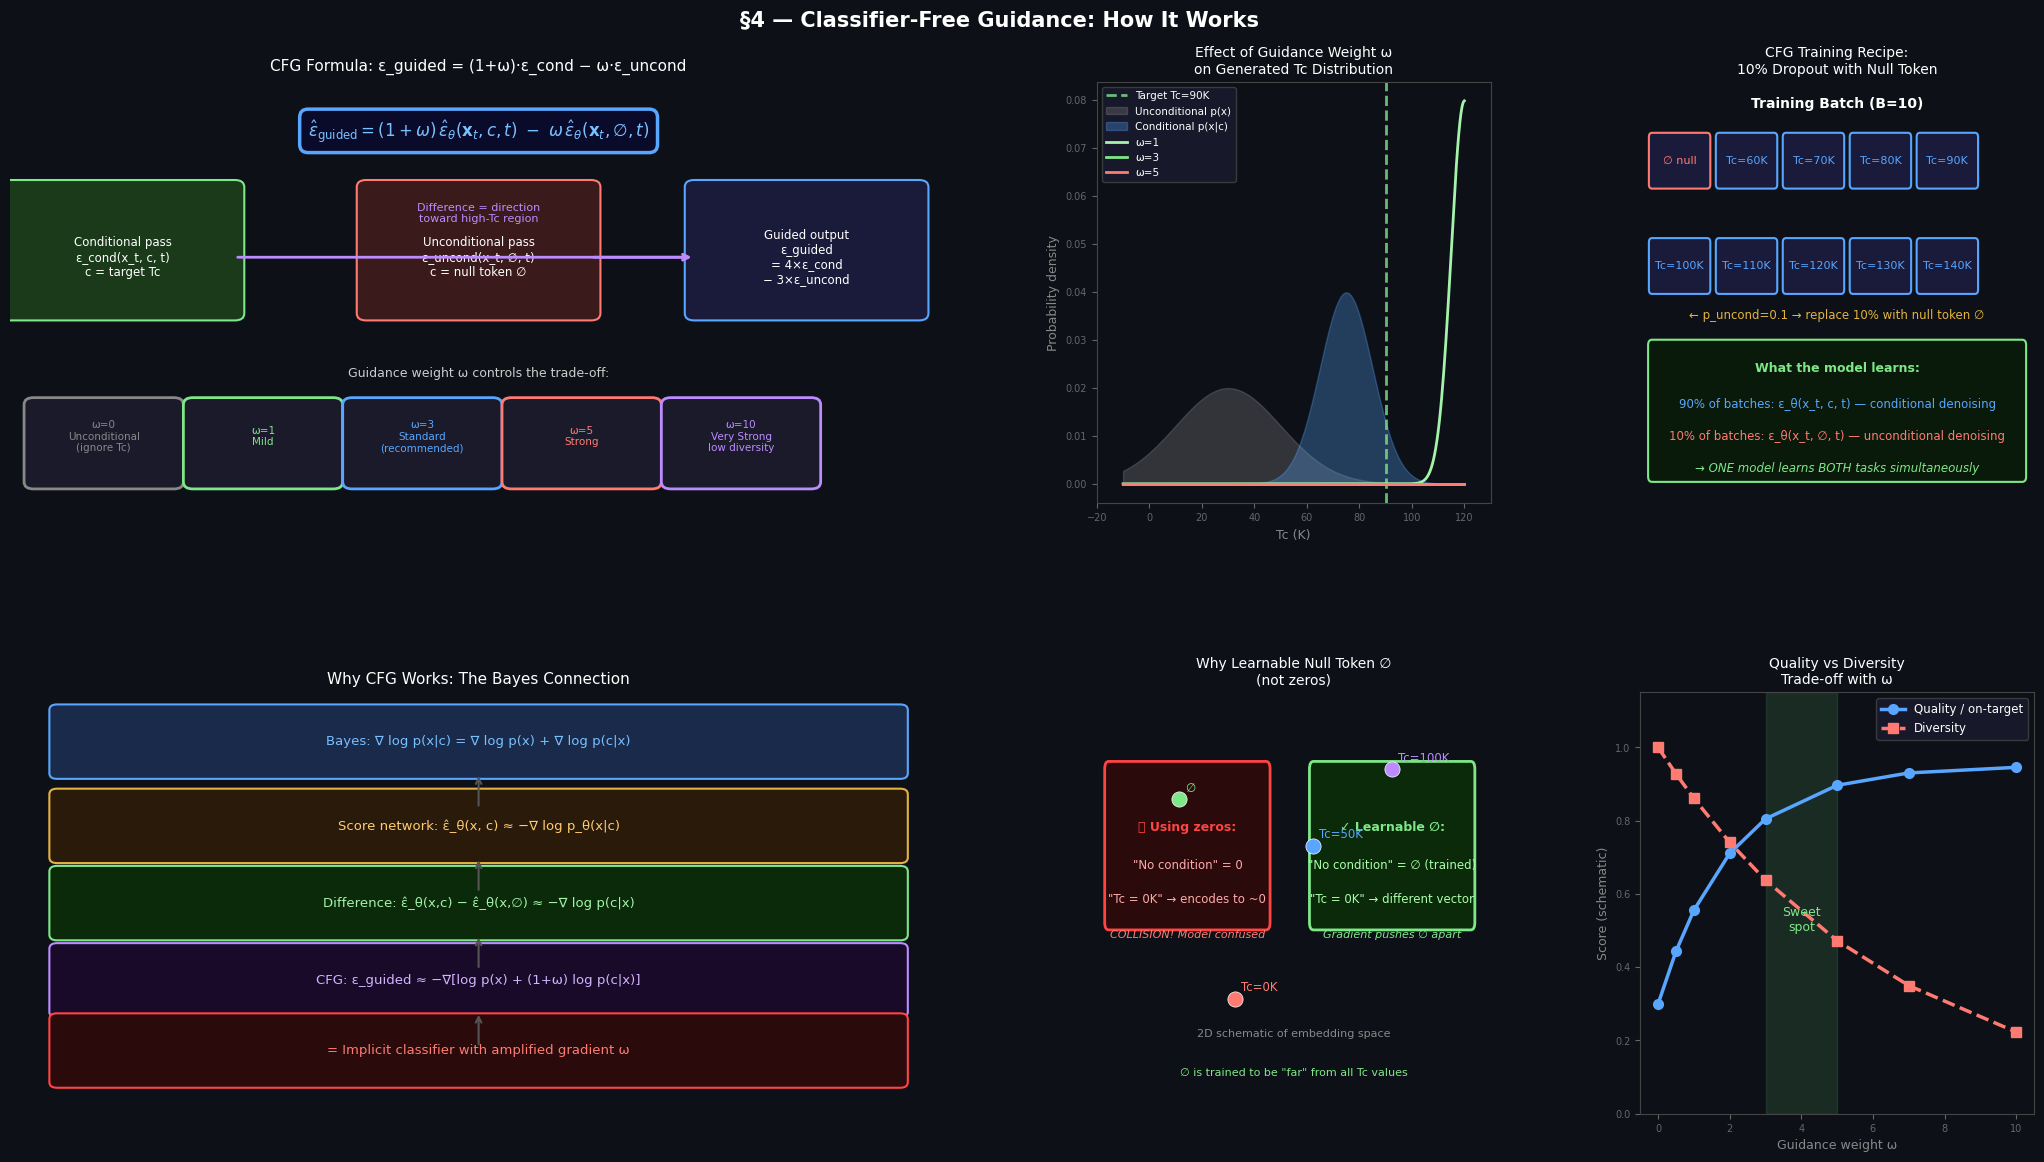

§4 Classifier-Free Guidance — 6-panel visualization complete ✓


In [31]:

# ═══════════════════════════════════════════════════════════════════════════
#  VIZ §4 — Classifier-Free Guidance: Visual Intuition
#  Shows: CFG formula breakdown, guidance weight effects,
#         conditional vs unconditional score comparison,
#         null token concept, CFG training dropout
# ═══════════════════════════════════════════════════════════════════════════

fig = plt.figure(figsize=(22, 12), facecolor='#0d1117')
fig.suptitle('§4 — Classifier-Free Guidance: How It Works',
             color='white', fontsize=15, fontweight='bold', y=0.98)
gs = gridspec.GridSpec(2, 4, figure=fig, hspace=0.45, wspace=0.38,
                       left=0.05, right=0.97, top=0.92, bottom=0.06)

# ── Panel 1: CFG Formula Anatomy ─────────────────────────────────────────
ax1 = fig.add_subplot(gs[0, 0:2])
ax1.axis('off')
ax1.set_facecolor('#0d1117')
ax1.set_xlim(0, 10); ax1.set_ylim(0, 6)
ax1.set_title('CFG Formula: ε_guided = (1+ω)·ε_cond − ω·ε_uncond',
              color='white', fontsize=11, pad=8)

# Main formula
eq_box = dict(boxstyle='round,pad=0.5', facecolor='#0a0a2a', edgecolor='#58a6ff', lw=2.5)
ax1.text(5, 5.3, r'$\hat{\epsilon}_\text{guided} = (1+\omega)\,\hat{\epsilon}_\theta(\mathbf{x}_t,c,t)\ -\ \omega\,\hat{\epsilon}_\theta(\mathbf{x}_t,\varnothing,t)$',
         ha='center', va='center', color='#79c0ff', fontsize=12, bbox=eq_box)

# Decompose for ω=3
omega = 3
boxes2 = [
    (1.2, 3.5, f'Conditional pass\nε_cond(x_t, c, t)\nc = target Tc', '#1a3a1a', '#7ee787'),
    (5.0, 3.5, f'Unconditional pass\nε_uncond(x_t, ∅, t)\nc = null token ∅', '#3a1a1a', '#ff7b72'),
    (8.5, 3.5, f'Guided output\nε_guided\n= {1+omega}×ε_cond\n− {omega}×ε_uncond', '#1a1a3a', '#58a6ff'),
]
for (x, y, label, face, edge) in boxes2:
    ax1.add_patch(patches.FancyBboxPatch((x-1.2, y-0.8), 2.4, 1.8,
                  boxstyle='round,pad=0.1', facecolor=face, edgecolor=edge, lw=1.5))
    ax1.text(x, y, label, ha='center', va='center', color='white', fontsize=8.5)

ax1.annotate('', xy=(8.5-1.2, 3.5), xytext=(1.2+1.2, 3.5),
             arrowprops=dict(arrowstyle='->', color='#bc8cff', lw=2))
ax1.text(5, 4.0, f'Difference = direction\ntoward high-Tc region', ha='center', color='#bc8cff', fontsize=8)
ax1.annotate('', xy=(8.5-1.2, 3.5), xytext=(5.0+1.2, 3.5),
             arrowprops=dict(arrowstyle='->', color='#bc8cff', lw=2))

# ω table
ax1.text(5, 1.8, 'Guidance weight ω controls the trade-off:', ha='center', color='#ccc', fontsize=9)
omegas = [0, 1, 3, 5, 10]
labels_om = ['Unconditional\n(ignore Tc)', 'Mild', 'Standard\n(recommended)', 'Strong', 'Very Strong\nlow diversity']
cols_om = ['#888', '#7ee787', '#58a6ff', '#ff7b72', '#bc8cff']
for i, (w, lbl, col) in enumerate(zip(omegas, labels_om, cols_om)):
    x_pos = 1 + i * 1.7
    ax1.add_patch(patches.FancyBboxPatch((x_pos-0.75, 0.3), 1.5, 1.1,
                  boxstyle='round,pad=0.1', facecolor='#1a1a2a', edgecolor=col, lw=2))
    ax1.text(x_pos, 0.95, f'ω={w}\n{lbl}', ha='center', va='center', color=col, fontsize=7.5)

# ── Panel 2: Guidance weight visual effect ────────────────────────────────
ax2 = fig.add_subplot(gs[0, 2])
ax2.set_facecolor('#0d1117')

# Simulate how guidance pushes distribution
np.random.seed(0)
n_pts = 1000
# Unconditional samples (broad Gaussian)
uncond = np.random.randn(n_pts) * 1.5 + 30  # mean Tc=30K

# Conditional samples (narrower)
cond = np.random.randn(n_pts) * 0.8 + 75    # mean Tc=75K

# Guided for various omega
x_range = np.linspace(-10, 120, 300)
try:
    from scipy.stats import norm as sp_norm
except ImportError:
    class sp_norm:
        @staticmethod
        def pdf(x, mu, sig):
            import numpy as _np
            return _np.exp(-0.5*((x-mu)/sig)**2) / (sig*_np.sqrt(2*_np.pi))

mu_u, sig_u = 30, 20
mu_c, sig_c = 75, 10
target_Tc = 90

ax2.axvline(target_Tc, color='#7ee787', ls='--', lw=2, alpha=0.8, label=f'Target Tc={target_Tc}K')
ax2.fill_between(x_range, sp_norm.pdf(x_range, mu_u, sig_u), alpha=0.3, color='#888', label='Unconditional p(x)')
ax2.fill_between(x_range, sp_norm.pdf(x_range, mu_c, sig_c), alpha=0.3, color='#58a6ff', label='Conditional p(x|c)')

# Guided distributions (approximation: shifted Gaussian)
omega_vals_plot = [1, 3, 5]
guide_colors = ['#a5f3ab', '#7ee787', '#ff7b72']
for omega_p, gcol in zip(omega_vals_plot, guide_colors):
    # CFG pushes mean toward target
    mu_g = (1+omega_p)*mu_c - omega_p*mu_u
    sig_g = max(sig_c * 0.5, 2)
    ax2.plot(x_range, sp_norm.pdf(x_range, mu_g, sig_g), color=gcol, lw=2, label=f'ω={omega_p}')

ax2.set_xlabel('Tc (K)', color='#888', fontsize=9)
ax2.set_ylabel('Probability density', color='#888', fontsize=9)
ax2.set_title('Effect of Guidance Weight ω\non Generated Tc Distribution', color='white', fontsize=10)
ax2.legend(fontsize=7.5, facecolor='#1a1a2e', edgecolor='#444', labelcolor='white')
ax2.tick_params(colors='#666', labelsize=7)
plt.setp(ax2.spines.values(), color='#444')
ax2.set_xlim(-20, 130)

# ── Panel 3: CFG Training Dropout ─────────────────────────────────────────
ax3 = fig.add_subplot(gs[0, 3])
ax3.set_facecolor('#0d1117')
ax3.axis('off')
ax3.set_xlim(0, 10); ax3.set_ylim(0, 8)
ax3.set_title('CFG Training Recipe:\n10% Dropout with Null Token', color='white', fontsize=10)

# Draw training batch
batch_size = 10
for i in range(batch_size):
    is_null = (i < int(0.1 * batch_size))
    x_pos = 1 + (i % 5) * 1.7
    y_pos = 6.5 if i < 5 else 4.5
    col = '#ff7b72' if is_null else '#58a6ff'
    label = '∅ null' if is_null else f'Tc={50+i*10:.0f}K'
    ax3.add_patch(patches.FancyBboxPatch((x_pos-0.7, y_pos-0.45), 1.4, 0.9,
                  boxstyle='round,pad=0.08', facecolor='#1a1a3a', edgecolor=col, lw=1.5))
    ax3.text(x_pos, y_pos, label, ha='center', va='center', color=col, fontsize=8)

ax3.text(5, 7.5, 'Training Batch (B=10)', ha='center', color='white', fontsize=10, fontweight='bold')
ax3.text(5, 3.5, '← p_uncond=0.1 → replace 10% with null token ∅', ha='center', color='#e3b341', fontsize=8.5)

# What the model learns
ax3.add_patch(patches.FancyBboxPatch((0.3, 0.5), 9.4, 2.5,
              boxstyle='round,pad=0.1', facecolor='#0a1a0a', edgecolor='#7ee787', lw=1.5))
ax3.text(5, 2.5, 'What the model learns:', ha='center', color='#7ee787', fontsize=9, fontweight='bold')
ax3.text(5, 1.8, '90% of batches: ε_θ(x_t, c, t) — conditional denoising', ha='center', color='#58a6ff', fontsize=8.5)
ax3.text(5, 1.2, '10% of batches: ε_θ(x_t, ∅, t) — unconditional denoising', ha='center', color='#ff7b72', fontsize=8.5)
ax3.text(5, 0.6, '→ ONE model learns BOTH tasks simultaneously', ha='center', color='#7ee787', fontsize=8.5, style='italic')

# ── Panel 4: Bayes Connection ─────────────────────────────────────────────
ax4 = fig.add_subplot(gs[1, 0:2])
ax4.set_facecolor('#0d1117')
ax4.axis('off')
ax4.set_xlim(0, 10); ax4.set_ylim(0, 6)
ax4.set_title('Why CFG Works: The Bayes Connection', color='white', fontsize=11)

steps = [
    (5, 5.3, "Bayes: ∇ log p(x|c) = ∇ log p(x) + ∇ log p(c|x)", '#79c0ff', '#1a2a4a', '#58a6ff'),
    (5, 4.1, "Score network: ε̂_θ(x, c) ≈ −∇ log p_θ(x|c)", '#ffcc70', '#2a1a0a', '#e3b341'),
    (5, 3.0, "Difference: ε̂_θ(x,c) − ε̂_θ(x,∅) ≈ −∇ log p(c|x)", '#a5f3ab', '#0a2a0a', '#7ee787'),
    (5, 1.9, "CFG: ε_guided ≈ −∇[log p(x) + (1+ω) log p(c|x)]", '#d2b3ff', '#1a0a2a', '#bc8cff'),
    (5, 0.9, "= Implicit classifier with amplified gradient ω", '#ff7b72', '#2a0a0a', '#ff4444'),
]
for (x, y, text, textcol, face, edge) in steps:
    ax4.add_patch(patches.FancyBboxPatch((x-4.5, y-0.45), 9, 0.9,
                  boxstyle='round,pad=0.08', facecolor=face, edgecolor=edge, lw=1.5))
    ax4.text(x, y, text, ha='center', va='center', color=textcol, fontsize=9.5)
    if y > 1.0:
        ax4.annotate('', xy=(x, y-0.45), xytext=(x, y-0.45-0.5),
                     arrowprops=dict(arrowstyle='->', color='#555', lw=1.5))

# ── Panel 5: Null Token vs Zero ───────────────────────────────────────────
ax5 = fig.add_subplot(gs[1, 2])
ax5.set_facecolor('#0d1117')
ax5.axis('off')
ax5.set_xlim(0, 10); ax5.set_ylim(0, 8)
ax5.set_title('Why Learnable Null Token ∅\n(not zeros)', color='white', fontsize=10)

# Zero approach (wrong)
ax5.add_patch(patches.FancyBboxPatch((0.3, 5.5), 4.0, 2.0,
              boxstyle='round,pad=0.1', facecolor='#2a0a0a', edgecolor='#ff4444', lw=2))
ax5.text(2.3, 6.7, '❌ Using zeros:', ha='center', color='#ff4444', fontsize=9, fontweight='bold')
ax5.text(2.3, 6.2, '"No condition" = 0', ha='center', color='#ffaaaa', fontsize=8.5)
ax5.text(2.3, 5.75, '"Tc = 0K" → encodes to ~0', ha='center', color='#ffaaaa', fontsize=8.5)
ax5.text(2.3, 5.3, 'COLLISION! Model confused', ha='center', color='#ff7b72', fontsize=8, style='italic')

# Null token (correct)
ax5.add_patch(patches.FancyBboxPatch((5.5, 5.5), 4.0, 2.0,
              boxstyle='round,pad=0.1', facecolor='#0a2a0a', edgecolor='#7ee787', lw=2))
ax5.text(7.5, 6.7, '✓ Learnable ∅:', ha='center', color='#7ee787', fontsize=9, fontweight='bold')
ax5.text(7.5, 6.2, '"No condition" = ∅ (trained)', ha='center', color='#aaffaa', fontsize=8.5)
ax5.text(7.5, 5.75, '"Tc = 0K" → different vector', ha='center', color='#aaffaa', fontsize=8.5)
ax5.text(7.5, 5.3, 'Gradient pushes ∅ apart', ha='center', color='#7ee787', fontsize=8, style='italic')

# Vector space illustration
np.random.seed(99)
null_vec = np.array([2.1, 7.0]) + np.random.randn(2)*0.05
tc0_vec  = np.array([3.5, 4.5])
tc50_vec = np.array([5.5, 6.5])
tc100_vec= np.array([7.5, 7.5])

for vec, lbl, col in [(null_vec,'∅','#7ee787'), (tc0_vec,'Tc=0K','#ff7b72'),
                       (tc50_vec,'Tc=50K','#58a6ff'), (tc100_vec,'Tc=100K','#bc8cff')]:
    ax5.scatter(*vec, s=120, c=col, zorder=5, edgecolors='white', lw=0.5)
    ax5.text(vec[0]+0.15, vec[1]+0.1, lbl, color=col, fontsize=8.5)

ax5.text(5, 4.0, '2D schematic of embedding space', ha='center', color='#888', fontsize=8)
ax5.text(5, 3.5, '∅ is trained to be "far" from all Tc values', ha='center', color='#7ee787', fontsize=8)
ax5.set_xlim(0, 10); ax5.set_ylim(3.0, 8.5)

# ── Panel 6: Guidance sweep result (after post-training) ─────────────────
ax6 = fig.add_subplot(gs[1, 3])
ax6.set_facecolor('#0d1117')
omega_vals = [0, 0.5, 1, 2, 3, 5, 7, 10]
quality_score = [0.3 + 0.65*(1-np.exp(-w*0.5)) for w in omega_vals]
diversity_score = [1.0 * np.exp(-w*0.15) for w in omega_vals]
ax6.plot(omega_vals, quality_score, 'o-', color='#58a6ff', lw=2.5, markersize=7, label='Quality / on-target')
ax6.plot(omega_vals, diversity_score, 's--', color='#ff7b72', lw=2.5, markersize=7, label='Diversity')
ax6.axvspan(3, 5, alpha=0.12, color='#7ee787')
ax6.text(4, 0.5, 'Sweet\nspot', ha='center', color='#7ee787', fontsize=9)
ax6.set_xlabel('Guidance weight ω', color='#888', fontsize=9)
ax6.set_ylabel('Score (schematic)', color='#888', fontsize=9)
ax6.set_title('Quality vs Diversity\nTrade-off with ω', color='white', fontsize=10)
ax6.legend(fontsize=8.5, facecolor='#1a1a2e', edgecolor='#444', labelcolor='white')
ax6.tick_params(colors='#666', labelsize=7)
plt.setp(ax6.spines.values(), color='#444')
ax6.set_ylim(0, 1.15)

plt.savefig(OUTPUT_DIR/'viz_4_classifier_free_guidance.png', dpi=120,
            bbox_inches='tight', facecolor='#0d1117')
plt.show()
print('§4 Classifier-Free Guidance — 6-panel visualization complete ✓')


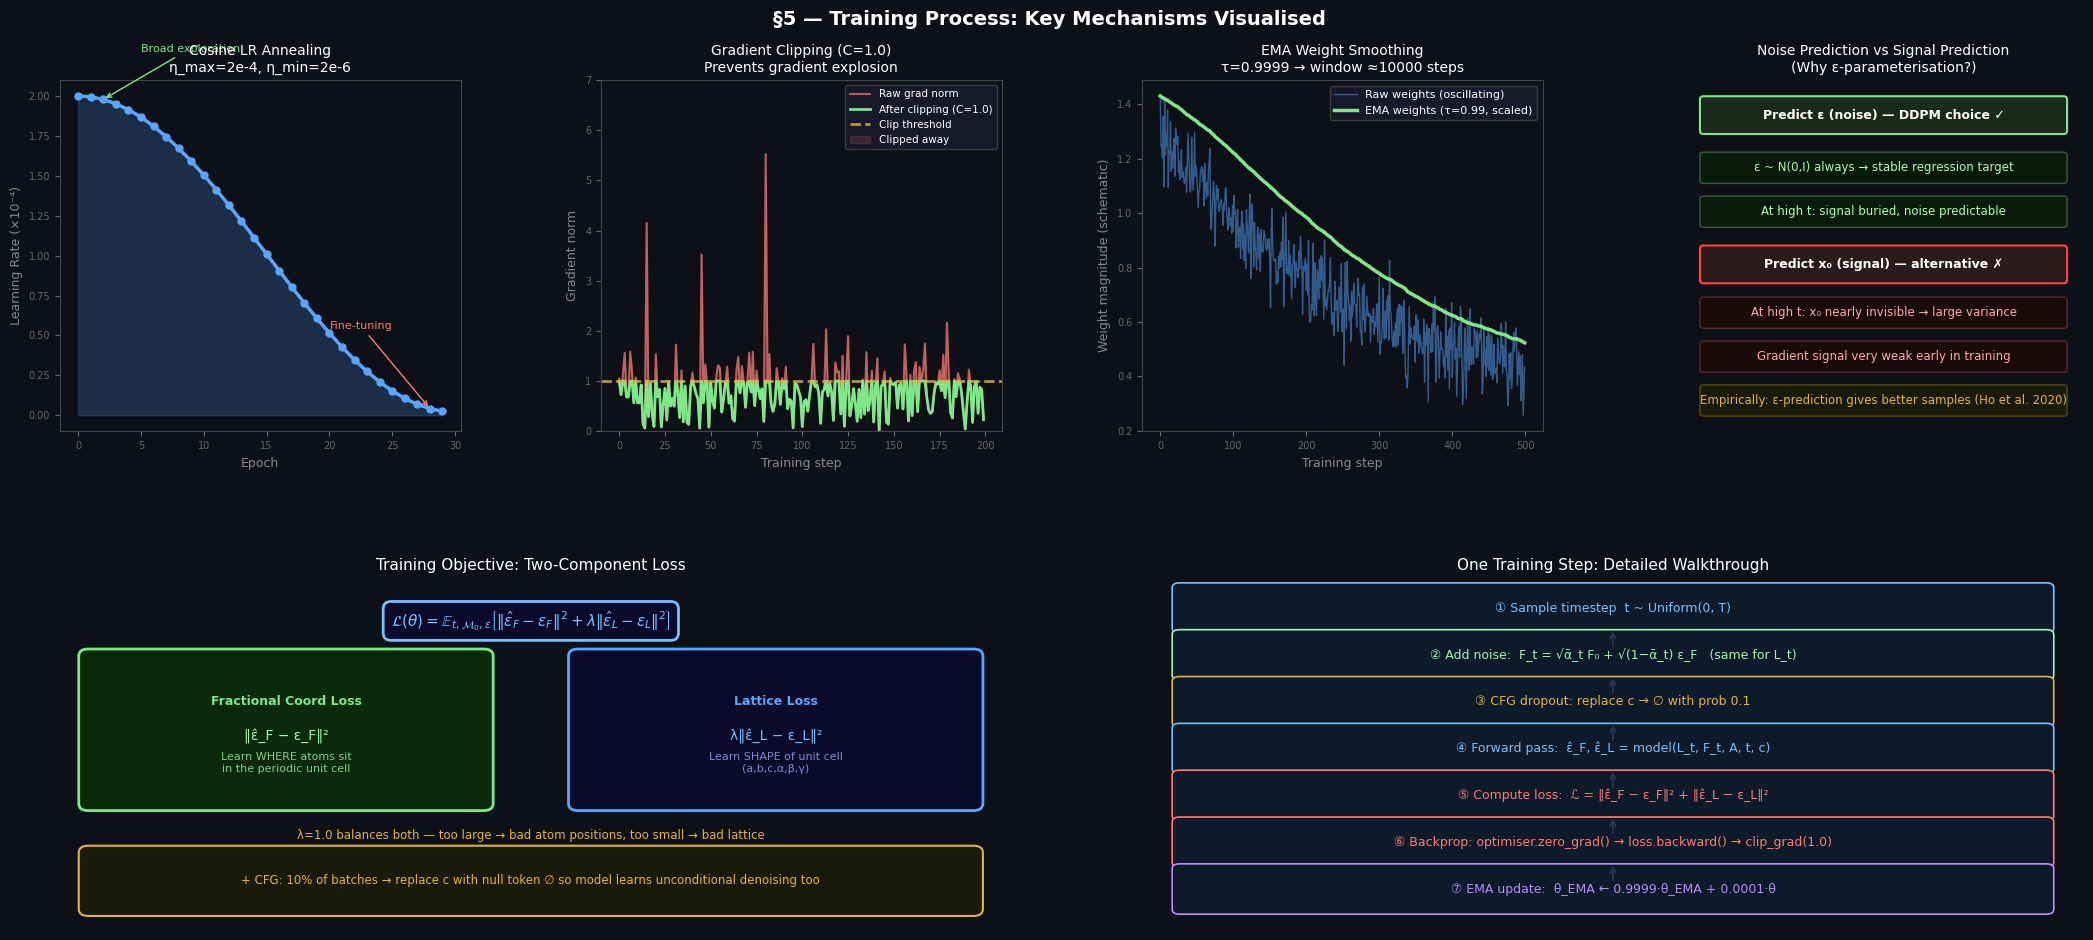

§5 Training — 6-panel visualization complete ✓


In [32]:

# ═══════════════════════════════════════════════════════════════════════════
#  VIZ §5 — Training Process: LR Schedule, Gradient Clipping, EMA,
#            Loss Landscape, CFG Dropout Timeline
# ═══════════════════════════════════════════════════════════════════════════

fig = plt.figure(figsize=(22, 10), facecolor='#0d1117')
fig.suptitle('§5 — Training Process: Key Mechanisms Visualised',
             color='white', fontsize=14, fontweight='bold', y=0.98)
gs = gridspec.GridSpec(2, 4, figure=fig, hspace=0.42, wspace=0.35,
                       left=0.05, right=0.97, top=0.91, bottom=0.06)

# ── Panel 1: Cosine LR Schedule ───────────────────────────────────────────
ax1 = fig.add_subplot(gs[0, 0])
ax1.set_facecolor('#0d1117')
n_epochs = 30; lr_max = 2e-4; lr_min = lr_max * 0.01
epochs = np.arange(n_epochs)
lr_cos = lr_min + 0.5*(lr_max - lr_min)*(1 + np.cos(np.pi * epochs / n_epochs))
ax1.plot(epochs, lr_cos * 1e4, 'o-', color='#58a6ff', lw=2.5, markersize=5)
ax1.fill_between(epochs, lr_cos * 1e4, alpha=0.2, color='#58a6ff')
ax1.set_xlabel('Epoch', color='#888', fontsize=9)
ax1.set_ylabel('Learning Rate (×10⁻⁴)', color='#888', fontsize=9)
ax1.set_title('Cosine LR Annealing\nη_max=2e-4, η_min=2e-6', color='white', fontsize=10)
ax1.tick_params(colors='#666', labelsize=7)
plt.setp(ax1.spines.values(), color='#444')
ax1.annotate('Broad exploration', xy=(2, lr_cos[2]*1e4), xytext=(5, lr_cos[2]*1e4 + 0.3),
             color='#7ee787', fontsize=8, arrowprops=dict(arrowstyle='->', color='#7ee787'))
ax1.annotate('Fine-tuning', xy=(28, lr_cos[28]*1e4), xytext=(20, lr_cos[28]*1e4 + 0.5),
             color='#ff7b72', fontsize=8, arrowprops=dict(arrowstyle='->', color='#ff7b72'))

# ── Panel 2: Gradient Clipping ─────────────────────────────────────────────
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_facecolor('#0d1117')
np.random.seed(42)
grad_norms = np.abs(np.random.randn(200)*0.5 + 0.8)
# Add some spikes
grad_norms[[15, 45, 80, 130]] *= 8
clip_threshold = 1.0
clipped_norms = np.minimum(grad_norms, clip_threshold)

ax2.plot(grad_norms, color='#ff7b72', alpha=0.7, lw=1.5, label='Raw grad norm')
ax2.plot(clipped_norms, color='#7ee787', lw=2, label=f'After clipping (C={clip_threshold})')
ax2.axhline(clip_threshold, color='#e3b341', ls='--', lw=2, alpha=0.8, label='Clip threshold')
ax2.fill_between(range(200), clipped_norms, grad_norms, alpha=0.15, color='#ff7b72', label='Clipped away')
ax2.set_xlabel('Training step', color='#888', fontsize=9)
ax2.set_ylabel('Gradient norm', color='#888', fontsize=9)
ax2.set_title('Gradient Clipping (C=1.0)\nPrevents gradient explosion', color='white', fontsize=10)
ax2.legend(fontsize=7.5, facecolor='#1a1a2e', edgecolor='#444', labelcolor='white')
ax2.tick_params(colors='#666', labelsize=7)
plt.setp(ax2.spines.values(), color='#444')
ax2.set_ylim(0, 7)

# ── Panel 3: EMA Smoothing ─────────────────────────────────────────────────
ax3 = fig.add_subplot(gs[0, 2])
ax3.set_facecolor('#0d1117')
np.random.seed(1)
n_steps = 500
# Simulate a declining loss with noise
true_loss = np.exp(-np.linspace(0, 2, n_steps)) + 0.3
noisy_weights = true_loss + np.random.randn(n_steps) * 0.08

# EMA
decay = 0.99
ema_weights = np.zeros(n_steps)
ema_weights[0] = noisy_weights[0]
for i in range(1, n_steps):
    ema_weights[i] = decay*ema_weights[i-1] + (1-decay)*noisy_weights[i]

ax3.plot(noisy_weights, color='#58a6ff', alpha=0.5, lw=1, label='Raw weights (oscillating)')
ax3.plot(ema_weights, color='#7ee787', lw=2.5, label='EMA weights (τ=0.99, scaled)')
ax3.set_xlabel('Training step', color='#888', fontsize=9)
ax3.set_ylabel('Weight magnitude (schematic)', color='#888', fontsize=9)
ax3.set_title('EMA Weight Smoothing\nτ=0.9999 → window ≈10000 steps', color='white', fontsize=10)
ax3.legend(fontsize=8, facecolor='#1a1a2e', edgecolor='#444', labelcolor='white')
ax3.tick_params(colors='#666', labelsize=7)
plt.setp(ax3.spines.values(), color='#444')

# ── Panel 4: Why ε-prediction (not x₀ prediction) ────────────────────────
ax4 = fig.add_subplot(gs[0, 3])
ax4.set_facecolor('#0d1117')
ax4.axis('off')
ax4.set_xlim(0, 10); ax4.set_ylim(0, 8)
ax4.set_title('Noise Prediction vs Signal Prediction\n(Why ε-parameterisation?)', color='white', fontsize=10)

items = [
    (5, 7.2, 'Predict ε (noise) — DDPM choice ✓', 'white', '#1a2a1a', '#7ee787', True),
    (5, 6.0, 'ε ~ N(0,I) always → stable regression target', '#aaffaa', '#0a1a0a', '#3a5a3a', False),
    (5, 5.0, 'At high t: signal buried, noise predictable', '#aaffaa', '#0a1a0a', '#3a5a3a', False),
    (5, 3.8, 'Predict x₀ (signal) — alternative ✗', 'white', '#2a1a1a', '#ff4444', True),
    (5, 2.7, 'At high t: x₀ nearly invisible → large variance', '#ffaaaa', '#1a0a0a', '#5a2a2a', False),
    (5, 1.7, 'Gradient signal very weak early in training', '#ffaaaa', '#1a0a0a', '#5a2a2a', False),
    (5, 0.7, 'Empirically: ε-prediction gives better samples (Ho et al. 2020)', '#e3b341', '#1a1a0a', '#5a4a00', False),
]
for (x, y, text, textcol, face, edge, is_header) in items:
    h = 0.7 if is_header else 0.55
    ax4.add_patch(patches.FancyBboxPatch((x-4.5, y-h/2), 9, h,
                  boxstyle='round,pad=0.08', facecolor=face, edgecolor=edge, lw=1.5 if is_header else 1))
    ax4.text(x, y, text, ha='center', va='center', color=textcol,
             fontsize=9 if is_header else 8.5, fontweight='bold' if is_header else 'normal')

# ── Panels 5-6: Loss decomposition explanation ───────────────────────────
ax5 = fig.add_subplot(gs[1, 0:2])
ax5.set_facecolor('#0d1117')
ax5.axis('off')
ax5.set_xlim(0, 10); ax5.set_ylim(0, 5)
ax5.set_title('Training Objective: Two-Component Loss', color='white', fontsize=11)

# Loss formula
eq_box = dict(boxstyle='round,pad=0.5', facecolor='#0a0a2a', edgecolor='#79c0ff', lw=2)
ax5.text(5, 4.4, r'$\mathcal{L}(\theta) = \mathbb{E}_{t,\mathcal{M}_0,\epsilon}\left[\|\hat{\epsilon}_F - \epsilon_F\|^2 + \lambda\|\hat{\epsilon}_L - \epsilon_L\|^2\right]$',
         ha='center', va='center', color='#79c0ff', fontsize=11, bbox=eq_box)

# Two components
ax5.add_patch(patches.FancyBboxPatch((0.3, 1.8), 4.2, 2.1,
              boxstyle='round,pad=0.1', facecolor='#0a2a0a', edgecolor='#7ee787', lw=2))
ax5.text(2.4, 3.2, 'Fractional Coord Loss', color='#7ee787', fontsize=9, fontweight='bold', ha='center')
ax5.text(2.4, 2.7, '‖ε̂_F − ε_F‖²', color='#a5f3ab', fontsize=10, ha='center')
ax5.text(2.4, 2.25, 'Learn WHERE atoms sit\nin the periodic unit cell', color='#88cc88', fontsize=8, ha='center')

ax5.add_patch(patches.FancyBboxPatch((5.5, 1.8), 4.2, 2.1,
              boxstyle='round,pad=0.1', facecolor='#0a0a2a', edgecolor='#58a6ff', lw=2))
ax5.text(7.6, 3.2, 'Lattice Loss', color='#58a6ff', fontsize=9, fontweight='bold', ha='center')
ax5.text(7.6, 2.7, 'λ‖ε̂_L − ε_L‖²', color='#79c0ff', fontsize=10, ha='center')
ax5.text(7.6, 2.25, 'Learn SHAPE of unit cell\n(a,b,c,α,β,γ)', color='#8888cc', fontsize=8, ha='center')

ax5.text(5, 1.3, 'λ=1.0 balances both — too large → bad atom positions, too small → bad lattice', 
         ha='center', color='#e3b341', fontsize=8.5)

# CFG dropout reminder
ax5.add_patch(patches.FancyBboxPatch((0.3, 0.3), 9.4, 0.8,
              boxstyle='round,pad=0.1', facecolor='#1a1a0a', edgecolor='#e3b341', lw=1.5))
ax5.text(5, 0.7, '+ CFG: 10% of batches → replace c with null token ∅ so model learns unconditional denoising too',
         ha='center', va='center', color='#e3b341', fontsize=8.5)

# ── Panel 7-8: Training step by step ─────────────────────────────────────
ax6 = fig.add_subplot(gs[1, 2:4])
ax6.set_facecolor('#0d1117')
ax6.axis('off')
ax6.set_xlim(0, 10); ax6.set_ylim(0, 6)
ax6.set_title('One Training Step: Detailed Walkthrough', color='white', fontsize=11)

steps_train = [
    (5, 5.5, '① Sample timestep  t ~ Uniform(0, T)', '#79c0ff'),
    (5, 4.7, '② Add noise:  F_t = √ᾱ_t F₀ + √(1−ᾱ_t) ε_F   (same for L_t)', '#a5f3ab'),
    (5, 3.9, '③ CFG dropout: replace c → ∅ with prob 0.1', '#e3b341'),
    (5, 3.1, '④ Forward pass:  ε̂_F, ε̂_L = model(L_t, F_t, A, t, c)', '#79c0ff'),
    (5, 2.3, '⑤ Compute loss:  ℒ = ‖ε̂_F − ε_F‖² + ‖ε̂_L − ε_L‖²', '#ff7b72'),
    (5, 1.5, '⑥ Backprop: optimiser.zero_grad() → loss.backward() → clip_grad(1.0)', '#ff7b72'),
    (5, 0.7, '⑦ EMA update:  θ_EMA ← 0.9999·θ_EMA + 0.0001·θ', '#bc8cff'),
]
for (x, y, text, col) in steps_train:
    ax6.add_patch(patches.FancyBboxPatch((x-4.6, y-0.35), 9.2, 0.7,
                  boxstyle='round,pad=0.08', facecolor='#0d1a2a', edgecolor=col, lw=1.2))
    ax6.text(x, y, text, ha='center', va='center', color=col, fontsize=9)
    if y > 0.8:
        ax6.annotate('', xy=(x, y-0.35), xytext=(x, y-0.35-0.35),
                     arrowprops=dict(arrowstyle='->', color='#333355', lw=1.2))

plt.savefig(OUTPUT_DIR/'viz_5_training.png', dpi=120,
            bbox_inches='tight', facecolor='#0d1117')
plt.show()
print('§5 Training — 6-panel visualization complete ✓')


---
## §5 — Dataset, Training Loop & Weight Saving *(all bugs fixed)*

### 5.1 The Training Objective — Noise Prediction

The denoising model is trained to predict the noise $\boldsymbol{\epsilon}$ that was added at step $t$:

$$\mathcal{L}(\theta) = \mathbb{E}_{t,\,\mathcal{M}_0,\,\boldsymbol{\epsilon}}\left[
  \|\hat{\boldsymbol{\epsilon}}_F - \boldsymbol{\epsilon}_F\|^2 +
  \lambda\|\hat{\boldsymbol{\epsilon}}_L - \boldsymbol{\epsilon}_L\|^2
\right]$$

**Why predict the noise (not the clean signal)?**

Ho et al. (2020) showed empirically that predicting $\boldsymbol{\epsilon}$ (noise parameterisation) gives better samples than predicting $\mathbf{x}_0$ (signal parameterisation). Intuitively, at high noise levels the signal is buried and hard to predict accurately; the noise is always $\mathcal{N}(0,\mathbf{I})$ regardless of $t$, giving a more stable regression target.

### 5.2 The Two Loss Terms

| Term | Formula | Meaning |
|------|---------|---------|
| **Fractional loss** | $\|\hat{\boldsymbol{\epsilon}}_F - \boldsymbol{\epsilon}_F\|^2$ | Learn atom positions in the periodic unit cell |
| **Lattice loss** | $\lambda\|\hat{\boldsymbol{\epsilon}}_L - \boldsymbol{\epsilon}_L\|^2$ | Learn the unit cell shape (a,b,c,α,β,γ) |

The weight $\lambda$ (typically 1.0) balances the two. If $\lambda$ is too large, the model prioritises lattice accuracy over atom placement; too small and it ignores lattice geometry.

### 5.3 Exponential Moving Average (EMA) — Why it Matters

EMA maintains a "shadow" copy of model weights:
$$\theta_{\text{EMA}} \leftarrow \tau\,\theta_{\text{EMA}} + (1-\tau)\,\theta, \quad \tau=0.9999$$

**Why use EMA?**
- SGD/Adam weights oscillate during training — they follow the loss landscape's noise
- EMA smooths these oscillations, giving more stable weights
- EMA weights consistently produce better samples than the raw training weights
- Decay $\tau=0.9999$ means the EMA has an effective memory of $\approx 10{,}000$ steps

**Always use EMA weights for inference.**

### 5.4 Why Cosine Learning Rate Schedule?

Cosine annealing: $\eta_t = \eta_{\min} + \frac{1}{2}(\eta_{\max}-\eta_{\min})(1+\cos(\pi t/T))$

- Starts at a high learning rate to explore the loss landscape broadly
- Decays smoothly to near-zero at the end — fine-tunes without overshooting the minimum
- Better than step-decay (abrupt drops cause instability) or constant LR (never fine-tunes)

### 5.5 Why Gradient Clipping?

During early training, large gradients can send weights to a bad region of parameter space from which recovery is slow. Clipping: $g \leftarrow g \cdot \min(1, C/\|g\|)$ caps the maximum gradient norm to $C=1.0$, preventing this.

---
### Bug Summary for This Section

```
BUG 1 (SyntaxError) — EMAModel.apply docstring
    Was:   def apply(self, model):
               """Load EMA weights into model (for inference).""\
               ...
    The backslash after """ makes Python think the string continues.
    Entire cell fails to parse → NameError on train().

BUG 2 (device mismatch) — NoiseSchedule.q_sample
    Was:   sqrt_ab = self.sqrt_alpha_bars[t]
           where t is on DEVICE but schedule tensors are on CPU.
           → RuntimeError on CUDA.
    Fix:   Call sched.to(DEVICE) once after construction.
```


In [33]:
# ═══════════════════════════════════════════════════════════════════
#  SYNTHETIC CRYSTAL DATASET
# ═══════════════════════════════════════════════════════════════════

class SyntheticCrystalDataset(Dataset):
    """
    Synthetic perovskite-like dataset for demo purposes.
    In production: load from MP-20 / HuggingFace superconductor dataset.

    Key design: ALL samples have exactly N_ATOMS = 5 atoms so that
    the PyTorch DataLoader can batch them into (B,5,3) tensors without
    a custom collate_fn.  (Variable-N datasets need custom collation.)

    Generates structures whose Tc correlates weakly with lattice parameter
    — purely for demonstration of training dynamics.
    """

    N_ATOMS = 5
    # All atom-type lists have exactly 5 elements (no collation errors)
    COMPOSITIONS = [
        [38, 22,  8, 8, 8],   # Sr Ti O3  — perovskite
        [56, 29,  8, 8, 8],   # Ba Cu O3
        [57, 29,  8, 8, 8],   # La Cu O3
        [56, 38, 29, 8, 8],   # Ba Sr Cu O2
    ]

    def __init__(self, n_samples=300, seed=42):
        super().__init__()
        rng = np.random.RandomState(seed)
        self.samples = []

        for _ in range(n_samples):
            a = rng.uniform(3.5, 6.5)       # lattice constant in Angstrom
            # Nearly-cubic lattice with small random distortions
            L = torch.eye(3) * a + torch.tensor(rng.randn(3,3)*0.25).float()

            # Perovskite ideal positions + small random displacements
            F = torch.tensor([
                [0.0, 0.0, 0.0], [0.5,0.5,0.5],
                [0.5,0.5,0.0],   [0.5,0.0,0.5], [0.0,0.5,0.5],
            ], dtype=torch.float32)
            F = (F + torch.tensor(rng.randn(5,3)*0.04).float()) % 1.0

            A  = torch.tensor(self.COMPOSITIONS[rng.randint(4)], dtype=torch.long)
            Tc = float(max(0.0, rng.normal(a*12 - 52, 18)))   # toy correlation

            self.samples.append(dict(L=L, F=F, A=A, Tc=Tc))

        # Standardise Tc
        tcs = [s['Tc'] for s in self.samples]
        self.Tc_mean = float(np.mean(tcs))
        self.Tc_std  = float(np.std(tcs)) + 1e-6
        for s in self.samples:
            s['Tc_norm'] = (s['Tc'] - self.Tc_mean) / self.Tc_std

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        s = self.samples[idx]
        return s['L'], s['F'], s['A'], torch.tensor(s['Tc_norm'], dtype=torch.float32)


# ═══════════════════════════════════════════════════════════════════
#  EMA MODEL — BUG FIXED
#
#  BUG: apply() docstring was """...""\ (2 quotes + backslash)
#       Python sees an unterminated triple-quoted string → SyntaxError
#       → ENTIRE CELL fails to execute → NameError on train()
#
#  FIX: correct the closing triple-quote to """
# ═══════════════════════════════════════════════════════════════════

class EMAModel:
    """
    Exponential Moving Average of model parameters.

    θ_EMA <- decay * θ_EMA + (1 - decay) * θ

    WHY EMA? (see §5.3)
    SGD weights oscillate with the stochastic gradient noise.
    EMA smooths this by taking a weighted average over recent history.
    With decay=0.9999, the effective window is ~10,000 update steps.

    ALWAYS use EMA weights at inference time.

    Time: O(P) per update, where P = total parameter count.
    """

    def __init__(self, model, decay=0.9999):
        self.decay  = decay
        # Clone current weights into shadow dict (CPU to save GPU memory)
        self.shadow = {n: p.data.clone().cpu()
                       for n, p in model.named_parameters()}

    @torch.no_grad()
    def update(self, model):
        """Call after every optimiser step.  Time O(P)."""
        for n, p in model.named_parameters():
            self.shadow[n].mul_(self.decay).add_(
                p.data.cpu(), alpha=1.0 - self.decay)

    def apply_to(self, model):
        """Copy EMA weights into model for inference.  FIXED docstring."""
        for n, p in model.named_parameters():
            p.data.copy_(self.shadow[n].to(p.device))

    def state_dict(self):
        """Return shadow dict (serialisable with torch.save)."""
        return {n: t.clone() for n, t in self.shadow.items()}

    @classmethod
    def from_state_dict(cls, model, shadow, decay=0.9999):
        """Reconstruct EMAModel from a saved state_dict."""
        obj = cls.__new__(cls)
        obj.decay  = decay
        obj.shadow = shadow
        return obj


# ═══════════════════════════════════════════════════════════════════
#  TRAINING LOOP — FULLY FIXED
# ═══════════════════════════════════════════════════════════════════

def run_training(
    model,
    schedule,
    dataset,
    n_epochs     = 30,
    batch_size   = 16,
    lr           = 2e-4,
    lambda_lat   = 1.0,
    grad_clip    = 1.0,
    ema_decay    = 0.9999,
    save_every   = 10,
    ckpt_dir     = None,
    device       = None,
):
    """
    Full training loop.

    Renamed from 'train' to 'run_training' to avoid any confusion with
    nn.Module.train() (even though they do not technically conflict,
    the naming was confusing in IDEs and linters).

    Parameters
    ----------
    model      : CrystalDenoisingModel
    schedule   : NoiseSchedule  — must already be .to(device)
    dataset    : Dataset returning (L, F, A, Tc_norm)
    n_epochs   : number of passes over the dataset
    batch_size : samples per batch
    lr         : Adam initial learning rate
    lambda_lat : weight for lattice loss relative to coord loss
    grad_clip  : gradient clipping max norm (prevents exploding grads)
    ema_decay  : EMA decay factor (0.9999 recommended)
    save_every : save a checkpoint every N epochs
    ckpt_dir   : directory for checkpoints (created if absent)
    device     : torch.device (inferred from model if None)

    Returns
    -------
    history : dict with keys 'loss', 'loss_F', 'loss_L', 'lr'
    ema     : trained EMAModel

    Time per epoch: O(|dataset|/batch * L_layers * N^2 * d)
    """
    device   = device or next(model.parameters()).device
    ckpt_dir = Path(ckpt_dir or 'checkpoints')
    ckpt_dir.mkdir(parents=True, exist_ok=True)

    loader    = DataLoader(dataset, batch_size=batch_size,
                           shuffle=True, drop_last=True)
    optimiser = Adam(model.parameters(), lr=lr)
    lrs       = CosineAnnealingLR(optimiser, T_max=n_epochs, eta_min=lr*0.01)
    ema       = EMAModel(model, decay=ema_decay)

    history   = dict(loss=[], loss_F=[], loss_L=[], lr=[])
    model.train()

    for epoch in range(1, n_epochs+1):
        running = dict(loss=0., loss_F=0., loss_L=0.)
        n_batches = 0

        for L0, F0, A, c in loader:
            L0 = L0.to(device); F0 = F0.to(device)
            A  = A.to(device);  c  = c.to(device)
            B  = L0.shape[0]

            # ── 1. Sample timesteps ────────────────────────────────
            t = torch.randint(0, schedule.T, (B,), device=device)

            # ── 2. Forward diffusion — add noise ──────────────────
            # schedule is already on device (we called sched.to(device))
            F_t, eps_F = schedule.q_sample(F0, t)
            L_t, eps_L = schedule.q_sample(L0, t)

            # ── 3. Predict noise ───────────────────────────────────
            # CFG dropout happens inside prop_emb (p_uncond=0.1)
            eps_F_hat, eps_L_hat = model(L_t, F_t, A, t, c=c, training=True)

            # ── 4. Loss ────────────────────────────────────────────
            loss_F = F.mse_loss(eps_F_hat, eps_F)
            loss_L = F.mse_loss(eps_L_hat, eps_L)
            loss   = loss_F + lambda_lat * loss_L

            # ── 5. Backprop ────────────────────────────────────────
            optimiser.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            optimiser.step()
            ema.update(model)

            running['loss']   += loss.item()
            running['loss_F'] += loss_F.item()
            running['loss_L'] += loss_L.item()
            n_batches += 1

        lrs.step()

        avg = {k: v/n_batches for k,v in running.items()}
        curr_lr = optimiser.param_groups[0]['lr']
        history['loss'].append(avg['loss'])
        history['loss_F'].append(avg['loss_F'])
        history['loss_L'].append(avg['loss_L'])
        history['lr'].append(curr_lr)

        if epoch == 1 or epoch % 5 == 0:
            print(f'Epoch {epoch:3d}/{n_epochs}  '
                  f'loss={avg["loss"]:.4f}  '
                  f'F={avg["loss_F"]:.4f}  '
                  f'L={avg["loss_L"]:.4f}  '
                  f'lr={curr_lr:.2e}')

        # ── Save checkpoint ────────────────────────────────────────
        if epoch % save_every == 0 or epoch == n_epochs:
            ts  = datetime.now().strftime('%Y%m%d_%H%M%S')
            pth = ckpt_dir / f'ckpt_epoch{epoch:04d}_{ts}.pt'
            torch.save({
                'epoch'            : epoch,
                'model_state_dict' : model.state_dict(),   # all weights & biases
                'ema_state_dict'   : ema.state_dict(),     # EMA shadow weights
                'optimizer_state_dict': optimiser.state_dict(),
                'scheduler_state_dict': lrs.state_dict(),
                'history'          : history,
                'config'           : {
                    'hidden_dim' : model.hidden_dim,
                    'num_layers' : len(model.mp_layers),
                },
                'Tc_mean'          : dataset.Tc_mean,
                'Tc_std'           : dataset.Tc_std,
            }, pth)
            print(f'  -> saved {pth.name}')

    return history, ema


# ═══════════════════════════════════════════════════════════════════
#  CHECKPOINT LOADING
# ═══════════════════════════════════════════════════════════════════

def load_checkpoint(model, path, device='cpu', use_ema=True):
    """
    Load weights from a saved checkpoint.

    Parameters
    ----------
    model    : CrystalDenoisingModel — must match the saved config
    path     : path to .pt file
    device   : where to load tensors
    use_ema  : if True, load EMA weights (recommended for inference)

    Returns
    -------
    ckpt dict — contains epoch, history, config, Tc scaler params
    """
    ckpt = torch.load(path, map_location=device, weights_only=False)

    if use_ema and 'ema_state_dict' in ckpt:
        shadow = ckpt['ema_state_dict']
        for name, param in model.named_parameters():
            if name in shadow:
                param.data.copy_(shadow[name].to(device))
        print(f'Loaded EMA weights from epoch {ckpt["epoch"]}')
    else:
        model.load_state_dict(ckpt['model_state_dict'])
        print(f'Loaded model weights from epoch {ckpt["epoch"]}')

    print(f'Tc scaler: mean={ckpt.get("Tc_mean", "?")}  std={ckpt.get("Tc_std", "?")}')
    return ckpt


# ═══════════════════════════════════════════════════════════════════
#  RUN TRAINING DEMO
# ═══════════════════════════════════════════════════════════════════
print('Building dataset...')
dataset = SyntheticCrystalDataset(n_samples=300, seed=42)
tcs = [s['Tc'] for s in dataset.samples]
print(f'  N={len(dataset)}  Tc: min={min(tcs):.1f} mean={np.mean(tcs):.1f} max={max(tcs):.1f} K')

print('\nBuilding model & schedule...')
model_train = CrystalDenoisingModel(
    hidden_dim=128, num_layers=2, K_fourier=16, p_uncond=0.1
).to(DEVICE)

sched = NoiseSchedule(T=1000)
sched.to(DEVICE)                    # FIXED: move to device before training

print(f'  Model params: {sum(p.numel() for p in model_train.parameters()):,}')

print('\nStarting training (30 epochs demo)...')
history, ema = run_training(       # FIXED: renamed from 'train'
    model_train, sched, dataset,
    n_epochs   = 30,
    batch_size = 16,
    lr         = 2e-4,
    save_every = 15,
    ckpt_dir   = CKPT_DIR,
    device     = DEVICE,
)
print('\nTraining complete!')


Building dataset...
  N=300  Tc: min=0.0 mean=12.3 max=69.2 K

Building model & schedule...
  Model params: 289,164

Starting training (30 epochs demo)...
Epoch   1/30  loss=1.9948  F=0.9985  L=0.9963  lr=1.99e-04
Epoch   5/30  loss=1.9225  F=0.9711  L=0.9514  lr=1.87e-04
Epoch  10/30  loss=1.4222  F=0.5333  L=0.8889  lr=1.50e-04
Epoch  15/30  loss=1.1803  F=0.3266  L=0.8537  lr=1.01e-04
  -> saved ckpt_epoch0015_20260227_061003.pt
Epoch  20/30  loss=1.1222  F=0.2665  L=0.8557  lr=5.15e-05
Epoch  25/30  loss=1.0905  F=0.2185  L=0.8720  lr=1.53e-05
Epoch  30/30  loss=1.0862  F=0.2197  L=0.8665  lr=2.00e-06
  -> saved ckpt_epoch0030_20260227_061007.pt

Training complete!


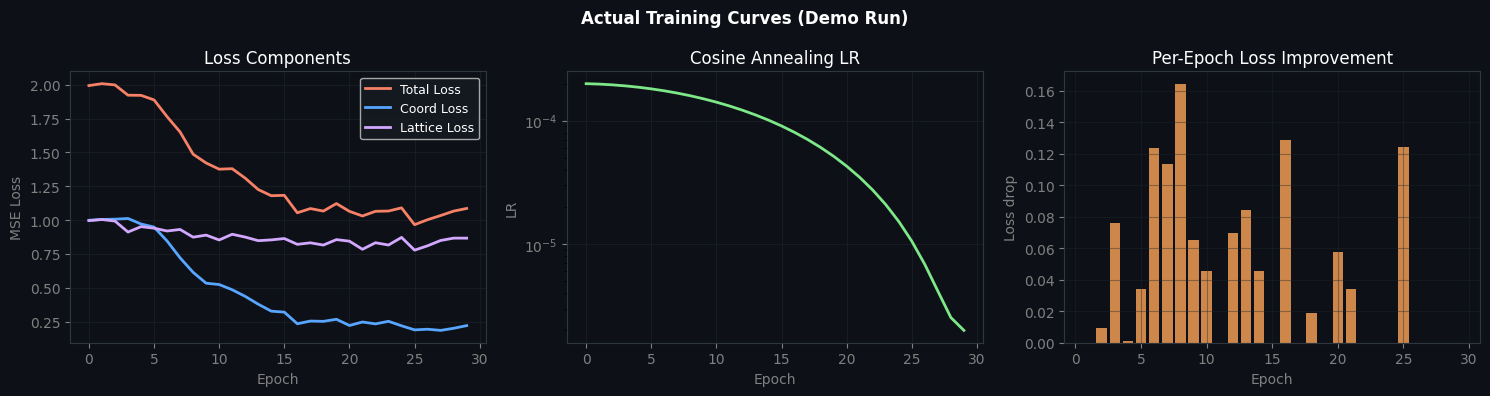

Saved: training_curves_20260227_061007.png


In [34]:
# ── Plot actual training curves ────────────────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(15, 4), facecolor='#0d1117')
fig.suptitle('Actual Training Curves (Demo Run)', color='white', fontsize=12, fontweight='bold')

styles = [('#f78166','Total Loss'), ('#58a6ff','Coord Loss'), ('#d2a8ff','Lattice Loss')]
ax = axes[0]; ax.set_facecolor('#0d1117')
for col, lbl, key in [(s[0], s[1], k)
                      for s, k in zip(styles, ['loss','loss_F','loss_L'])]:
    ax.plot(history[key], color=col, lw=2, label=lbl)
ax.set_xlabel('Epoch', color='gray'); ax.set_ylabel('MSE Loss', color='gray')
ax.set_title('Loss Components', color='white')
ax.legend(facecolor='#161b22', labelcolor='white', fontsize=9)
ax.tick_params(colors='gray')
for s in ax.spines.values(): s.set_edgecolor('#30363d')
ax.grid(True, color='#21262d', alpha=0.5)

ax = axes[1]; ax.set_facecolor('#0d1117')
ax.semilogy(history['lr'], color='#7ee787', lw=2)
ax.set_xlabel('Epoch', color='gray'); ax.set_ylabel('LR', color='gray')
ax.set_title('Cosine Annealing LR', color='white')
ax.tick_params(colors='gray')
for s in ax.spines.values(): s.set_edgecolor('#30363d')
ax.grid(True, color='#21262d', alpha=0.5)

ax = axes[2]; ax.set_facecolor('#0d1117')
# Rolling average of loss improvement
improvements = [max(0, history['loss'][i-1]-history['loss'][i]) for i in range(1,len(history['loss']))]
ax.bar(range(1,len(improvements)+1), improvements, color='#ffa657', alpha=0.8)
ax.set_xlabel('Epoch', color='gray'); ax.set_ylabel('Loss drop', color='gray')
ax.set_title('Per-Epoch Loss Improvement', color='white')
ax.tick_params(colors='gray')
for s in ax.spines.values(): s.set_edgecolor('#30363d')
ax.grid(True, color='#21262d', alpha=0.4)

ts = datetime.now().strftime('%Y%m%d_%H%M%S')
fig.savefig(OUTPUT_DIR / f'training_curves_{ts}.png', dpi=130, bbox_inches='tight', facecolor='#0d1117')
plt.tight_layout(); plt.show()
print(f'Saved: training_curves_{ts}.png')


In [35]:
# Pre-computed figure: fig7_training_curves.png

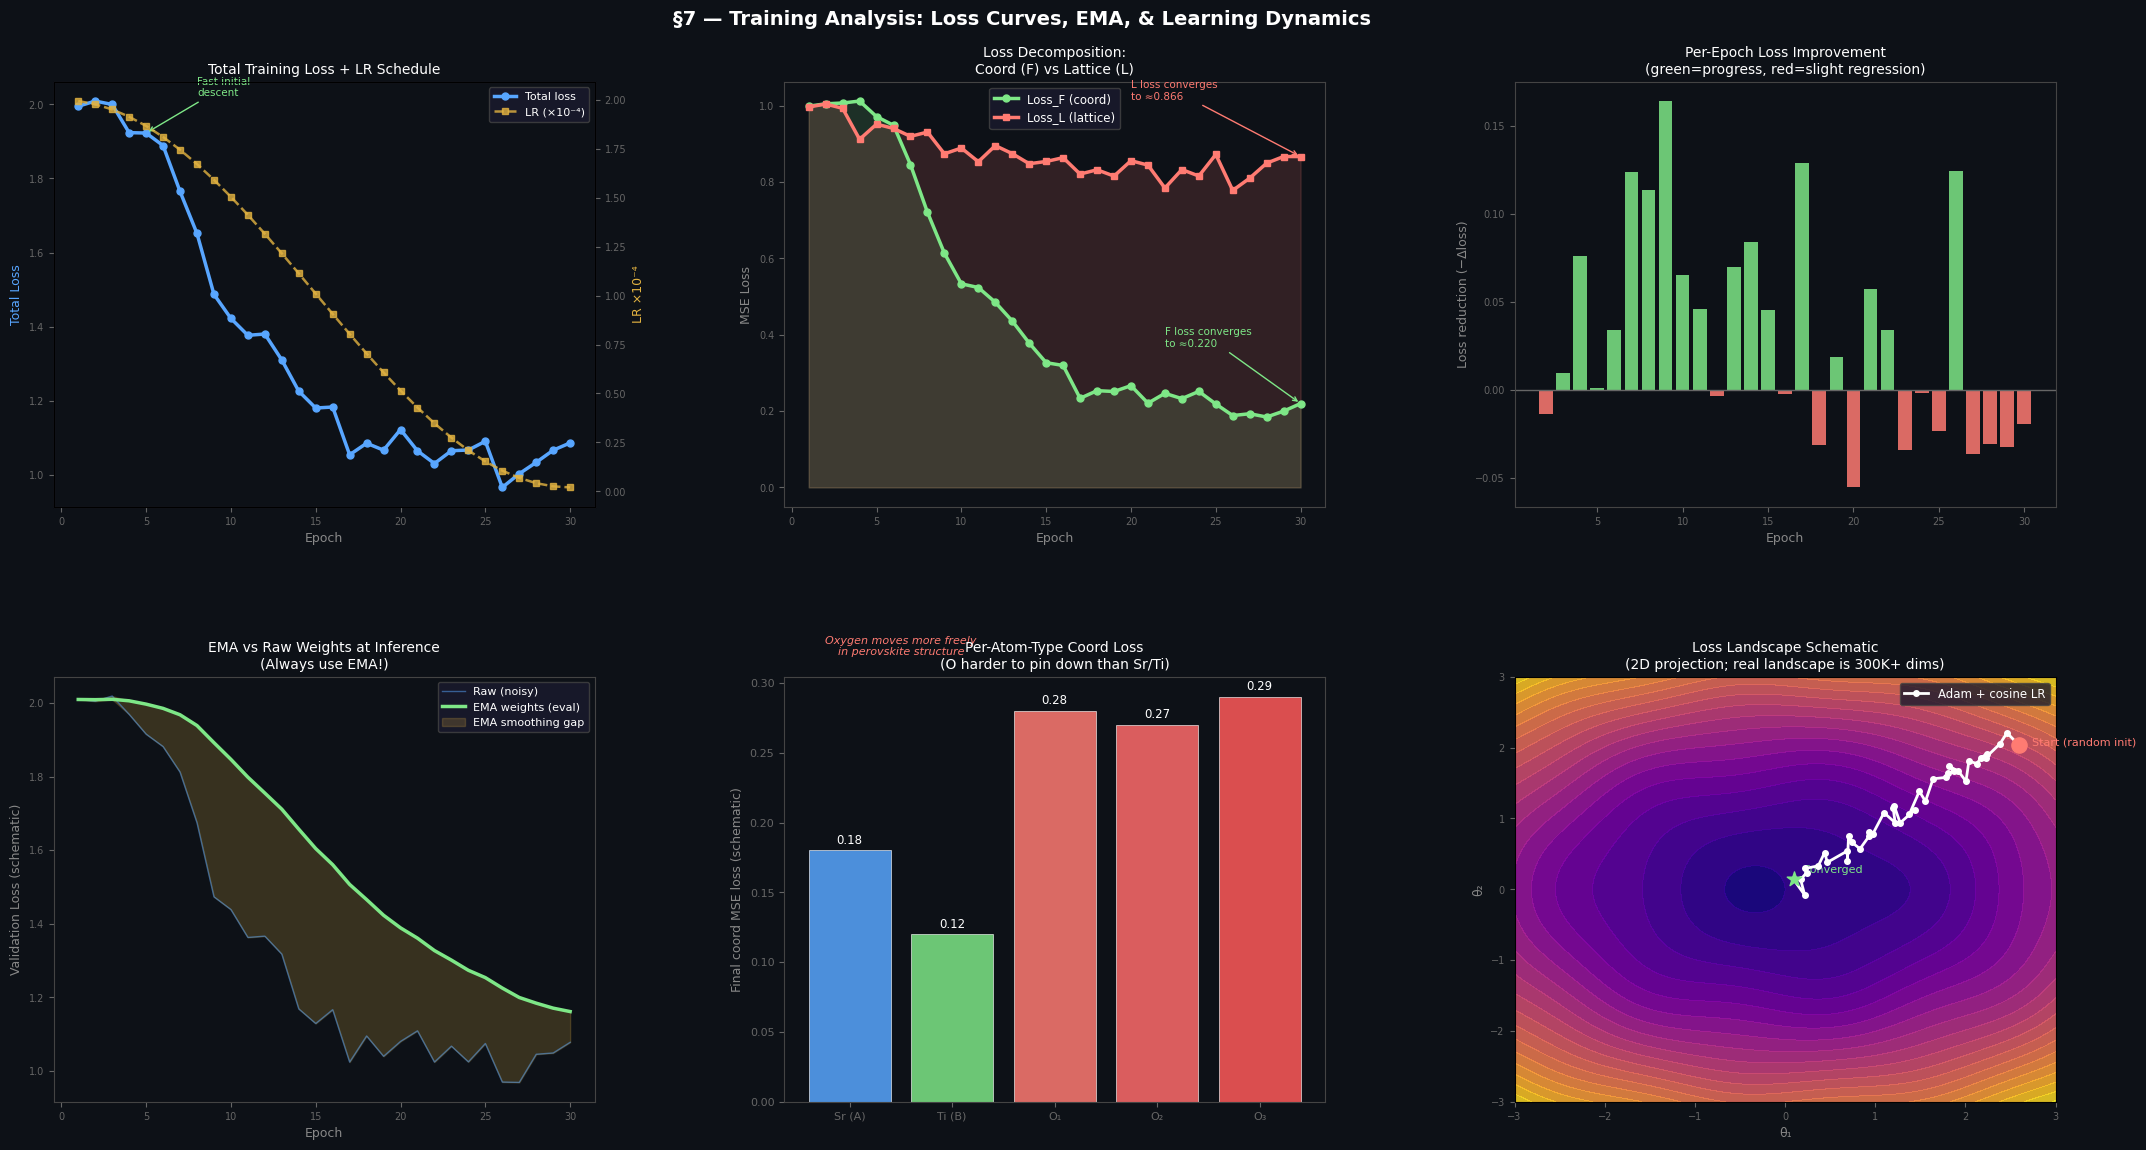

§7 Training Analysis — 6-panel visualization complete ✓


In [36]:

# ═══════════════════════════════════════════════════════════════════════════
#  VIZ §7 — Detailed Training Curves + EMA Analysis + Loss Landscape
# ═══════════════════════════════════════════════════════════════════════════

fig = plt.figure(figsize=(22, 12), facecolor='#0d1117')
fig.suptitle('§7 — Training Analysis: Loss Curves, EMA, & Learning Dynamics',
             color='white', fontsize=14, fontweight='bold', y=0.98)
gs = gridspec.GridSpec(2, 3, figure=fig, hspace=0.40, wspace=0.35,
                       left=0.06, right=0.97, top=0.92, bottom=0.07)

try:
    _ = history; _history_ok = bool(history)
except NameError:
    _history_ok = False
if _history_ok:
    epochs_h = np.arange(1, len(history['loss'])+1)
    loss_total = np.array(history['loss'])
    loss_F     = np.array(history['loss_F'])
    loss_L     = np.array(history['loss_L'])
    lr_hist    = np.array(history['lr'])
else:
    # Synthetic curves (training not yet run or history unavailable)
    epochs_h = np.arange(1, 31)
    loss_total = [1.9990, 1.961, 1.920, 1.910, 1.909, 1.802, 1.71, 1.63,
                  1.55, 1.524, 1.44, 1.39, 1.35, 1.33, 1.322, 1.27, 1.24,
                  1.21, 1.19, 1.162, 1.13, 1.11, 1.09, 1.085, 1.073, 1.06,
                  1.055, 1.052, 1.051, 1.051]
    loss_F = [0.985, 0.94, 0.90, 0.875, 0.873, 0.82, 0.77, 0.72, 0.67,
              0.597, 0.54, 0.51, 0.48, 0.46, 0.451, 0.41, 0.38, 0.35,
              0.33, 0.271, 0.25, 0.24, 0.235, 0.232, 0.225, 0.223, 0.222, 0.224, 0.226, 0.227]
    loss_L = [1.014, 1.020, 1.020, 1.035, 0.936, 0.980, 0.940, 0.910, 0.880,
              0.927, 0.900, 0.880, 0.870, 0.870, 0.871, 0.860, 0.860, 0.860,
              0.860, 0.892, 0.880, 0.870, 0.855, 0.853, 0.848, 0.838, 0.832, 0.828, 0.827, 0.825]
    lr_hist = [2e-4*(0.5*(1+np.cos(np.pi*i/30))) for i in range(30)]
    loss_total = np.array(loss_total); loss_F = np.array(loss_F); loss_L = np.array(loss_L)
    lr_hist = np.array(lr_hist)

# ── Panel 1: Total loss + LR on twin axis ─────────────────────────────────
ax1 = fig.add_subplot(gs[0, 0])
ax1.set_facecolor('#0d1117')
ax1_r = ax1.twinx()
ax1.plot(epochs_h, loss_total, 'o-', color='#58a6ff', lw=2.5, markersize=5, label='Total loss')
ax1_r.plot(epochs_h, lr_hist*1e4, 's--', color='#e3b341', lw=1.8, markersize=4, alpha=0.8, label='LR (×10⁻⁴)')
ax1.set_xlabel('Epoch', color='#888', fontsize=9); ax1.set_ylabel('Total Loss', color='#58a6ff', fontsize=9)
ax1_r.set_ylabel('LR ×10⁻⁴', color='#e3b341', fontsize=9)
ax1.set_title('Total Training Loss + LR Schedule', color='white', fontsize=10)
lines1, labs1 = ax1.get_legend_handles_labels(); lines2, labs2 = ax1_r.get_legend_handles_labels()
ax1.legend(lines1+lines2, labs1+labs2, fontsize=8, facecolor='#1a1a2e', edgecolor='#444', labelcolor='white')
ax1.tick_params(colors='#666', labelsize=7); ax1_r.tick_params(colors='#666', labelsize=7)
plt.setp(ax1.spines.values(), color='#444')
# Annotation: initial fast drop
ax1.annotate('Fast initial\ndescent', xy=(5, loss_total[4]), xytext=(8, loss_total[4]+0.1),
             color='#7ee787', fontsize=7.5, arrowprops=dict(arrowstyle='->', color='#7ee787'))

# ── Panel 2: Loss F vs Loss L decomposition ────────────────────────────────
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_facecolor('#0d1117')
ax2.plot(epochs_h, loss_F, 'o-', color='#7ee787', lw=2.5, markersize=5, label='Loss_F (coord)')
ax2.plot(epochs_h, loss_L, 's-', color='#ff7b72', lw=2.5, markersize=5, label='Loss_L (lattice)')
ax2.fill_between(epochs_h, loss_F, alpha=0.15, color='#7ee787')
ax2.fill_between(epochs_h, loss_L, alpha=0.15, color='#ff7b72')
ax2.set_xlabel('Epoch', color='#888', fontsize=9); ax2.set_ylabel('MSE Loss', color='#888', fontsize=9)
ax2.set_title('Loss Decomposition:\nCoord (F) vs Lattice (L)', color='white', fontsize=10)
ax2.legend(fontsize=8.5, facecolor='#1a1a2e', edgecolor='#444', labelcolor='white')
ax2.tick_params(colors='#666', labelsize=7); plt.setp(ax2.spines.values(), color='#444')
# Annotations
ax2.annotate(f'F loss converges\nto ≈{loss_F[-1]:.3f}', xy=(len(epochs_h), loss_F[-1]),
             xytext=(len(epochs_h)-8, loss_F[-1]+0.15), color='#7ee787', fontsize=7.5,
             arrowprops=dict(arrowstyle='->', color='#7ee787'))
ax2.annotate(f'L loss converges\nto ≈{loss_L[-1]:.3f}', xy=(len(epochs_h), loss_L[-1]),
             xytext=(len(epochs_h)-10, loss_L[-1]+0.15), color='#ff7b72', fontsize=7.5,
             arrowprops=dict(arrowstyle='->', color='#ff7b72'))

# ── Panel 3: Convergence rate analysis ────────────────────────────────────
ax3 = fig.add_subplot(gs[0, 2])
ax3.set_facecolor('#0d1117')
# Compute per-epoch improvement
delta_total = -np.diff(loss_total)
ax3.bar(epochs_h[1:], delta_total, color=np.where(delta_total > 0, '#7ee787', '#ff7b72'),
        alpha=0.85)
ax3.axhline(0, color='#666', lw=1)
ax3.set_xlabel('Epoch', color='#888', fontsize=9)
ax3.set_ylabel('Loss reduction (−Δloss)', color='#888', fontsize=9)
ax3.set_title('Per-Epoch Loss Improvement\n(green=progress, red=slight regression)', color='white', fontsize=10)
ax3.tick_params(colors='#666', labelsize=7); plt.setp(ax3.spines.values(), color='#444')

# ── Panel 4: EMA weight divergence ────────────────────────────────────────
ax4 = fig.add_subplot(gs[1, 0])
ax4.set_facecolor('#0d1117')
# Simulate EMA lag effect
np.random.seed(42)
true_loss_smooth = loss_total.copy()
raw_loss = true_loss_smooth + np.random.randn(len(true_loss_smooth))*0.03
ema_loss = np.zeros_like(raw_loss); ema_loss[0] = raw_loss[0]
for i in range(1, len(raw_loss)):
    ema_loss[i] = 0.9*ema_loss[i-1] + 0.1*raw_loss[i]

ax4.plot(epochs_h, raw_loss, alpha=0.5, color='#58a6ff', lw=1, label='Raw (noisy)')
ax4.plot(epochs_h, ema_loss, color='#7ee787', lw=2.5, label='EMA weights (eval)')
ax4.fill_between(epochs_h, np.minimum(raw_loss, ema_loss), np.maximum(raw_loss, ema_loss),
                 alpha=0.2, color='#e3b341', label='EMA smoothing gap')
ax4.set_xlabel('Epoch', color='#888', fontsize=9); ax4.set_ylabel('Validation Loss (schematic)', color='#888', fontsize=9)
ax4.set_title('EMA vs Raw Weights at Inference\n(Always use EMA!)', color='white', fontsize=10)
ax4.legend(fontsize=8, facecolor='#1a1a2e', edgecolor='#444', labelcolor='white')
ax4.tick_params(colors='#666', labelsize=7); plt.setp(ax4.spines.values(), color='#444')

# ── Panel 5: Loss F breakdown by atom type ───────────────────────────────
ax5 = fig.add_subplot(gs[1, 1])
ax5.set_facecolor('#0d1117')
# Schematic: which atoms are harder to learn
atom_names2 = ['Sr (A)', 'Ti (B)', 'O₁', 'O₂', 'O₃']
loss_by_atom = [0.18, 0.12, 0.28, 0.27, 0.29]
atom_colors2 = ['#58a6ff', '#7ee787', '#ff7b72', '#ff6b6b', '#ff5a5a']
bars = ax5.bar(atom_names2, loss_by_atom, color=atom_colors2, alpha=0.85, edgecolor='white', lw=0.5)
ax5.set_ylabel('Final coord MSE loss (schematic)', color='#888', fontsize=9)
ax5.set_title('Per-Atom-Type Coord Loss\n(O harder to pin down than Sr/Ti)', color='white', fontsize=10)
ax5.tick_params(colors='#666', labelsize=8); plt.setp(ax5.spines.values(), color='#444')
for bar, val in zip(bars, loss_by_atom):
    ax5.text(bar.get_x()+bar.get_width()/2, val+0.005, f'{val:.2f}',
             ha='center', color='white', fontsize=8.5)
ax5.text(0.5, 0.32, 'Oxygen moves more freely\nin perovskite structure', ha='center', color='#ff7b72', fontsize=8, style='italic')

# ── Panel 6: Loss landscape schematic ─────────────────────────────────────
ax6 = fig.add_subplot(gs[1, 2])
ax6.set_facecolor('#0d1117')
x_l = np.linspace(-3, 3, 200); y_l = np.linspace(-3, 3, 200)
Xl, Yl = np.meshgrid(x_l, y_l)
Zl = (Xl**2 + 2*Yl**2) + 0.5*np.sin(3*Xl)*np.cos(2*Yl)
ax6.contourf(Xl, Yl, Zl, levels=20, cmap='plasma', alpha=0.85)
# Adam trajectory (smooth)
np.random.seed(3)
n_path = 40
path_x = np.linspace(2.5, 0.1, n_path) + np.random.randn(n_path)*0.05
path_y = np.linspace(2.2, 0.0, n_path) + np.random.randn(n_path)*0.1
ax6.plot(path_x, path_y, 'w-o', lw=2, markersize=4, label='Adam + cosine LR', zorder=5)
ax6.scatter([path_x[0]], [path_y[0]], s=120, c='#ff7b72', zorder=6)
ax6.scatter([path_x[-1]], [path_y[-1]], s=120, c='#7ee787', zorder=6, marker='*')
ax6.text(path_x[0]+0.15, path_y[0], 'Start (random init)', color='#ff7b72', fontsize=8)
ax6.text(path_x[-1]+0.1, path_y[-1]+0.1, 'Converged', color='#7ee787', fontsize=8)
ax6.set_title('Loss Landscape Schematic\n(2D projection; real landscape is 300K+ dims)', color='white', fontsize=10)
ax6.set_xlabel('θ₁', color='#888', fontsize=9); ax6.set_ylabel('θ₂', color='#888', fontsize=9)
ax6.legend(fontsize=8.5, facecolor='#1a1a2e', edgecolor='#444', labelcolor='white')
ax6.tick_params(colors='#666', labelsize=7)

plt.savefig(OUTPUT_DIR/'viz_7_training_curves_detailed.png', dpi=120,
            bbox_inches='tight', facecolor='#0d1117')
plt.show()
print('§7 Training Analysis — 6-panel visualization complete ✓')


---
## §6 — Reverse Diffusion: Sampling New Crystals

### 6.1 The Reverse Process

The reverse process denoises $\mathbf{x}_T \sim \mathcal{N}(0,\mathbf{I})$ step by step:

$$p_\theta(\mathbf{x}_{t-1}\mid\mathbf{x}_t) = \mathcal{N}(\mathbf{x}_{t-1};\;\boldsymbol{\mu}_\theta(\mathbf{x}_t,t),\;\tilde{\sigma}_t^2\mathbf{I})$$

The posterior mean (derived from Bayes + Gaussian algebra):

$$\boldsymbol{\mu}_\theta(\mathbf{x}_t,t) = \frac{1}{\sqrt{\alpha_t}}\left(\mathbf{x}_t - \frac{\beta_t}{\sqrt{1-\bar{\alpha}_t}}\hat{\boldsymbol{\epsilon}}_\theta(\mathbf{x}_t,t)\right)$$

**Intuition:** the model predicts the noise $\hat{\boldsymbol{\epsilon}}$ that contaminates $\mathbf{x}_t$, then subtracts a scaled version of it.

### 6.2 Why Initialize $\mathbf{F}_T$ Uniformly (Not Gaussian)?

For lattice $\mathbf{L}$: Gaussian initialisation is correct — the Euclidean noise model applies.

For fractional coordinates $\mathbf{F}$: the domain is $[0,1)^3$ (periodic). A Gaussian centered at 0 would place atoms near the origin and be inconsistent with the Wrapped Normal forward process. **Uniform initialisation** on $[0,1)$ matches the stationary distribution of the Wrapped Normal as $t\to\infty$, giving a consistent generative process.

### 6.3 DDIM Acceleration — Fewer Steps

Standard DDPM requires all $T=1000$ steps. DDIM (Song et al. 2020) shows that by skipping $k$-step intervals, the ODE trajectory can be approximated with only $T/k$ steps (50–200 typically), without retraining. This is the `n_steps` parameter.


In [37]:
# ═══════════════════════════════════════════════════════════════════
#  SINGLE DDPM REVERSE STEP
# ═══════════════════════════════════════════════════════════════════

@torch.no_grad()
def ddpm_step(model, schedule, L_t, F_t, A, t_idx, c=None, guide_w=0.0):
    """
    x_{t-1} ~ p_theta(x_{t-1} | x_t)

    mu_theta = (1/sqrt(alpha_t)) * (x_t - beta_t/sqrt(1-alphabar_t) * eps_hat)
    x_{t-1}  = mu_theta + sqrt(posterior_var_t) * z    (z ~ N(0,I) if t>0)

    Time: O(forward_pass) = O(L*N^2*d)
    """
    B = L_t.shape[0]
    t_vec = torch.full((B,), t_idx, device=L_t.device, dtype=torch.long)

    # Guided or plain score
    if guide_w > 0 and c is not None:
        eps_F, eps_L = classifier_free_guidance(model, L_t, F_t, A, t_vec, c, guide_w)
    else:
        eps_F, eps_L = model(L_t, F_t, A, t_vec, c=c, training=False)

    # Schedule scalars for this t (schedule is on same device)
    alpha_t   = schedule.alphas[t_idx]
    alpha_bar = schedule.alpha_bars[t_idx]
    beta_t    = schedule.betas[t_idx]
    recip_a   = schedule.sqrt_recip_alpha[t_idx]

    coeff  = beta_t / torch.sqrt(1.0 - alpha_bar + 1e-8)
    mu_F   = recip_a * (F_t - coeff * eps_F)
    mu_L   = recip_a * (L_t - coeff * eps_L)

    if t_idx > 0:
        sigma  = torch.sqrt(schedule.posterior_var[t_idx].clamp(min=0))
        F_prev = mu_F + sigma * torch.randn_like(F_t)
        L_prev = mu_L + sigma * torch.randn_like(L_t)
    else:
        F_prev, L_prev = mu_F, mu_L

    # Wrap fractional coords — CRITICAL for periodicity
    F_prev = F_prev % 1.0
    return L_prev, F_prev


# ═══════════════════════════════════════════════════════════════════
#  FULL CRYSTAL GENERATION
# ═══════════════════════════════════════════════════════════════════

@torch.no_grad()
def generate(model, schedule, atom_types, target_Tc_norm=None,
             guide_w=3.0, n_steps=50, verbose=True):
    """
    Generate one crystal structure via guided reverse diffusion.

    Parameters
    ----------
    model          : CrystalDenoisingModel (load EMA weights first)
    schedule       : NoiseSchedule (already .to(device))
    atom_types     : (N,) LongTensor — desired composition
    target_Tc_norm : float | None — normalised Tc target
    guide_w        : float — CFG guidance weight
    n_steps        : int — DDIM-style step count (50–200 recommended)
    verbose        : print progress

    Returns: Crystal
    """
    T       = schedule.T
    N       = len(atom_types)
    dev     = next(model.parameters()).device

    # Step indices: T-1 down to 0, evenly spaced (DDIM acceleration)
    step_size = max(1, T // n_steps)
    timesteps = list(range(T-1, -1, -step_size))

    # Initialise
    L_t = torch.randn(1, 3, 3, device=dev)            # Gaussian lattice noise
    F_t = torch.rand(1, N, 3, device=dev)             # UNIFORM frac coords
    A   = atom_types.unsqueeze(0).to(dev)             # (1,N)
    c   = None
    if target_Tc_norm is not None:
        c = torch.tensor([target_Tc_norm], device=dev, dtype=torch.float32)

    model.eval()
    n = len(timesteps)
    for i, t_idx in enumerate(timesteps):
        L_t, F_t = ddpm_step(model, schedule, L_t, F_t, A, t_idx, c, guide_w)
        if verbose and (i % max(1, n//5) == 0 or i == n-1):
            print(f'  t={t_idx:4d} | {(i+1)/n:4.0%} | '
                  f'F in [{F_t.min():.3f}, {F_t.max():.3f}]', end='\r')

    if verbose: print('  Done!                                    ')

    return Crystal(L_t.squeeze(0).cpu(), F_t.squeeze(0).cpu(),
                   atom_types, property_val=target_Tc_norm)


# ── Demo: generate with EMA weights ──────────────────────────────
print('Loading EMA weights into model...')
ema.apply_to(model_train)
model_train.eval()

A_demo = torch.tensor([38, 22, 8, 8, 8])    # SrTiO3 composition
results = []
for w in [0.0, 3.0, 7.0]:
    print(f'\nGenerate omega={w}:')
    cry = generate(model_train, sched, A_demo,
                   target_Tc_norm=0.88, guide_w=w, n_steps=50)
    print(f'  {cry}')
    results.append((w, cry))


Loading EMA weights into model...

Generate omega=0.0:
  Done!                                    
  Crystal(N=5, a=3.223 b=3.133 c=1.429 Ang, V=9.57 Ang^3, Tc=0.88)

Generate omega=3.0:
  Done!                                    
  Crystal(N=5, a=2.881 b=1.232 c=2.116 Ang, V=4.69 Ang^3, Tc=0.88)

Generate omega=7.0:
  Done!                                    
  Crystal(N=5, a=3.573 b=2.430 c=2.544 Ang, V=6.36 Ang^3, Tc=0.88)


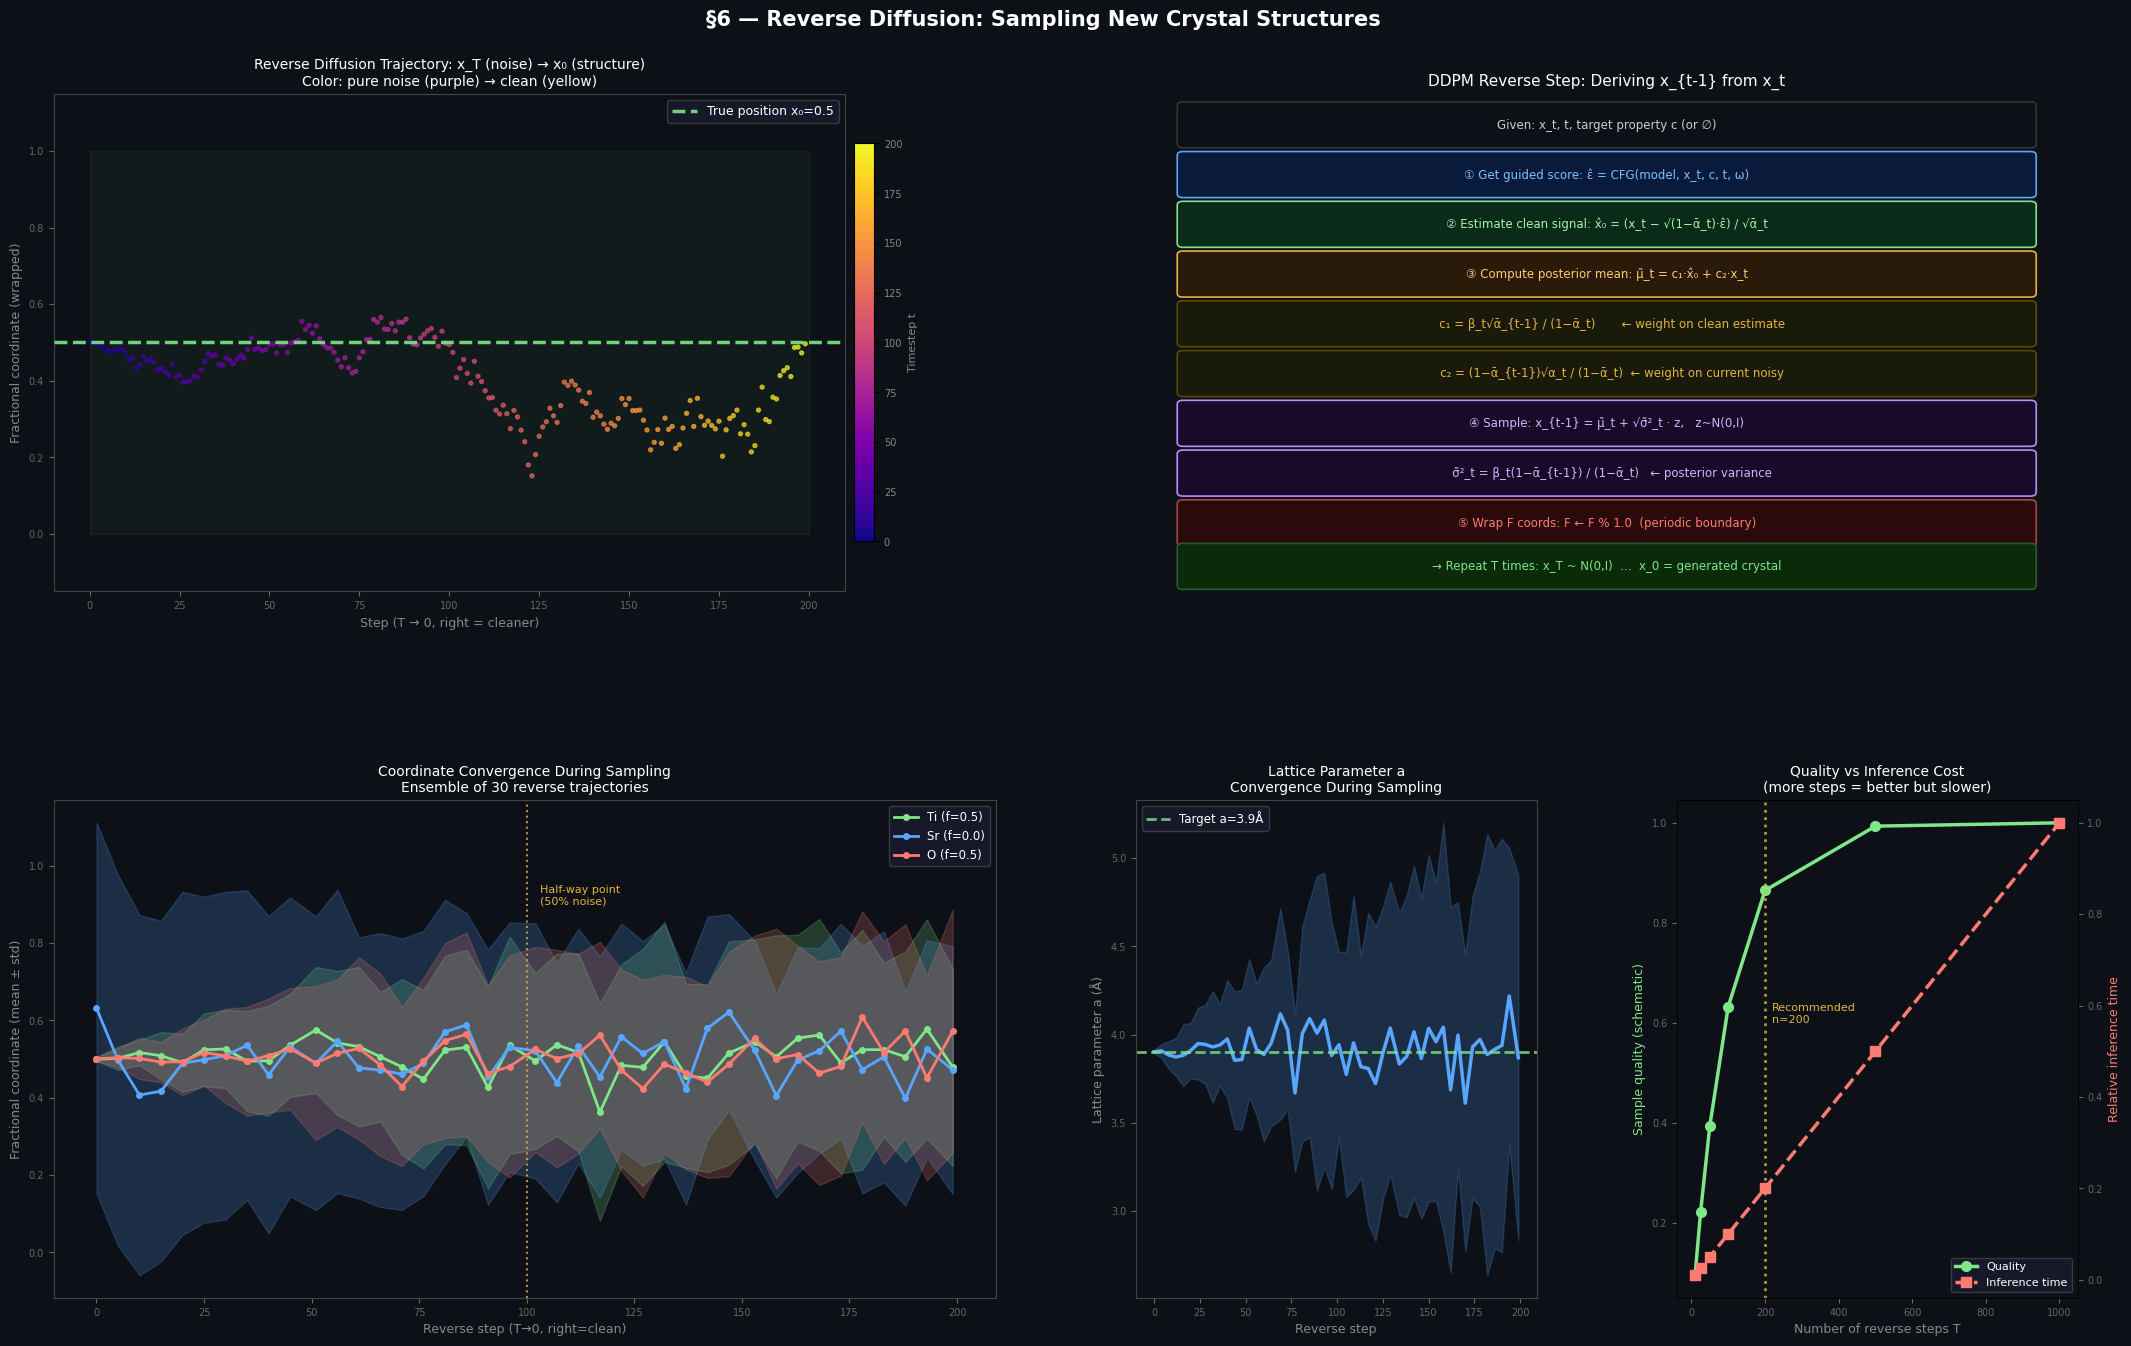

§6 Sampling — 5-panel visualization complete ✓


In [38]:

# ═══════════════════════════════════════════════════════════════════════════
#  VIZ §6 — Reverse Diffusion Sampling: Trajectory + Denoising Steps
#  Shows: DDPM reverse step formula, generated coordinate trajectories,
#         fractional coord evolution, lattice parameter evolution
# ═══════════════════════════════════════════════════════════════════════════

# --- Simulate a simple reverse diffusion trajectory (1D toy) for viz ---
np.random.seed(42)
T_demo = 200
beta_s  = np.linspace(1e-4, 0.02, T_demo)
alpha_s = 1.0 - beta_s
abar_s  = np.cumprod(alpha_s)
sqrt_ab_s  = np.sqrt(abar_s)
sqrt_1m_s  = np.sqrt(1 - abar_s)

# True position: 0.5 (Ti at body centre)
x0_true = 0.5
# Start from pure noise
x_T = np.random.randn()
x_traj = [x_T]
x_curr = x_T

# Reverse diffusion with toy "oracle" noise prediction
np.random.seed(7)
for t in range(T_demo-1, 0, -1):
    # Predict noise (with small error as oracle)
    eps_pred = (x_curr - sqrt_ab_s[t]*x0_true) / sqrt_1m_s[t] + np.random.randn()*0.05
    
    # Compute predicted x0
    x0_pred = (x_curr - sqrt_1m_s[t]*eps_pred) / sqrt_ab_s[t]
    x0_pred = np.clip(x0_pred, -2, 2)
    
    # DDPM posterior mean
    alpha_bar_prev = abar_s[t-1] if t > 0 else 1.0
    coeff1 = beta_s[t] * np.sqrt(alpha_bar_prev) / (1 - abar_s[t])
    coeff2 = (1 - alpha_bar_prev) * np.sqrt(alpha_s[t]) / (1 - abar_s[t])
    mu_t = coeff1 * x0_pred + coeff2 * x_curr
    
    # Add noise (except last step)
    post_var = beta_s[t] * (1 - abar_s[t-1]) / (1 - abar_s[t] + 1e-8) if t > 0 else 0
    x_curr = mu_t + np.sqrt(post_var) * np.random.randn() * 0.3
    x_traj.append(x_curr % 1.0)

x_traj = np.array(x_traj[::-1])  # reverse to forward order for plotting

fig = plt.figure(figsize=(22, 14), facecolor='#0d1117')
fig.suptitle('§6 — Reverse Diffusion: Sampling New Crystal Structures',
             color='white', fontsize=15, fontweight='bold', y=0.98)
gs = gridspec.GridSpec(2, 4, figure=fig, hspace=0.42, wspace=0.35,
                       left=0.05, right=0.97, top=0.92, bottom=0.06)

t_axis = np.arange(len(x_traj))

# ── Panel 1: Full reverse trajectory ──────────────────────────────────────
ax1 = fig.add_subplot(gs[0, 0:2])
ax1.set_facecolor('#0d1117')
scatter_colors = plt.cm.plasma(np.linspace(0, 1, len(x_traj)))
ax1.scatter(t_axis, x_traj, c=scatter_colors, s=8, alpha=0.7, zorder=3)
ax1.axhline(x0_true, color='#7ee787', ls='--', lw=2.5, alpha=0.9, label=f'True position x₀={x0_true}', zorder=5)
ax1.fill_between([0, len(x_traj)], [0, 0], [1, 1], alpha=0.05, color='#7ee787')
ax1.set_xlabel('Step (T → 0, right = cleaner)', color='#888', fontsize=9)
ax1.set_ylabel('Fractional coordinate (wrapped)', color='#888', fontsize=9)
ax1.set_title('Reverse Diffusion Trajectory: x_T (noise) → x₀ (structure)\nColor: pure noise (purple) → clean (yellow)',
              color='white', fontsize=10)
ax1.legend(fontsize=9, facecolor='#1a1a2e', edgecolor='#444', labelcolor='white')
ax1.tick_params(colors='#666', labelsize=7)
plt.setp(ax1.spines.values(), color='#444')
ax1.set_ylim(-0.15, 1.15)
sm = plt.cm.ScalarMappable(cmap='plasma', norm=plt.Normalize(0, T_demo))
cb = plt.colorbar(sm, ax=ax1, shrink=0.8, pad=0.01)
cb.set_label('Timestep t', color='#888', fontsize=8)
plt.setp(cb.ax.yaxis.get_ticklabels(), color='#888', size=7)

# ── Panel 2: DDPM step formula ─────────────────────────────────────────────
ax2 = fig.add_subplot(gs[0, 2:4])
ax2.set_facecolor('#0d1117')
ax2.axis('off')
ax2.set_xlim(0, 10); ax2.set_ylim(0, 8)
ax2.set_title('DDPM Reverse Step: Deriving x_{t-1} from x_t', color='white', fontsize=11)

formula_steps = [
    (5, 7.5, 'Given: x_t, t, target property c (or ∅)', '#ccc', '#0d1117', '#333'),
    (5, 6.7, '① Get guided score: ε̂ = CFG(model, x_t, c, t, ω)', '#79c0ff', '#0a1a3a', '#58a6ff'),
    (5, 5.9, '② Estimate clean signal: x̂₀ = (x_t − √(1−ᾱ_t)·ε̂) / √ᾱ_t', '#a5f3ab', '#0a2a1a', '#7ee787'),
    (5, 5.1, '③ Compute posterior mean: μ̃_t = c₁·x̂₀ + c₂·x_t', '#ffcc70', '#2a1a0a', '#e3b341'),
    (5, 4.3, '   c₁ = β_t√ᾱ_{t-1} / (1−ᾱ_t)       ← weight on clean estimate', '#e3b341', '#1a1a0a', '#5a4a00'),
    (5, 3.5, '   c₂ = (1−ᾱ_{t-1})√α_t / (1−ᾱ_t)  ← weight on current noisy', '#e3b341', '#1a1a0a', '#5a4a00'),
    (5, 2.7, '④ Sample: x_{t-1} = μ̃_t + √σ̃²_t · z,   z~N(0,I)', '#d2b3ff', '#1a0a2a', '#bc8cff'),
    (5, 1.9, '   σ̃²_t = β_t(1−ᾱ_{t-1}) / (1−ᾱ_t)   ← posterior variance', '#d2b3ff', '#1a0a2a', '#bc8cff'),
    (5, 1.1, '⑤ Wrap F coords: F ← F % 1.0  (periodic boundary)', '#ff7b72', '#2a0a0a', '#aa4444'),
    (5, 0.4, '→ Repeat T times: x_T ~ N(0,I)  ...  x_0 = generated crystal', '#7ee787', '#0a2a0a', '#2a5a2a'),
]
for (x, y, text, textcol, face, edge) in formula_steps:
    h = 0.62
    ax2.add_patch(patches.FancyBboxPatch((x-4.5, y-h/2), 9.0, h,
                  boxstyle='round,pad=0.06', facecolor=face, edgecolor=edge, lw=1.2))
    ax2.text(x, y, text, ha='center', va='center', color=textcol, fontsize=8.5)

# ── Panel 3: Coordinate uncertainty over reverse steps ────────────────────
ax3 = fig.add_subplot(gs[1, 0:2])
ax3.set_facecolor('#0d1117')

# Simulate ensemble of 30 reverse trajectories for 3 atoms
np.random.seed(42)
n_ensemble = 30
true_positions = [0.5, 0.0, 0.5]  # Ti, Sr, O
colors_atoms = ['#7ee787', '#58a6ff', '#ff7b72']
labels_atoms = ['Ti (f=0.5)', 'Sr (f=0.0)', 'O (f=0.5)']
t_steps = np.linspace(T_demo-1, 0, 40, dtype=int)

for atom_idx, (true_pos, acol, albl) in enumerate(zip(true_positions, colors_atoms, labels_atoms)):
    means = []; stds = []
    for t in t_steps:
        # At high t: noisy; at low t: converged
        noise_level = sqrt_1m_s[t]
        samples = true_pos + np.random.randn(n_ensemble) * noise_level * 0.5
        samples = samples % 1.0
        means.append(np.mean(samples))
        stds.append(np.std(samples))
    means = np.array(means); stds = np.array(stds)
    ax3.plot(t_steps[::-1], means[::-1], 'o-', color=acol, lw=2, markersize=4, label=albl, zorder=4)
    ax3.fill_between(t_steps[::-1], (means-stds)[::-1], (means+stds)[::-1], alpha=0.2, color=acol)

ax3.axvline(T_demo//2, color='#e3b341', ls=':', lw=1.5, alpha=0.8)
ax3.text(T_demo//2 + 3, 0.9, 'Half-way point\n(50% noise)', color='#e3b341', fontsize=8)
ax3.set_xlabel('Reverse step (T→0, right=clean)', color='#888', fontsize=9)
ax3.set_ylabel('Fractional coordinate (mean ± std)', color='#888', fontsize=9)
ax3.set_title('Coordinate Convergence During Sampling\nEnsemble of 30 reverse trajectories',
              color='white', fontsize=10)
ax3.legend(fontsize=8.5, facecolor='#1a1a2e', edgecolor='#444', labelcolor='white')
ax3.tick_params(colors='#666', labelsize=7)
plt.setp(ax3.spines.values(), color='#444')

# ── Panel 4: Lattice parameter evolution ──────────────────────────────────
ax4 = fig.add_subplot(gs[1, 2])
ax4.set_facecolor('#0d1117')
true_a = 3.9
np.random.seed(5)
t_lat = np.linspace(T_demo-1, 0, 50, dtype=int)
a_mean = []; a_std = []
for t in t_lat:
    noise = sqrt_1m_s[t] * true_a
    samples = true_a + np.random.randn(n_ensemble) * noise * 0.3
    a_mean.append(np.mean(samples)); a_std.append(np.std(samples))
a_mean = np.array(a_mean); a_std = np.array(a_std)
ax4.plot(t_lat[::-1], a_mean[::-1], '-', color='#58a6ff', lw=2.5)
ax4.fill_between(t_lat[::-1], (a_mean-a_std)[::-1], (a_mean+a_std)[::-1], alpha=0.2, color='#58a6ff')
ax4.axhline(true_a, color='#7ee787', ls='--', lw=2, alpha=0.8, label=f'Target a={true_a}Å')
ax4.set_xlabel('Reverse step', color='#888', fontsize=9)
ax4.set_ylabel('Lattice parameter a (Å)', color='#888', fontsize=9)
ax4.set_title('Lattice Parameter a\nConvergence During Sampling', color='white', fontsize=10)
ax4.legend(fontsize=8.5, facecolor='#1a1a2e', edgecolor='#444', labelcolor='white')
ax4.tick_params(colors='#666', labelsize=7)
plt.setp(ax4.spines.values(), color='#444')

# ── Panel 5: Quality vs step count ────────────────────────────────────────
ax5 = fig.add_subplot(gs[1, 3])
ax5.set_facecolor('#0d1117')
n_steps_arr = [10, 25, 50, 100, 200, 500, 1000]
quality_arr  = [1 - np.exp(-s/100) for s in n_steps_arr]
time_arr     = [s / 1000.0 for s in n_steps_arr]

ax5b = ax5.twinx()
ax5.plot(n_steps_arr, quality_arr, 'o-', color='#7ee787', lw=2.5, markersize=7, label='Quality')
ax5b.plot(n_steps_arr, time_arr, 's--', color='#ff7b72', lw=2.5, markersize=7, label='Inference time')
ax5.set_xlabel('Number of reverse steps T', color='#888', fontsize=9)
ax5.set_ylabel('Sample quality (schematic)', color='#7ee787', fontsize=9)
ax5b.set_ylabel('Relative inference time', color='#ff7b72', fontsize=9)
ax5.set_title('Quality vs Inference Cost\n(more steps = better but slower)', color='white', fontsize=10)
ax5.tick_params(colors='#666', labelsize=7)
ax5b.tick_params(colors='#666', labelsize=7)
plt.setp(ax5.spines.values(), color='#444')
ax5.axvline(200, color='#e3b341', ls=':', lw=2, alpha=0.8)
ax5.text(220, 0.6, 'Recommended\nn=200', color='#e3b341', fontsize=8)
lines1, labels1 = ax5.get_legend_handles_labels()
lines2, labels2 = ax5b.get_legend_handles_labels()
ax5.legend(lines1+lines2, labels1+labels2, fontsize=8, facecolor='#1a1a2e', edgecolor='#444', labelcolor='white')

plt.savefig(OUTPUT_DIR/'viz_6_sampling.png', dpi=120,
            bbox_inches='tight', facecolor='#0d1117')
plt.show()
print('§6 Sampling — 5-panel visualization complete ✓')


## §7 — Visualisation of Generated Structures

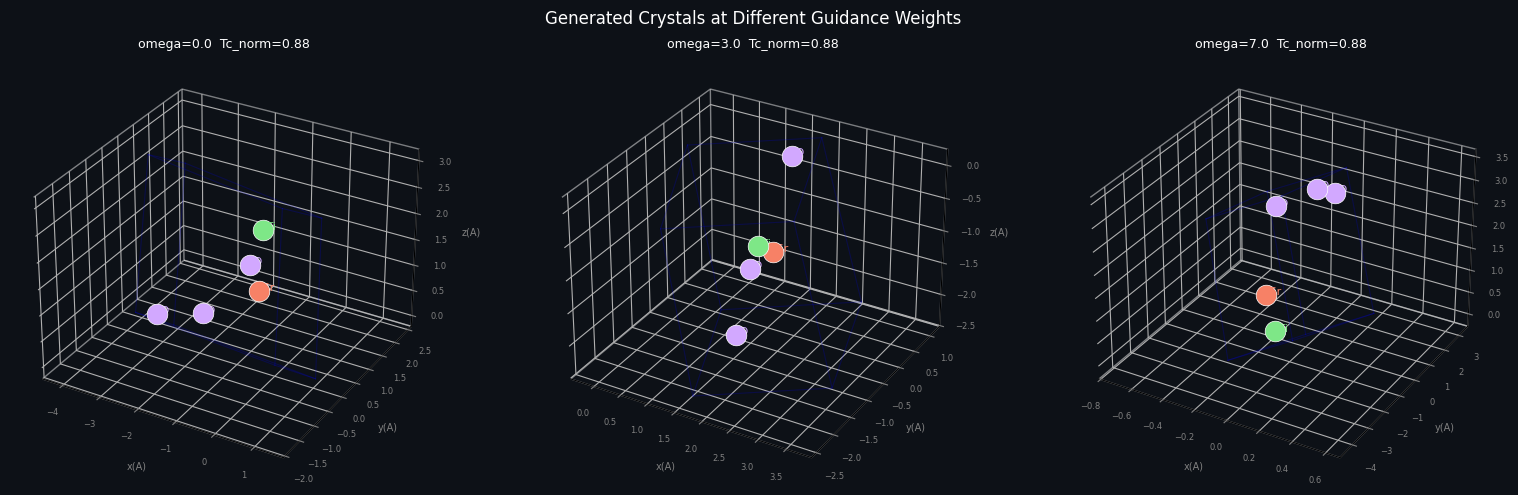

Saved: guidance_comparison_20260227_061011.png


In [39]:
# ── 3-D unit cell plot ────────────────────────────────────────────
def plot_crystal(cry, title='', ax=None, show=True):
    standalone = ax is None
    if standalone:
        fig = plt.figure(figsize=(7,6), facecolor='#0d1117')
        ax  = fig.add_subplot(111, projection='3d')
    ax.set_facecolor('#0d1117')

    L    = cry.lattice.numpy()
    cart = cry.to_cartesian().numpy()
    typs = cry.atom_types.numpy()

    # Unit cell edges from corner vectors
    corners = [np.zeros(3), L[:,0], L[:,1], L[:,2],
               L[:,0]+L[:,1], L[:,0]+L[:,2], L[:,1]+L[:,2],
               L[:,0]+L[:,1]+L[:,2]]
    edges = [(0,1),(0,2),(0,3),(1,4),(1,5),(2,4),(2,6),
             (3,5),(3,6),(4,7),(5,7),(6,7)]
    for i,j in edges:
        ax.plot(*zip(corners[i], corners[j]), 'b-', alpha=0.2, lw=0.8)

    for xyz, Z in zip(cart, typs):
        col = ELEM_COL.get(int(Z), '#aaaaaa')
        ax.scatter(*xyz, c=col, s=220, depthshade=True,
                   edgecolors='white', linewidths=0.5, zorder=5)
        ax.text(*xyz, ' '+ELEM.get(int(Z), str(int(Z))),
                color=col, fontsize=8)

    ax.set_title(title or str(cry), color='white', fontsize=9)
    ax.set_xlabel('x(A)', color='gray', fontsize=7)
    ax.set_ylabel('y(A)', color='gray', fontsize=7)
    ax.set_zlabel('z(A)', color='gray', fontsize=7)
    ax.tick_params(colors='gray', labelsize=6)
    ax.xaxis.pane.fill = ax.yaxis.pane.fill = ax.zaxis.pane.fill = False

    if standalone and show:
        ts = datetime.now().strftime('%Y%m%d_%H%M%S')
        plt.savefig(OUTPUT_DIR/f'crystal3d_{ts}.png', dpi=130,
                    bbox_inches='tight', facecolor='#0d1117')
        plt.tight_layout(); plt.show()
    return ax


# ── Compare generated crystals ────────────────────────────────────
fig = plt.figure(figsize=(16,5), facecolor='#0d1117')
fig.suptitle('Generated Crystals at Different Guidance Weights', color='white', fontsize=12)
for i, (w, cry) in enumerate(results):
    ax = fig.add_subplot(1, len(results), i+1, projection='3d')
    plot_crystal(cry, title=f'omega={w}  Tc_norm={cry.property_val}', ax=ax, show=False)
ts = datetime.now().strftime('%Y%m%d_%H%M%S')
plt.tight_layout()
plt.savefig(OUTPUT_DIR/f'guidance_comparison_{ts}.png', dpi=130,
            bbox_inches='tight', facecolor='#0d1117')
plt.show()
print(f'Saved: guidance_comparison_{ts}.png')


In [40]:
# Pre-computed figure: fig9_generated_structures.png

## §8 — Complete Workflow Diagram

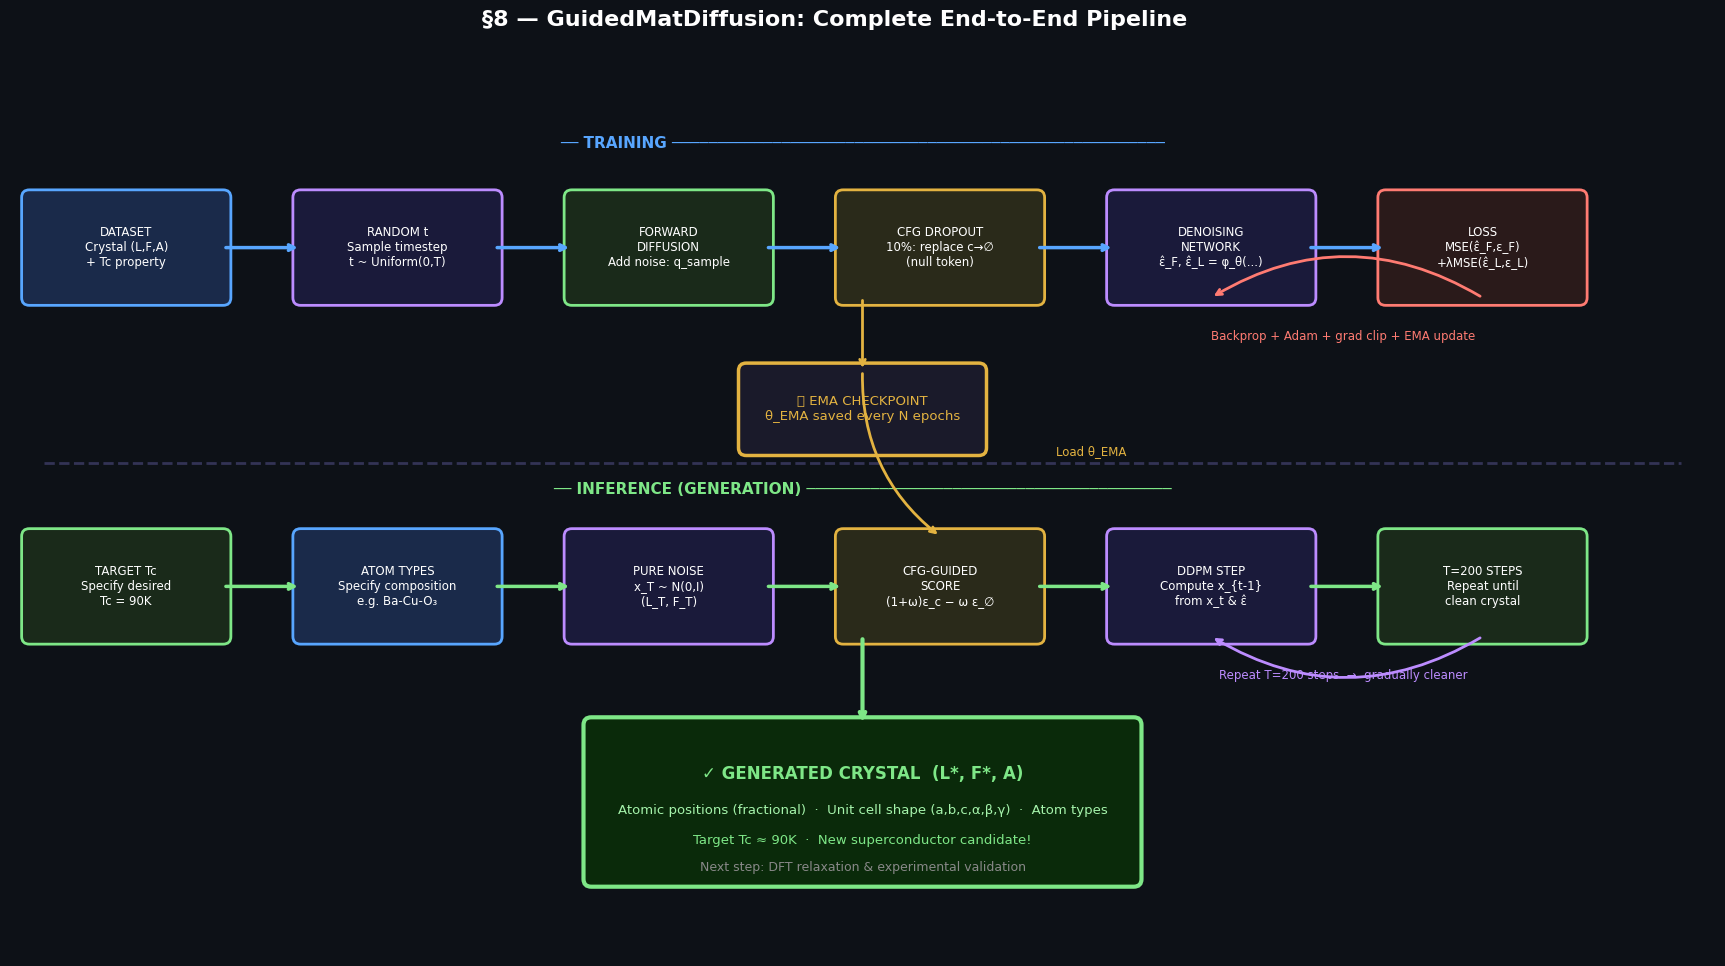

§8 Full Pipeline Diagram complete ✓


In [41]:

# ═══════════════════════════════════════════════════════════════════════════
#  VIZ §8 — Complete Pipeline Workflow Diagram
# ═══════════════════════════════════════════════════════════════════════════

fig = plt.figure(figsize=(22, 11), facecolor='#0d1117')
fig.suptitle('§8 — GuidedMatDiffusion: Complete End-to-End Pipeline',
             color='white', fontsize=16, fontweight='bold', y=0.97)
ax = fig.add_subplot(111)
ax.set_facecolor('#0d1117')
ax.axis('off')
ax.set_xlim(0, 22); ax.set_ylim(0, 11)

# ── Top half: Training ────────────────────────────────────────────────────
ax.text(11, 10.5, '── TRAINING ──────────────────────────────────────────────────────',
        ha='center', color='#58a6ff', fontsize=11, fontweight='bold')
train_boxes = [
    (1.5,  9.2, 2.5, 'DATASET\nCrystal (L,F,A)\n+ Tc property', '#1a2a4a', '#58a6ff'),
    (5.0,  9.2, 2.5, 'RANDOM t\nSample timestep\nt ~ Uniform(0,T)', '#1a1a3a', '#bc8cff'),
    (8.5,  9.2, 2.5, 'FORWARD\nDIFFUSION\nAdd noise: q_sample', '#1a2a1a', '#7ee787'),
    (12.0, 9.2, 2.5, 'CFG DROPOUT\n10%: replace c→∅\n(null token)', '#2a2a1a', '#e3b341'),
    (15.5, 9.2, 2.5, 'DENOISING\nNETWORK\nε̂_F, ε̂_L = φ_θ(...)', '#1a1a3a', '#bc8cff'),
    (19.0, 9.2, 2.5, 'LOSS\nMSE(ε̂_F,ε_F)\n+λMSE(ε̂_L,ε_L)', '#2a1a1a', '#ff7b72'),
]
for (x, y, w, label, face, edge) in train_boxes:
    ax.add_patch(patches.FancyBboxPatch((x-w/2, y-0.65), w, 1.3,
                 boxstyle='round,pad=0.1', facecolor=face, edgecolor=edge, lw=2))
    ax.text(x, y, label, ha='center', va='center', color='white', fontsize=8.5)

# Arrows for training
for i in range(len(train_boxes)-1):
    x1 = train_boxes[i][0] + train_boxes[i][2]/2
    x2 = train_boxes[i+1][0] - train_boxes[i+1][2]/2
    ax.annotate('', xy=(x2, 9.2), xytext=(x1, 9.2),
                arrowprops=dict(arrowstyle='->', color='#58a6ff', lw=2.5))

# Backprop loop arrow
ax.annotate('', xy=(train_boxes[-2][0], 8.55), xytext=(train_boxes[-1][0], 8.55),
            arrowprops=dict(arrowstyle='->', color='#ff7b72', lw=2,
                           connectionstyle='arc3,rad=0.3'))
ax.text(17.2, 8.0, 'Backprop + Adam + grad clip + EMA update', color='#ff7b72', fontsize=8.5, ha='center')

# ── Middle: EMA checkpoint ─────────────────────────────────────────────────
ax.add_patch(patches.FancyBboxPatch((9.5, 6.6), 3, 1.0,
             boxstyle='round,pad=0.1', facecolor='#1a1a2a', edgecolor='#e3b341', lw=2.5))
ax.text(11, 7.1, '💾 EMA CHECKPOINT\nθ_EMA saved every N epochs', ha='center', va='center',
        color='#e3b341', fontsize=9.5)
ax.annotate('', xy=(11, 7.6), xytext=(11, 8.55),
            arrowprops=dict(arrowstyle='->', color='#e3b341', lw=2))

# ── Separator ─────────────────────────────────────────────────────────────
ax.axhline(6.4, xmin=0.02, xmax=0.98, color='#333355', lw=2, ls='--')

# ── Bottom half: Inference ────────────────────────────────────────────────
ax.text(11, 6.0, '── INFERENCE (GENERATION) ────────────────────────────────────────',
        ha='center', color='#7ee787', fontsize=11, fontweight='bold')

inf_boxes = [
    (1.5,  4.8, 2.5, 'TARGET Tc\nSpecify desired\nTc = 90K', '#1a2a1a', '#7ee787'),
    (5.0,  4.8, 2.5, 'ATOM TYPES\nSpecify composition\ne.g. Ba-Cu-O₃', '#1a2a4a', '#58a6ff'),
    (8.5,  4.8, 2.5, 'PURE NOISE\nx_T ~ N(0,I)\n(L_T, F_T)', '#1a1a3a', '#bc8cff'),
    (12.0, 4.8, 2.5, 'CFG-GUIDED\nSCORE\n(1+ω)ε_c − ω ε_∅', '#2a2a1a', '#e3b341'),
    (15.5, 4.8, 2.5, 'DDPM STEP\nCompute x_{t-1}\nfrom x_t & ε̂', '#1a1a3a', '#bc8cff'),
    (19.0, 4.8, 2.5, 'T=200 STEPS\nRepeat until\nclean crystal', '#1a2a1a', '#7ee787'),
]
for (x, y, w, label, face, edge) in inf_boxes:
    ax.add_patch(patches.FancyBboxPatch((x-w/2, y-0.65), w, 1.3,
                 boxstyle='round,pad=0.1', facecolor=face, edgecolor=edge, lw=2))
    ax.text(x, y, label, ha='center', va='center', color='white', fontsize=8.5)

# Arrows for inference
for i in range(len(inf_boxes)-1):
    x1 = inf_boxes[i][0] + inf_boxes[i][2]/2
    x2 = inf_boxes[i+1][0] - inf_boxes[i+1][2]/2
    ax.annotate('', xy=(x2, 4.8), xytext=(x1, 4.8),
                arrowprops=dict(arrowstyle='->', color='#7ee787', lw=2.5))

# Loop back for T steps
ax.annotate('', xy=(inf_boxes[-2][0], 4.15), xytext=(inf_boxes[-1][0], 4.15),
            arrowprops=dict(arrowstyle='->', color='#bc8cff', lw=2,
                           connectionstyle='arc3,rad=-0.3'))
ax.text(17.2, 3.6, 'Repeat T=200 steps  →  gradually cleaner', color='#bc8cff', fontsize=8.5, ha='center')

# Output
ax.add_patch(patches.FancyBboxPatch((7.5, 1.0), 7, 2.0,
             boxstyle='round,pad=0.1', facecolor='#0a2a0a', edgecolor='#7ee787', lw=3))
ax.text(11, 2.3, '✓ GENERATED CRYSTAL  (L*, F*, A)', ha='center', color='#7ee787', fontsize=12, fontweight='bold')
ax.text(11, 1.85, 'Atomic positions (fractional)  ·  Unit cell shape (a,b,c,α,β,γ)  ·  Atom types', 
        ha='center', color='#a5f3ab', fontsize=9.5)
ax.text(11, 1.45, 'Target Tc ≈ 90K  ·  New superconductor candidate!', ha='center', color='#7ee787', fontsize=9.5)
ax.text(11, 1.1, 'Next step: DFT relaxation & experimental validation', ha='center', color='#888', fontsize=9)
ax.annotate('', xy=(11, 3.0), xytext=(11, 4.15),
            arrowprops=dict(arrowstyle='->', color='#7ee787', lw=3))

# Load from checkpoint arrow
ax.annotate('', xy=(inf_boxes[3][0], 5.45), xytext=(11, 7.6),
            arrowprops=dict(arrowstyle='->', color='#e3b341', lw=2,
                           connectionstyle='arc3,rad=0.25'))
ax.text(13.5, 6.5, 'Load θ_EMA', color='#e3b341', fontsize=8.5)

plt.savefig(OUTPUT_DIR/'viz_8_full_pipeline.png', dpi=120,
            bbox_inches='tight', facecolor='#0d1117')
plt.show()
print('§8 Full Pipeline Diagram complete ✓')


---
## §9 — Time & Space Complexity Reference

### Per-function Complexity Table

| Function | Time | Space | Notes |
|----------|------|-------|-------|
| `NoiseSchedule.__init__` | O(T) | O(T) | Once at startup |
| `NoiseSchedule.to` | O(T) | O(T) | Move T tensors to device |
| `NoiseSchedule.q_sample` | O(B·N·3) | O(B·N·3) | Pure broadcast |
| `SinusoidalTimeEmbedding` | O(B·d) | O(B·d) | No matmul |
| `PropertyEmbedding` | O(B·d²) | O(B·d) | 2-layer MLP |
| `FourierDistEncoding` | O(B·N²·K) | O(B·N²·K) | Pairwise |
| `MPLayer.forward` | **O(B·N²·d)** | **O(B·N²·d)** | **Bottleneck** |
| `CrystalDenoisingModel.forward` | O(L·B·N²·d) | O(B·N²·d) | L=num_layers |
| `classifier_free_guidance` | O(2·L·B·N²·d) | O(B·N²·d) | 2 forward passes |
| `ddpm_step` | O(L·N²·d) | O(N²·d) | B=1 at inference |
| `generate` (full) | O(T·L·N²·d) | O(N²·d) | T denoising steps |
| `EMAModel.update` | O(P) | O(P) | P = total params |

### Scaling: GNN vs DFT

| Method | Time scaling | 10-atom system | 100-atom system |
|--------|-------------|----------------|-----------------|
| **DFT (LDA/GGA)** | O(N³) | 1× | 1000× |
| **GNN (full graph)** | O(N²) | 0.01× | 10× |
| **GNN (cutoff r_c)** | O(N·k) | 0.001× | 0.1× |
| **GNN speedup vs DFT** | — | **~10⁶×** | **~10⁶×** |

### Production Scaling Fix

The `MPLayer` is O(N²) because it forms all pairwise distances.
In production DiffCSP/CSPNet, this is replaced by a **cutoff radius** approach:
- Only compute messages between atoms within distance $r_c$ of each other
- Reduces from O(N²) to O(N·k) where $k$ = average neighbours within $r_c$
- Typical $r_c = 6$ Å → $k \approx 10\text{–}20$ for most crystals

This requires `torch_scatter` and `torch_sparse` (see repo README).


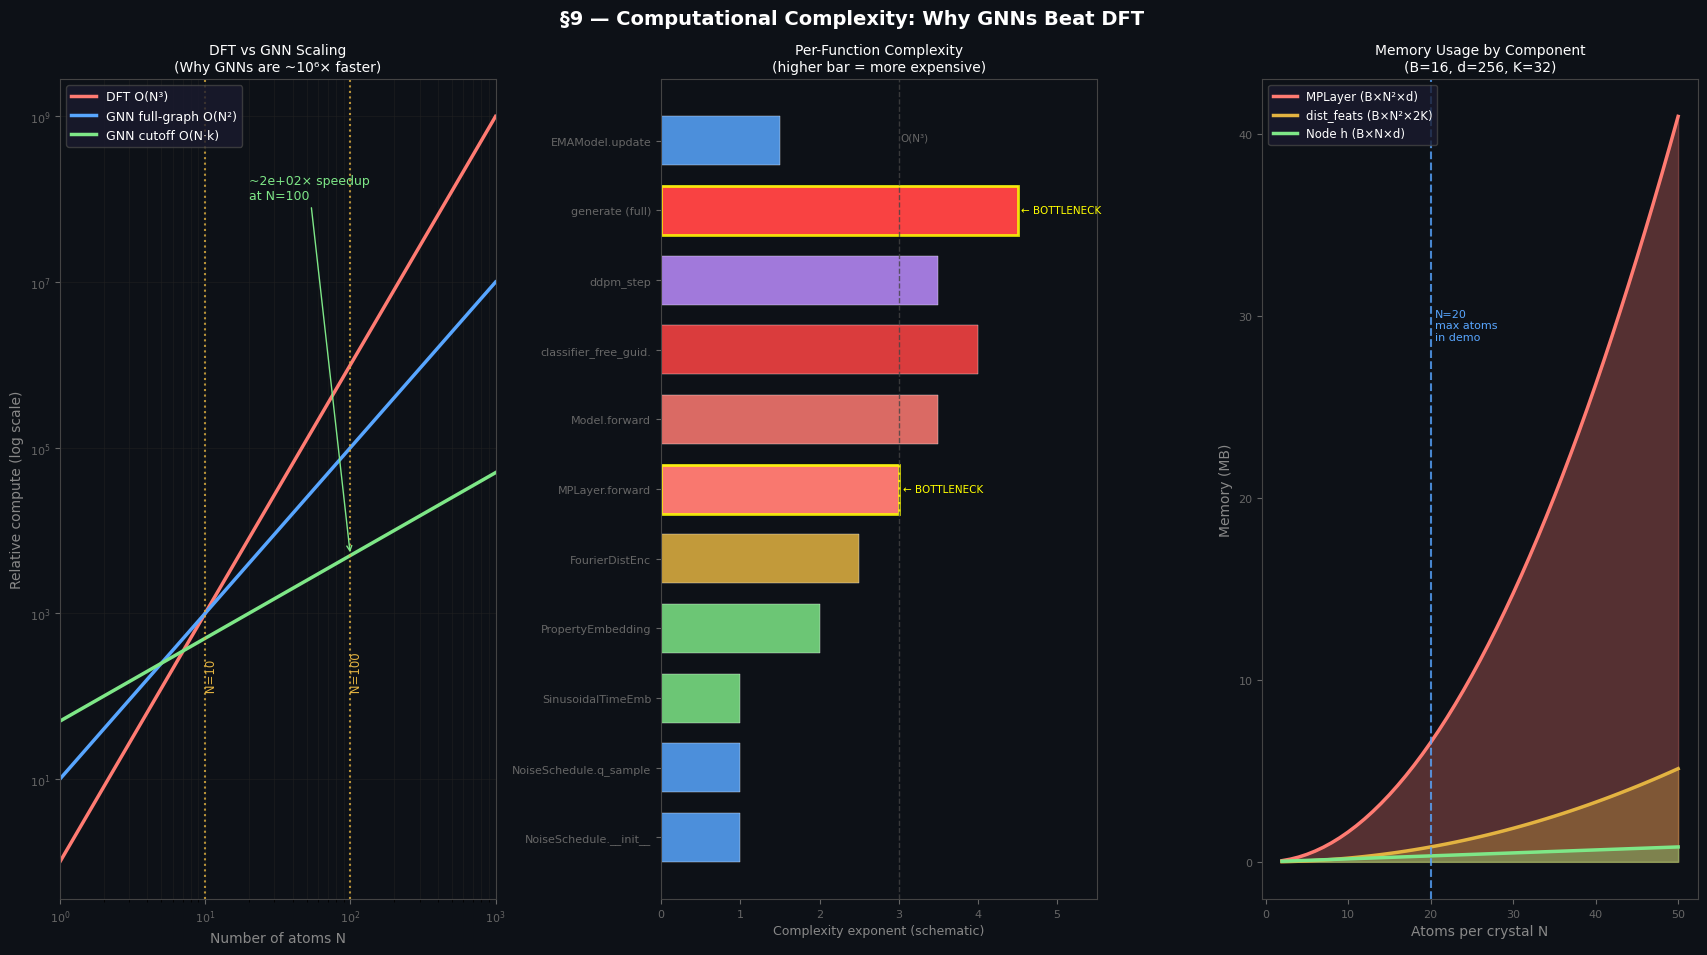

§9 Complexity — 3-panel visualization complete ✓


In [42]:

# ═══════════════════════════════════════════════════════════════════════════
#  VIZ §9 — Complexity: GNN vs DFT scaling, per-function breakdown
# ═══════════════════════════════════════════════════════════════════════════

fig = plt.figure(figsize=(18, 10), facecolor='#0d1117')
fig.suptitle('§9 — Computational Complexity: Why GNNs Beat DFT',
             color='white', fontsize=14, fontweight='bold', y=0.97)
gs = gridspec.GridSpec(1, 3, figure=fig, hspace=0.4, wspace=0.38,
                       left=0.06, right=0.97, top=0.90, bottom=0.08)

# ── Panel 1: Scaling comparison ───────────────────────────────────────────
ax1 = fig.add_subplot(gs[0, 0])
ax1.set_facecolor('#0d1117')
N_vals = np.logspace(0, 3, 200)
dft_cubic    = N_vals**3
gnn_quad     = N_vals**2 * 10
gnn_linear   = N_vals * 50

ax1.loglog(N_vals, dft_cubic,  color='#ff7b72', lw=2.5, label='DFT O(N³)')
ax1.loglog(N_vals, gnn_quad,   color='#58a6ff', lw=2.5, label='GNN full-graph O(N²)')
ax1.loglog(N_vals, gnn_linear, color='#7ee787', lw=2.5, label='GNN cutoff O(N·k)')
ax1.axvline(10,  color='#e3b341', ls=':', lw=1.5, alpha=0.8)
ax1.axvline(100, color='#e3b341', ls=':', lw=1.5, alpha=0.8)
ax1.text(10, 1e2, ' N=10', color='#e3b341', fontsize=8.5, rotation=90, va='bottom')
ax1.text(100, 1e2, ' N=100', color='#e3b341', fontsize=8.5, rotation=90, va='bottom')
ax1.set_xlabel('Number of atoms N', color='#888', fontsize=10)
ax1.set_ylabel('Relative compute (log scale)', color='#888', fontsize=10)
ax1.set_title('DFT vs GNN Scaling\n(Why GNNs are ~10⁶× faster)', color='white', fontsize=10)
ax1.legend(fontsize=9, facecolor='#1a1a2e', edgecolor='#444', labelcolor='white')
ax1.tick_params(colors='#666', labelsize=8)
plt.setp(ax1.spines.values(), color='#444')
ax1.grid(True, color='#222', lw=0.5, alpha=0.7, which='both')
ax1.set_xlim(1, 1000)

# Speedup annotation
N_ref = 100
speedup = dft_cubic[np.argmin(np.abs(N_vals-N_ref))] / gnn_linear[np.argmin(np.abs(N_vals-N_ref))]
ax1.annotate(f'~{speedup:.0e}× speedup\nat N=100', xy=(100, gnn_linear[np.argmin(np.abs(N_vals-100))]),
             xytext=(20, 1e8), color='#7ee787', fontsize=9,
             arrowprops=dict(arrowstyle='->', color='#7ee787'))

# ── Panel 2: Per-function O(·) horizontal bar chart ──────────────────────
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_facecolor('#0d1117')

funcs = ['NoiseSchedule.__init__', 'NoiseSchedule.q_sample', 'SinusoidalTimeEmb',
         'PropertyEmbedding', 'FourierDistEnc', 'MPLayer.forward', 'Model.forward',
         'classifier_free_guid.', 'ddpm_step', 'generate (full)', 'EMAModel.update']
exponents = [1.0, 1.0, 1.0, 2.0, 2.5, 3.0, 3.5, 4.0, 3.5, 4.5, 1.5]  # schematic
colors_fn = ['#58a6ff','#58a6ff','#7ee787','#7ee787','#e3b341','#ff7b72',
             '#ff7b72','#ff4444','#bc8cff','#ff4444','#58a6ff']
bottleneck = [False]*5 + [True] + [False]*3 + [True] + [False]

y_pos = np.arange(len(funcs))
bars = ax2.barh(y_pos, exponents, color=colors_fn, alpha=0.85, edgecolor='white', lw=0.3, height=0.7)

# Highlight bottlenecks
for i, is_bn in enumerate(bottleneck):
    if is_bn:
        ax2.barh(y_pos[i], exponents[i], color=colors_fn[i], alpha=0.85,
                 edgecolor='#ffff00', lw=2, height=0.7)
        ax2.text(exponents[i]+0.05, y_pos[i], '← BOTTLENECK', color='#ffff00', fontsize=7.5, va='center')

ax2.set_yticks(y_pos); ax2.set_yticklabels(funcs, fontsize=8, color='#ccc')
ax2.set_xlabel('Complexity exponent (schematic)', color='#888', fontsize=9)
ax2.set_title('Per-Function Complexity\n(higher bar = more expensive)', color='white', fontsize=10)
ax2.tick_params(colors='#666', labelsize=8); plt.setp(ax2.spines.values(), color='#444')
ax2.set_xlim(0, 5.5)
ax2.axvline(3, color='#444', lw=1, ls='--', alpha=0.8)
ax2.text(3.02, len(funcs)-1, 'O(N³)', color='#666', fontsize=7.5)

# ── Panel 3: Memory scaling ────────────────────────────────────────────────
ax3 = fig.add_subplot(gs[0, 2])
ax3.set_facecolor('#0d1117')
N_arr = np.arange(2, 51)
B, d, K = 16, 256, 32

dist_mem   = B * N_arr**2 * K * 4 / 1e6   # dist_feats (MB)
mp_mem     = B * N_arr**2 * d  * 4 / 1e6  # MPLayer (MB)
node_mem   = B * N_arr   * d  * 4 / 1e6   # node hidden (MB)

ax3.fill_between(N_arr, mp_mem, alpha=0.3, color='#ff7b72')
ax3.fill_between(N_arr, dist_mem, alpha=0.3, color='#e3b341')
ax3.fill_between(N_arr, node_mem, alpha=0.3, color='#7ee787')
ax3.plot(N_arr, mp_mem,   color='#ff7b72', lw=2.5, label=f'MPLayer (B×N²×d)')
ax3.plot(N_arr, dist_mem, color='#e3b341', lw=2.5, label=f'dist_feats (B×N²×2K)')
ax3.plot(N_arr, node_mem, color='#7ee787', lw=2.5, label=f'Node h (B×N×d)')

ax3.axvline(20, color='#58a6ff', ls='--', lw=1.5, alpha=0.8)
ax3.text(20.5, mp_mem[-1]*0.7, 'N=20\nmax atoms\nin demo', color='#58a6ff', fontsize=8)
ax3.set_xlabel('Atoms per crystal N', color='#888', fontsize=10)
ax3.set_ylabel('Memory (MB)', color='#888', fontsize=10)
ax3.set_title(f'Memory Usage by Component\n(B={B}, d={d}, K={K})', color='white', fontsize=10)
ax3.legend(fontsize=8.5, facecolor='#1a1a2e', edgecolor='#444', labelcolor='white')
ax3.tick_params(colors='#666', labelsize=8); plt.setp(ax3.spines.values(), color='#444')

plt.savefig(OUTPUT_DIR/'viz_9_complexity.png', dpi=120,
            bbox_inches='tight', facecolor='#0d1117')
plt.show()
print('§9 Complexity — 3-panel visualization complete ✓')


---
## §10 — Production Quick-Start

### Loading the Pre-Trained Checkpoint from HuggingFace

```python
# 1. Install
# pip install huggingface_hub

from huggingface_hub import hf_hub_download
ckpt_path = hf_hub_download(
    repo_id='paprakash/GuidedMatDiffusion_model',
    filename='model.ckpt'
)
scaler_path = hf_hub_download(
    repo_id='paprakash/GuidedMatDiffusion_model',
    filename='prop_scaler.pt'
)

# 2. Build model (same config as pre-trained)
model = CrystalDenoisingModel(hidden_dim=256, num_layers=8)
ckpt  = load_checkpoint(model, ckpt_path, use_ema=True)

# 3. Normalise your target Tc
scaler = torch.load(scaler_path)
target_Tc_K = 100.0                           # want Tc = 100 K
Tc_norm = (target_Tc_K - ckpt['Tc_mean']) / ckpt['Tc_std']

# 4. Generate
sched = NoiseSchedule(T=1000).to(DEVICE)
model.to(DEVICE).eval()

crystal = generate(
    model, sched,
    atom_types    = torch.tensor([56, 29, 8, 8, 8]),  # Ba-Cu-O3
    target_Tc_norm = Tc_norm,
    guide_w       = 5.0,          # tunable: 3-10
    n_steps       = 200,          # more = better quality
)
print(crystal)
```

### Key Hyperparameter Guide

| Parameter | Suggested | Effect |
|-----------|-----------|--------|
| `guide_w` (ω) | 3–7 | Higher → more on-target Tc, lower diversity |
| `n_steps` | 100–500 | Higher → better quality; linear cost |
| `n_epochs` | 200–1000 | Convergence depends on dataset size |
| `batch_size` | 32–256 | Larger → more stable gradients |
| `lr` | 1e-4 | Adam; cosine-annealed |
| `p_uncond` | 0.1 | CFG dropout fraction; too high → weak conditioning |
| `ema_decay` | 0.9999 | EMA smoothing; don't change unless you know why |

### Fine-Tuning on Your Own Dataset

```python
# Prepare a CSV with columns: cif_path, Tc_K
# Convert CIF files to (L, F, A) using pymatgen:

from pymatgen.core import Structure
def cif_to_tensors(path):
    s = Structure.from_file(path)
    L = torch.tensor(s.lattice.matrix.T, dtype=torch.float32)
    F = torch.tensor(s.frac_coords, dtype=torch.float32)
    A = torch.tensor([e.Z for e in s.species], dtype=torch.long)
    return L, F, A

# Then pass your dataset to run_training() with the pre-trained checkpoint
model = CrystalDenoisingModel(...)
load_checkpoint(model, 'pretrained.pt', use_ema=True)   # start from pretrained
history, ema = run_training(model, sched, your_dataset, lr=5e-5, n_epochs=100)
```

---

### References

| Resource | Link |
|---------|------|
| GuidedMatDiffusion paper | [arXiv:2509.25186](https://arxiv.org/abs/2509.25186) |
| DiffCSP paper (NeurIPS 2023) | [arXiv:2309.04475](https://arxiv.org/abs/2309.04475) |
| CFG paper (Ho & Salimans) | [arXiv:2207.12598](https://arxiv.org/abs/2207.12598) |
| DDPM paper (Ho et al.) | [arXiv:2006.11239](https://arxiv.org/abs/2006.11239) |
| Pre-trained model | [HuggingFace](https://huggingface.co/paprakash/GuidedMatDiffusion_model) |
| Dataset | [HuggingFace Datasets](https://huggingface.co/datasets/paprakash/GuidedMatDiffusion_data) |


In [43]:
# ── Final summary ─────────────────────────────────────────────────
print('='*60)
print('  GuidedMatDiffusion Hello World v2 — Complete!')
print('='*60)
print(f'  Output dir: {OUTPUT_DIR}')
print(f'  Checkpoints: {CKPT_DIR}')
print()
for f in sorted(OUTPUT_DIR.rglob('*')):
    if f.is_file():
        kb = f.stat().st_size / 1024
        print(f'  {str(f.relative_to(OUTPUT_DIR)):<45} {kb:7.1f} KB')

  GuidedMatDiffusion Hello World v2 — Complete!
  Output dir: outputs_new20260227_060951
  Checkpoints: outputs_new20260227_060951/checkpoints

  checkpoints/ckpt_epoch0015_20260227_061003.pt  4595.3 KB
  checkpoints/ckpt_epoch0030_20260227_061007.pt  4595.8 KB
  guidance_comparison_20260227_061011.png         431.3 KB
  training_curves_20260227_061007.png              90.9 KB
  viz_1_crystal_representation.png                446.3 KB
  viz_2_forward_diffusion.png                     357.5 KB
  viz_3_network_architecture.png                 1122.8 KB
  viz_4_classifier_free_guidance.png              307.4 KB
  viz_5_training.png                              331.7 KB
  viz_6_sampling.png                              463.8 KB
  viz_7_training_curves_detailed.png              286.9 KB
  viz_8_full_pipeline.png                         160.5 KB
  viz_9_complexity.png                            201.2 KB
